# Time Series Prediction in Spark: Apple Stock Adjusted Close Price

## Project Overview

This project utilized Machine Learning approaches in big data environment to construct models that can predict Apple stock adjusted close price as a form of time series data points. Various models were implemented and tuned, namely,Linear Regression, Random Forest, Decision Trees and Gradient Boosting Regressor. Moreover, the overall performance of all models was improved by adding market features and normalized the data. To compare different performance of every model, Symmetric Mean Absolute Percentage Error was used as evaluation metric.  

This jupyter notebook will have the following sections. 

1. Business Problem 
2. Data Pre-processing
3. Feature Engineering 
4. Target Variable
5. Model Implementation
6. Conclusion-Model Selection
7. References

## 1. Business Problem
The project aims to experiment time series analysis to forecast the adjusted close price at different time horizons (business days only) 1 day price prediction, weekly price prediction (5 days), bi-weekly price prediction (10 days) , monthly price prediction (21 days) and quarterly price prediction (63 days). The data used is for 21 years (1996-2017), this will help ML model to learn and generalized. 


The assumption used to forecast stock price inherited from the stochastic model that tomorrow price is more likely to be that of yesterday plus an error (random noise). In other words, stock prices that are close together in time will be more closely related than prices that are further apart. This will help financial analysts and investors to develop a trading strategy to take a position in stock market by selling or buying.  


The following project is developed in DataBrick Paltform by using ApacheSpark-Pyspark. A more interactive notebook can be found in the below link: 

Actual Project_Link: 

https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/7052157552859543/916867181931954/4143425856907931/latest.html

In [1]:
dbutils.library.installPyPI("mlflow", extras="extras")
dbutils.library.installPyPI("matplotlib", "2.2.2")
dbutils.library.installPyPI("seaborn","0.9.0")
dbutils.library.restartPython()

In [2]:
# Libraries
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import datetime
import pyspark.sql.functions as f
from pyspark.sql.window import Window
import numpy as np
from math import log
from pyspark.sql.types import *
from pyspark.sql.functions import desc, col, column,sqrt,isnan, when, count,date_format,to_timestamp
from math import log
from pyspark.sql.functions import udf,desc
from datetime import datetime
import seaborn as sns

from pyspark.ml.linalg import Vectors 
from pyspark.ml.feature import VectorAssembler, PCA 
from pyspark.ml.regression import LinearRegression 
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel, DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.mllib.util import MLUtils
from pyspark.sql.functions import percent_rank
!pip install mlflow
import mlflow.sklearn
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
import warnings
warnings.filterwarnings('ignore')

## 2. Data Pre-processing

Unnecessary columns such as open price, high, low, close price and volume were dropped. This was done because our target variable does not highly depend on them, they will cause a lot of noise. In the apple adjusted closed price, there was only one case where a cell left empty, thus we removed that null value. However, for volatility index (VIX) and bond market return weekend days were filled with dot from the source, therefore, we have removed all dots from every row such that we only have business days records. Finally, the numerical values were casted into double type in all datasets as they were initially in string format. 

In [3]:
# Create a spark session
spark = SparkSession.builder.appName('APPL_Project').getOrCreate()
# Read apple stock data
df_AP = spark.read.csv('FileStore/tables/AAPL.csv', inferSchema=True,header=True)
#Drop unnecessary columns that might create noise 
df_AP=df_AP.drop("Open","High","Low","Close","Volume")
# Create a new column named Adj_Close with new type of double,keep the orginal column as dummy to show null values in second cell and latter on will be dropped
df_AP =df_AP.withColumn('Adj_Close',f.col('Adj Close').cast('double'))
# Checking if there are any null/NaN value 
df_AP.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ['Adj Close']]).show()

+---------+
Adj Close|
+---------+
 0|
+---------+

In [4]:
# WOOPS! looks like there is a null value, we could not see it above because the type of column is in string format, let's see where that is?
df_AP.where(df_AP["Adj Close"] == 'null').show()
# Ok we have to clean data from null and recheck 
df_AP = df_AP.where(df_AP["Adj Close"] != 'null')
#Drop unnecessary columns that might create noise 
df_AP=df_AP.drop("Adj Close")
df_AP.describe().show()

+-------------------+---------+---------+
 Date|Adj Close|Adj_Close|
+-------------------+---------+---------+
1981-08-10 00:00:00| null| null|
+-------------------+---------+---------+

+-------+------------------+
summary| Adj_Close|
+-------+------------------+
 count| 9594|
 mean|24.362039631749024|
 stddev|44.760726226764575|
 min| 0.156476|
 max| 228.523819|
+-------+------------------+

## 3. Feature Engineering

1. Adding the daily VIX index and bond market return as external input features. This was done because both indexes are most common indicators used by investors to evaluate the market performance and measure volatility of stocks such as S&P500. 


2. Normalizing target variable (creating a new column for normalized target variable) and two external features by taking the log. Then, the log difference of target variable was taken to **remove stationarity** and to ease the process of interpolating and extrapolating for some machine learning models **(Trees cannot extrapolate unseen time series data)**. 


3. Taking the lag of log difference for every time horizon i.e. for one day forecasting, a lag of one day is taken  and the same for other time horizons. 


4. Adding the log return of stock price as feature along with its mean and standard deviation. The reason some statistical features are considered here, is because they can explain the dataset such that the machine learning model can learn from different inputs. 


5. Adding weekday where 1 stands for Monday and 7 stands for Sunday (I only considred 1-5 as business days). 



In summary, five data frames were created each dataframe represents time horizon and at each dataframe has nine features. 

In [5]:
# Reading the volatility index data VIX
df_VX = spark.read.csv('FileStore/tables/VIXCLS.csv', inferSchema=True,header=True)
# Rename the date for the purpose of when joining two data we did not mix the date column as spark is not case sensative
df_VX =df_VX.withColumnRenamed('DATE','DATEV')
# Checking if there are any null/NaN value 
df_VX.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["VIXCLS"]]).show()

+------+
VIXCLS|
+------+
 0|
+------+

In [6]:
# Getting statistical information about the volatility data 
df_VX.describe().show()
# We have some empty values which were fill in as ., that probably a weekend day where stock market is functioning 
(df_VX.filter(df_VX['VIXCLS'] =='.')).describe().show()
# Clean the data
df_VX = df_VX.filter(df_VX['VIXCLS'] != '.')
# Chnage the column type format to double to avoide any error in the data as intial reading is string
df_VX =df_VX.withColumn('VIXCLS',f.col('VIXCLS').cast('double'))
df_VX.describe().show()

+-------+------------------+
summary| VIXCLS|
+-------+------------------+
 count| 7796|
 mean|19.166277895855448|
 stddev| 7.731638029017534|
 min| .|
 max| 9.99|
+-------+------------------+

+-------+------+
summary|VIXCLS|
+-------+------+
 count| 268|
 mean| null|
 stddev| null|
 min| .|
 max| .|
+-------+------+

+-------+------------------+
summary| VIXCLS|
+-------+------------------+
 count| 7528|
 mean|19.166277895855448|
 stddev| 7.731638029017534|
 min| 9.14|
 max| 80.86|
+-------+------------------+

In [7]:
# Reading the US bond yield data
df_BY = spark.read.csv('FileStore/tables/BAMLH0A0HYM2.csv', inferSchema=True,header=True)
# Rename the date for the purpose of when joining two data we did not mix the date column as spark is not case sensative
df_BY =df_BY.withColumnRenamed('DATE','DATEBY')
# Checking if there are any null/NaN value 
df_BY.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["BAMLH0A0HYM2"]]).show()

+------------+
BAMLH0A0HYM2|
+------------+
 0|
+------------+

In [8]:
# Getting statistical information about the bond yiled data 
df_BY.describe().show()
# We have some empty values which were fill in as ., that probably a weekend day where stock market is functioning 
(df_BY.filter(df_BY['BAMLH0A0HYM2'] =='.')).describe().show()
# Clean the data
df_BY = df_BY.filter(df_BY['BAMLH0A0HYM2'] != '.')
# Chnage the column type format to double to avoide any error in the data as intial reading is string
df_BY = df_BY.withColumn('BAMLH0A0HYM2',f.col('BAMLH0A0HYM2').cast('double'))
df_BY.describe().show()

+-------+------------------+
summary| BAMLH0A0HYM2|
+-------+------------------+
 count| 6048|
 mean| 5.555903231207077|
 stddev|2.6948092003455884|
 min| .|
 max| 9.99|
+-------+------------------+

+-------+------------+
summary|BAMLH0A0HYM2|
+-------+------------+
 count| 75|
 mean| null|
 stddev| null|
 min| .|
 max| .|
+-------+------------+

+-------+------------------+
summary| BAMLH0A0HYM2|
+-------+------------------+
 count| 5973|
 mean| 5.555903231207077|
 stddev|2.6948092003455884|
 min| 2.41|
 max| 21.82|
+-------+------------------+

In [9]:
# Joining the apple stock data with volatility 
j_df = df_AP.join(df_VX, df_AP["Date"] == df_VX["DATEV"])
# Dropping the DATEV column
j_df = j_df.drop("DATEV")
#------------------------
# Joining all data together and get the final refine data 
df = j_df.join(df_BY, j_df["Date"] == df_BY["DATEBY"])
# Dropping DATEB column
df = df.drop("DATEBY")
df.describe().show()
df.show()
#------------------------
# Register the combined dataframe as sql data for reference in cluster
df.createOrReplaceTempView('Main_AP_Date')

+-------+------------------+------------------+-----------------+
summary| Adj_Close| VIXCLS| BAMLH0A0HYM2|
+-------+------------------+------------------+-----------------+
 count| 5533| 5533| 5533|
 mean| 41.55479614024945|20.306665461774834|5.609553587565498|
 stddev|52.662119171861036| 8.363894585801658|2.727863517563842|
 min| 0.40324| 9.14| 2.41|
 max| 228.523819| 80.86| 21.82|
+-------+------------------+------------------+-----------------+

+-------------------+---------+------+------------+
 Date|Adj_Close|VIXCLS|BAMLH0A0HYM2|
+-------------------+---------+------+------------+
1996-12-31 00:00:00| 0.650639| 20.92| 3.13|
1997-01-02 00:00:00| 0.654535| 21.14| 3.06|
1997-01-03 00:00:00| 0.677911| 19.13| 3.09|
1997-01-06 00:00:00| 0.557134| 19.89| 3.1|
1997-01-07 00:00:00| 0.545446| 19.35| 3.1|
1997-01-08 00:00:00| 0.549342| 20.24| 3.07|
1997-01-09 00:00:00| 0.553238| 20.91| 3.13|
1997-01-10 00:00:00| 0.568822| 19.63| 3.16|
1997-01-13 00:00:00| 0.564926| 19.84| 3.04|
1997-01-14 00:00:00| 0.557134| 19.27| 3.09|
1997-01-15 00:00:00| 0.537654| 19.4| 3.07|
1997-01-16 00:00:00| 0.522069| 19.61| 3.02|
1997-01-17 00:00:00| 0.522069| 18.63| 3.04|
1997-01-20 00:00:00| 0.527914| 18.6| 3.03|
1997-01-21 00:00:00| 0.537654| 17.81| 3.05|
1997-01-22 00:00:00| 0.535706| 17.09| 2.99|
1997-01-23 00:00:00| 0.537654| 18.47| 2.97|
1997-01-24 00:00:00| 0.525966| 19.33| 2.94|
1997-01-27 00:00:00| 0.518174| 20.16| 2.9|
1997-01-28 00:00:00| 0.518174| 20.74| 2.92|
+-------------------+---------+------+------------+
only showing top 20 rows

In [10]:
df = df.withColumn("Date",to_timestamp(col("Date")))
df = df.withColumn("weekDay_Nu", date_format(col("Date"), "u"))
df = df.withColumn("weekDay_Nu",f.col("weekDay_Nu").cast('double'))
df.describe().show()

+-------+------------------+------------------+-----------------+------------------+
summary| Adj_Close| VIXCLS| BAMLH0A0HYM2| weekDay_Nu|
+-------+------------------+------------------+-----------------+------------------+
 count| 5533| 5533| 5533| 5533|
 mean| 41.55479614024945|20.306665461774834|5.609553587565498|3.0191577805891923|
 stddev|52.662119171861036| 8.363894585801658|2.727863517563842|1.3995641090907875|
 min| 0.40324| 9.14| 2.41| 1.0|
 max| 228.523819| 80.86| 21.82| 5.0|
+-------+------------------+------------------+-----------------+------------------+

In [11]:
# Normalize the data by taking the log to avoide outliers that might skew the data
df = df.withColumn("Log_Adj_Close", f.log("Adj_Close"))
df = df.withColumn("log_VX", f.log("VIXCLS"))
df = df.withColumn("log_BY", f.log("BAMLH0A0HYM2"))
#Remove stationarity from Adj_CLose price.
w = Window().orderBy('Date')
df = df.withColumn("Log_Diff",(f.col("Log_Adj_Close") -f.lag('Log_Adj_Close',1).over(w)))
df=df.drop("VIXCLS","BAMLH0A0HYM2")

# Creating seperate dataframes for every horizon
df1=df
df5=df
df10=df
df21=df
df63=df
df1 = df1.withColumnRenamed('Log_Diff','Log_Diff1')
df5 = df5.withColumnRenamed('Log_Diff','Log_Diff5')
df10 = df10.withColumnRenamed('Log_Diff','Log_Diff10')
df21 = df21.withColumnRenamed('Log_Diff','Log_Diff21')
df63 = df63.withColumnRenamed('Log_Diff','Log_Diff63')

In [12]:
# Creating the lags for every horizon for current input features
df1=df1.withColumn("Lag_{}".format(1), f.lag('Log_Adj_Close',1).over(w)) # One day lag
df1=df1.withColumn("Lag_VIX{}".format(1), f.lag("log_VX",1).over(w)) # One day lag VIX
df1=df1.withColumn("Lag_BY{}".format(1), f.lag("log_BY",1).over(w)) # One day lag BY

df5=df5.withColumn("Lag_{}".format(5), f.lag('Log_Adj_Close',5).over(w)) # One week lag
df5=df5.withColumn("Lag_VIX{}".format(5), f.lag("log_VX",5).over(w)) # One week lag VIX
df5=df5.withColumn("Lag_BY{}".format(5), f.lag("log_BY",5).over(w)) # One week lag BY

df10=df10.withColumn("Lag_{}".format(10), f.lag('Log_Adj_Close',10).over(w)) # Two week lag
df10=df10.withColumn("Lag_VIX{}".format(10), f.lag("log_VX",10).over(w)) # Two week lag VIX
df10=df10.withColumn("Lag_BY{}".format(10), f.lag("log_BY",10).over(w)) # Two week lag BY

df21=df21.withColumn("Lag_{}".format(21), f.lag('Log_Adj_Close',21).over(w)) # One month lag
df21=df21.withColumn("Lag_VIX{}".format(21), f.lag("log_VX",21).over(w)) # One month  lag VIX
df21=df21.withColumn("Lag_BY{}".format(21), f.lag("log_BY",21).over(w)) # One month  BY

df63=df63.withColumn("Lag_{}".format(63), f.lag('Log_Adj_Close',63).over(w)) # Quarterly lag
df63=df63.withColumn("Lag_VIX{}".format(63), f.lag("log_VX",63).over(w)) # # Quarterly lag VIX
df63=df63.withColumn("Lag_BY{}".format(63), f.lag("log_BY",63).over(w)) # # Quarterly lag BY

# Creating the lags for every horizon for difference price data
df1=df1.withColumn("lag{}".format(1), f.lag('Log_Diff1',1).over(w)) # One day lag
df5=df5.withColumn("lag{}".format(5), f.lag('Log_Diff5',5).over(w)) # One week lag
df10=df10.withColumn("lag{}".format(10), f.lag('Log_Diff10',10).over(w)) # Two week lag
df21=df21.withColumn("lag{}".format(21), f.lag('Log_Diff21',21).over(w)) # One month lag
df63=df63.withColumn("lag{}".format(63), f.lag('Log_Diff63',63).over(w)) # Quarterky lag
#------------------
# Get the returns for 1 day, 1 week, two weeks, a month and quarterly (4 months) from data after removing the stationarity
df1 = df1.withColumn("daily_return",  (f.col('Log_Diff1')- f.col("lag1")) / f.col("lag1"))
df5 = df5.withColumn("weekly_return",  (f.col('Log_Diff5')- f.col("lag5")) / f.col("lag5"))
df10 = df10.withColumn("biweekly_return",  (f.col('Log_Diff10')- f.col("lag10")) / f.col("lag10"))
df21 = df21.withColumn("monthly_return",  (f.col('Log_Diff21')- f.col("lag21")) / f.col("lag21"))
df63 = df63.withColumn("quarterly_return",  (f.col('Log_Diff63')- f.col("lag63")) / f.col("lag63"))
#-----------------
# Get the mean and the standard deviation for one day price and daily return on data after removing stationarity
w1 = Window.orderBy('Date').rowsBetween(-1, 0)
df1 = df1.withColumn("daily_mean", f.avg('Log_Diff1').over(w1))
df1 = df1.withColumn("daily_std", f.stddev('Log_Diff1').over(w1))
df1 = df1.withColumn("dailyreturn_mean", f.avg('daily_return').over(w1))
df1 = df1.withColumn("dailyreturn_std", f.stddev('daily_return').over(w1))
#----------------
# Get the mean and the standard deviation for 5 days price and weekly return after removing statinoarity
w5 = Window.orderBy('Date').rowsBetween(-5, 0)
df5 = df5.withColumn("weekly_mean", f.avg('Log_Diff5').over(w5))
df5 = df5.withColumn("weekly_std", f.stddev('Log_Diff5').over(w5))
df5 = df5.withColumn("weeklyreturn_mean", f.avg('weekly_return').over(w5))
df5 = df5.withColumn("weeklyreturn_std", f.stddev('weekly_return').over(w5))
#----------------
# Get the mean and the standard deviation for 10 days price and biweekly return after removing statinoarity
w10 = Window.orderBy('Date').rowsBetween(-10, 0)
df10 = df10.withColumn("biweekly_mean", f.avg('Log_Diff10').over(w10))
df10 = df10.withColumn("biweekly_std", f.stddev('Log_Diff10').over(w10))
df10 = df10.withColumn("biweeklyreturn_mean", f.avg('biweekly_return').over(w10))
df10 = df10.withColumn("biweeklyreturn_std", f.stddev('biweekly_return').over(w10))
#----------------
# Get the mean and the standard deviation for 21 days price and monthly return after removing statinoarity
w21 = Window.orderBy('Date').rowsBetween(-21, 0)
df21 = df21.withColumn("monthly_mean", f.avg('Log_Diff21').over(w21))
df21 = df21.withColumn("monthly_std", f.stddev('Log_Diff21').over(w21))
df21 = df21.withColumn("monthlyreturn_mean", f.avg('monthly_return').over(w21))
df21 = df21.withColumn("monthlyreturn_std", f.stddev('monthly_return').over(w21))
#----------------
# Get the mean and the standard deviation for 63 days price and quarterly return after removing statinoarity
w63 = Window.orderBy('Date').rowsBetween(-63, 0)
df63 = df63.withColumn("quarterly_mean", f.avg('Log_Diff63').over(w63))
df63 = df63.withColumn("quarterly_std", f.stddev('Log_Diff63').over(w63))
df63 = df63.withColumn("quarterlyreturn_mean", f.avg('quarterly_return').over(w63))
df63 = df63.withColumn("quarterlyreturn_std", f.stddev('quarterly_return').over(w63))

In [13]:
# Removing null and nan values from the data due to lags 
df1=df1.na.drop()
df1.describe().show()
print((df1.count(), len(df1.columns)))
#----------------
df5=df5.na.drop()
df5.describe().show()
print((df5.count(), len(df5.columns)))
#----------------
df10=df10.na.drop()
df10.describe().show()
print((df10.count(), len(df10.columns)))
#----------------
df21=df21.na.drop()
df21.describe().show()
print((df21.count(), len(df21.columns)))
#----------------
df63=df63.na.drop()
df63.describe().show()
print((df63.count(), len(df63.columns)))

+-------+-----------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+
summary| Adj_Close| weekDay_Nu| Log_Adj_Close| log_VX| log_BY| Log_Diff1| Lag_1| Lag_VIX1| Lag_BY1| lag1| daily_return| daily_mean| daily_std| dailyreturn_mean| dailyreturn_std|
+-------+-----------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+
 count| 5432| 5432| 5432| 5432| 5432| 5432| 5432| 5432| 5432| 5432| 5432| 5432| 5432| 5432| 5432|
 mean|42.16015478921211| 3.02080265095729| 2.4904478478148317| 2.938341966328714|1.6351383958374581|9.390688744575634E-4| 2.489508778940374| 2.9381578838307676|1.6350495714024516|9.204767980068432E-4|-0.8472918549732985|9.297728362322039E-4|0.018964740973597738|-0.8459134585037292| 4.931024420538519|
 stddev|52.80446634889889|1.4006501699663416| 1.8793784904804407|0.3644296986403688|0.4065447227647379|0.028262144227395467| 1.8793870974127682|0.36438608734279754|0.4066036440550838| 0.02848443108616337| 25.03842102980663| 0.01975366255396422|0.021678786657009685| 17.70695182758457|24.548964602690607|
 min| 0.40324| 1.0|-0.9082233607963963|2.2126603854660587|0.8796267475025636| -0.7312469307240665|-0.9082233607963963| 2.2126603854660587|0.8796267475025636| -0.7312469307240665| -333.9560282846434| -0.3956324734364349|3.211058011700758...| -167.9240127086782| 0.0|
 max| 228.523819| 5.0| 5.431640445601794| 4.392719264212625|3.0828269804049246| 0.2135741943167364| 5.431640445601794| 4.392719264212625|3.0828269804049246| 0.2135741943167364| 1536.3445780268003| 0.1158669784691584| 0.5800995250510195| 767.8261136428764| 1087.068535890718|
+-------+-----------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+

(5432, 16)
+-------+------------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+
summary| Adj_Close| weekDay_Nu| Log_Adj_Close| log_VX| log_BY| Log_Diff5| Lag_5| Lag_VIX5| Lag_BY5| lag5| weekly_return| weekly_mean| weekly_std| weeklyreturn_mean| weeklyreturn_std|
+-------+------------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+
 count| 5475| 5475| 5475| 5475| 5475| 5475| 5475| 5475| 5475| 5475| 5475| 5475| 5475| 5475| 5475|
 mean|41.910875887305984|3.0191780821917806| 2.475405681604791| 2.939447769553996|1.6352978026818752|0.001046548902717...| 2.470256255796816| 2.9391023184062246| 1.6347376668426092|9.913068161485573E-4|-0.9614344182014503|0.00102345543735388| 0.02282518497690065|-0.9644315910631943| 6.549014957185198|
 stddev| 52.74642681417552| 1.398691014796371| 1.8835290450395659|0.3641328093725985|0.4073978319215999|0.028528566634713304| 1.8842597142049888|0.36390523263211594|0.40764917955317526| 0.02881567306946193| 15.833459774657355|0.01158862391161001| 0.01713486158750545| 6.433489335032283|14.413179261052948|
 min| 0.40324| 1.0|-0.9082233607963963|2.2126603854660587|0.8796267475025636| -0.7312469307240665|-0.9082233607963963| 2.2126603854660587|

In [14]:
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

## Dataframes for Plotting!!
df1_pdf = df1.select("Date", "Adj_Close", "Log_Adj_Close", "Log_Diff1").toPandas()
# setting Date as index
df1_pdf = df1_pdf.set_index('Date')
# Add columns with year, month, and weekday name
df1_pdf['Year'] = df1_pdf.index.year
df1_pdf['Month'] = df1_pdf.index.month
df1_pdf['Weekday Name'] = df1_pdf.index.weekday_name

## 4.Target Variable 

This is a supervised regression machine learning problem where the target variable (Adjusted close price) is a continuous time series data points as shown in figure blow. It can be seen that data is not stationary i.e. the mean and variance are not constant over time, thus I have to remove stationarity by taking the difference with 1-day lag. Now, the target variable will be the price difference which will be predicted by the models, however, after we get the predicted price difference, it will be back-transformed to obtain predicted adjusted close price. 

In [15]:
fig, ax = plt.subplots()
#sns.set_style("darkgrid")
#ax.plot(df1_pdf['Adj_Close'], marker='o', linestyle='-')
ax = sns.lineplot(x=df1_pdf.index,y='Adj_Close',data=df1_pdf, markers=True, dashes=False, legend="full")
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_title('Daily adjusted price from 1997 to 2018')
display(fig)

In [16]:
fig, axes = plt.subplots()
sns.boxplot(data=df1_pdf, x='Year', y="Adj_Close", ax=axes)
axes.set_ylabel('Daily Adjusted Close Price')
axes.set_title('Daily Adjusted Close Price Distribution By Year')
display(fig)

In [17]:
fig, axes = plt.subplots()
sns.boxplot(data=df1_pdf, x='Year', y="Log_Adj_Close", ax=axes)
axes.set_ylabel('Normalized Daily Adjusted Close Price')
axes.set_title('Normalized Daily Adjusted Close Price Distribution By Year')
display(fig)

In [18]:
fig, axes = plt.subplots()
sns.boxplot(data=df1_pdf, x='Year', y="Log_Diff1", ax=axes)
axes.set_ylabel('Stationary Normalized Daily Adjusted Close Price ')
axes.set_title('Stationary Normalized Daily Adjusted Close Price Distribution By Year')
display(fig)

In [19]:
fig, axes = plt.subplots()
sns.boxplot(data=df1_pdf, x='Month', y="Adj_Close", ax=axes)
axes.set_ylabel('Daily Adjusted Close Price')
axes.set_title('Daily Adjusted Close Price Distribution By Month')
display(fig)

In [20]:
fig, axes = plt.subplots()
sns.boxplot(data=df1_pdf, x='Month', y="Log_Adj_Close", ax=axes)
axes.set_ylabel('Normalized Daily Adjusted Close Price')
axes.set_title('Normalized Daily Adjusted Close Price Distribution By Month')
display(fig)

In [21]:
fig, axes = plt.subplots()
sns.boxplot(data=df1_pdf, x='Month', y="Log_Diff1", ax=axes)
axes.set_ylabel('Stationary Normalized Daily Adjusted Close Price ')
axes.set_title('Stationary Normalized Daily Adjusted Close Price Distribution By Month')
display(fig)

In [22]:
fig, axes = plt.subplots()
sns.boxplot(data=df1_pdf, x='Weekday Name', y="Adj_Close", ax=axes)
axes.set_ylabel('Daily Adjusted Close Price')
axes.set_title('Daily Adjusted Close Price Distribution By Weekday')
display(fig)

In [23]:
fig, axes = plt.subplots()
sns.boxplot(data=df1_pdf, x='Weekday Name', y="Log_Adj_Close", ax=axes)
axes.set_ylabel('Normalized Daily Adjusted Close Price')
axes.set_title('Normalized Daily Adjusted Close Price Distribution By Weekday')
display(fig)

In [24]:
fig, axes = plt.subplots()
sns.boxplot(data=df1_pdf, x='Weekday Name', y="Log_Diff1", ax=axes)
axes.set_ylabel('Stationary Normalized Daily Adjusted Close Price')
axes.set_title('Stationary Normalized Daily Adjusted Close Price Distribution By Weekday')
display(fig)

In [25]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['Adj_Close', 'Log_Adj_Close', 'Log_Diff1']
# Resample to weekly frequency, aggregating with mean
df1_pdf_weekly_mean = df1_pdf[data_columns].resample('W').mean()
df1_pdf_weekly_mean.head(3)
df1_pdf_monthly_mean = df1_pdf[data_columns].resample('M').mean()
df1_pdf_monthly_mean.head(3)
df1_pdf_quarterly_mean = df1_pdf[data_columns].resample('Q').mean()
df1_pdf_quarterly_mean.head(3)
df1_pdf_yearly_mean = df1_pdf[data_columns].resample('A').mean()
df1_pdf_yearly_mean.head(3)

Adj_Close 
 Log_Adj_Close 
 Log_Diff1 
 
 
 Date 
 
 
 
 
 
 
 
 1997-12-31 
 0.557226 
 -0.596097 
 -0.003073 
 
 
 1998-12-31 
 0.956925 
 -0.070386 
 0.004561 
 
 
 1999-12-31 
 1.811980 
 0.529415 
 0.003731

In [26]:
# Start and end of the date range to extract
start, end = '2008-01', '2008-12'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(df1_pdf.loc[start:end, 'Adj_Close'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df1_pdf_weekly_mean.loc[start:end, 'Adj_Close'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(df1_pdf_monthly_mean.loc[start:end, 'Adj_Close'],
marker='*', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(df1_pdf_quarterly_mean.loc[start:end, 'Adj_Close'],
marker='*', markersize=8, linestyle='-', label='Quarterly Mean Resample')
ax.plot(df1_pdf_yearly_mean.loc[start:end, 'Adj_Close'],
marker='*', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Daily Adjusted Close Price')
ax.legend();
display(fig)

In [27]:
# Start and end of the date range to extract
start, end = '2008-01', '2008-12'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(df1_pdf.loc[start:end, 'Log_Adj_Close'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df1_pdf_weekly_mean.loc[start:end, 'Log_Adj_Close'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(df1_pdf_monthly_mean.loc[start:end, 'Log_Adj_Close'],
marker='*', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(df1_pdf_quarterly_mean.loc[start:end, 'Log_Adj_Close'],
marker='*', markersize=8, linestyle='-', label='Quarterly Mean Resample')
ax.plot(df1_pdf_yearly_mean.loc[start:end, 'Log_Adj_Close'],
marker='*', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Normalized Daily Adjusted Close Price')
ax.legend();
display(fig)

In [28]:
# Start and end of the date range to extract
start, end = '2008-01', '2008-12'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(df1_pdf.loc[start:end, 'Log_Diff1'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df1_pdf_weekly_mean.loc[start:end, 'Log_Diff1'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(df1_pdf_monthly_mean.loc[start:end, 'Log_Diff1'],
marker='*', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(df1_pdf_quarterly_mean.loc[start:end, 'Log_Diff1'],
marker='*', markersize=8, linestyle='-', label='Quarterly Mean Resample')
ax.plot(df1_pdf_yearly_mean.loc[start:end, 'Log_Diff1'],
marker='*', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Stationary Normalized Daily Adjusted Close Price')
ax.legend();
display(fig)

In [29]:
# Compute the centered n-day rolling mean
df1_pdf_5d = df1_pdf[data_columns].rolling(5, center=True).mean()
df1_pdf_10d = df1_pdf[data_columns].rolling(10, center=True).mean()
df1_pdf_21d = df1_pdf[data_columns].rolling(21, center=True).mean()
df1_pdf_63d = df1_pdf[data_columns].rolling(63, center=True).mean()
df1_pdf_253d = df1_pdf[data_columns].rolling(253, center=True).mean()
df1_pdf_5d.head(10)

Adj_Close 
 Log_Adj_Close 
 Log_Diff1 
 
 
 Date 
 
 
 
 
 
 
 
 1997-01-06 
 NaN 
 NaN 
 NaN 
 
 
 1997-01-07 
 NaN 
 NaN 
 NaN 
 
 
 1997-01-08 
 0.554796 
 -0.589258 
 -0.035090 
 
 
 1997-01-09 
 0.556355 
 -0.586480 
 0.002778 
 
 
 1997-01-10 
 0.558692 
 -0.582240 
 0.004240 
 
 
 1997-01-13 
 0.556355 
 -0.586541 
 -0.004301 
 
 
 1997-01-14 
 0.550121 
 -0.598139 
 -0.011598 
 
 
 1997-01-15 
 0.540770 
 -0.615292 
 -0.017154 
 
 
 1997-01-16 
 0.534926 
 -0.625914 
 -0.016505 
 
 
 1997-01-17 
 0.531030 
 -0.633032 
 -0.013001

In [30]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
# Start and end of the date range to extract
start, end = '2008-01', '2010-12'

fig, ax = plt.subplots()
ax.plot(df1_pdf.loc[start:end, 'Adj_Close'], marker='.', markersize=2, 
linestyle='None', label='Daily')
ax.plot(df1_pdf_5d.loc[start:end, 'Adj_Close'], linewidth=2, label='5-d Rolling Mean')
ax.plot(df1_pdf_10d.loc[start:end, 'Adj_Close'], linewidth=2.5,
label='Trend (10-d Rolling Mean)')
ax.plot(df1_pdf_21d.loc[start:end, 'Adj_Close'], linewidth=3,
label='Trend (21-d Rolling Mean)')
ax.plot(df1_pdf_63d.loc[start:end, 'Adj_Close'], linewidth=3.5,
label='Trend (63-d Rolling Mean)')
ax.plot(df1_pdf_253d.loc[start:end, 'Adj_Close'],linewidth=4,
label='Trend (253-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Adjusted Close Price')
ax.set_title('Trends in Adjusted Close Price');
display(fig)

In [31]:
# We have about 8 features and 1 target including the Date
df_PCA = df1
pca_columns = ['Lag_VIX1','Lag_BY1','weekDay_Nu','lag1','daily_return','daily_mean','daily_std','dailyreturn_mean','dailyreturn_std']
pca_assembler = VectorAssembler(inputCols=pca_columns,outputCol="features")
pca_output = pca_assembler.transform(df_PCA)

pca = PCA(k=8, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(pca_output)

df_PCA = pca_model.transform(pca_output).select('Date','Log_Diff1','pcafeatures')
df_PCA.show()

m = pca_model.pc.values.reshape(9, 8).transpose()
m_df=pd.DataFrame(m)
m_df.columns=pca_columns
print("The Coresponding Daily Features and its PCA: ")
print(m_df.idxmax(axis=1).values)
pca_model.explainedVariance

+-------------------+--------------------+--------------------+
 Date| Log_Diff1| pcafeatures|
+-------------------+--------------------+--------------------+
1997-01-06 00:00:00|-0.19621022538720068|[0.24372918356796...|
1997-01-07 00:00:00|-0.02120197687773...|[0.12239873774156...|
1997-01-08 00:00:00|0.007117389753454...|[-1.1938113338460...|
1997-01-09 00:00:00|0.007067090306485446|[0.24883308777863...|
1997-01-10 00:00:00|0.027779266977113526|[3.82729679819443...|
1997-01-13 00:00:00|-0.00687280654214...|[1.37023580770632...|
1997-01-14 00:00:00|-0.01388896361718...|[1.57638745018649...|
1997-01-15 00:00:00|-0.03559055490705...|[1.83962450368795...|
1997-01-16 00:00:00|-0.02941546753794...|[0.94955091151014...|
1997-01-17 00:00:00| 0.0|[-0.5697668277026...|
1997-01-22 00:00:00|-0.00362972747023...|[-0.1196234945706...|
1997-01-23 00:00:00|0.003629727470239...|[-1.6966463701642...|
1997-01-24 00:00:00|-0.02197865872784...|[-4.5073133644637...|
1997-01-27 00:00:00|-0.01492547867411187|[0.96012502624131...|
1997-01-28 00:00:00| 0.0|[-0.6647467713293...|
1997-02-04 00:00:00| -0.0591882717479838|[2.50112764926611...|
1997-02-05 00:00:00|-0.00816322511642...|[0.42439072708741...|
1997-02-06 00:00:00|0.048008726094260434|[-3.6770778084034...|
1997-02-07 00:00:00|-0.01178783686420...|[-0.2853088166871...|
1997-02-10 00:00:00|-0.01192844912413...|[0.25832140793649...|
+-------------------+--------------------+--------------------+
only showing top 20 rows

The Coresponding Daily Features and its PCA: 
['Lag_BY1' 'dailyreturn_mean' 'lag1' 'dailyreturn_mean' 'daily_return'
 'lag1' 'weekDay_Nu' 'Lag_VIX1']
 Out[ 52 ]: DenseVector([0.7187, 0.2192, 0.0607, 0.0013, 0.0002, 0.0, 0.0, 0.0])

In [32]:
m_df.head(9)

Lag_VIX1 
 Lag_BY1 
 weekDay_Nu 
 lag1 
 daily_return 
 daily_mean 
 daily_std 
 dailyreturn_mean 
 dailyreturn_std 
 
 
 
 
 0 
 -0.000089 
 0.604988 
 -0.049867 
 0.000039 
 -0.000163 
 0.000057 
 -0.008117 
 -0.000203 
 0.006191 
 
 
 1 
 0.000044 
 -0.000176 
 0.747060 
 -0.884298 
 0.000093 
 -0.001652 
 0.000068 
 0.850340 
 -0.000128 
 
 
 2 
 -0.000767 
 0.000669 
 -0.000392 
 0.275480 
 0.002223 
 0.008404 
 -0.002679 
 -0.000003 
 0.142005 
 
 
 3 
 0.000002 
 0.001263 
 0.001105 
 0.000537 
 -0.001041 
 0.000549 
 0.020158 
 0.513852 
 0.000016 
 
 
 4 
 0.646888 
 0.000006 
 0.002041 
 -0.000804 
 0.649929 
 -0.000442 
 -0.000883 
 -0.112913 
 -0.017111 
 
 
 5 
 0.000002 
 -0.662882 
 0.000021 
 0.999996 
 0.759942 
 0.759663 
 0.000763 
 0.000006 
 0.989507 
 
 
 6 
 -0.000003 
 0.000014 
 0.376991 
 0.000339 
 0.000260 
 -0.649946 
 0.010649 
 -0.000005 
 0.000052 
 
 
 7 
 0.464246 
 0.000047 
 0.000006 
 0.000564 
 -0.002636 
 -0.000928 
 -0.003792 
 -0.019503 
 -0.000056

In [33]:
# We have about 8 features and 1 target including the Date
df_PCA5 = df5
pca_columns = ['Lag_VIX5','Lag_BY5','weekDay_Nu','lag5','weekly_return','weekly_mean','weekly_std','weeklyreturn_mean','weeklyreturn_std']
pca_assembler = VectorAssembler(inputCols=pca_columns,outputCol="features")
pca_output = pca_assembler.transform(df_PCA5)

pca = PCA(k=8, inputCol="features", outputCol="pcaFeatures")
pca_model5 = pca.fit(pca_output)

df_PCA = pca_model5.transform(pca_output).select('Date','Log_Diff5','pcafeatures')
df_PCA.show()

m5 = pca_model5.pc.values.reshape(9, 8).transpose()
m_df5=pd.DataFrame(m5)
m_df5.columns=pca_columns

print("The Coresponding Weekly Features and its PCA: ")
print(m_df5.idxmax(axis=1).values)
pca_model5.explainedVariance

+-------------------+--------------------+--------------------+
 Date| Log_Diff5| pcafeatures|
+-------------------+--------------------+--------------------+
1997-01-10 00:00:00|0.027779266977113526|[0.28945276625919...|
1997-01-13 00:00:00|-0.00687280654214...|[1.14957862245207...|
1997-01-14 00:00:00|-0.01388896361718...|[0.54306254855291...|
1997-01-15 00:00:00|-0.03559055490705...|[6.67846679889494...|
1997-01-16 00:00:00|-0.02941546753794...|[6.08525004849685...|
1997-01-17 00:00:00| 0.0|[2.23290098207969...|
1997-01-20 00:00:00|0.011133628597030598|[3.73317516120804...|
1997-01-21 00:00:00|0.018281838940914064|[3.45191254981308...|
1997-01-22 00:00:00|-0.00362972747023...|[2.12281288618888...|
1997-01-23 00:00:00|0.003629727470239...|[2.00555522345923...|
1997-01-27 00:00:00|-0.01492547867411187|[2.78181213615925...|
1997-01-28 00:00:00| 0.0|[1.46342555792170...|
1997-01-29 00:00:00| 0.0|[1.37087847796977...|
1997-01-30 00:00:00|0.007488669864009756|[-0.3983188736155...|
1997-02-03 00:00:00|-0.02646631632633145|[0.36659668059432...|
1997-02-04 00:00:00| -0.0591882717479838|[-2.1041579312198...|
1997-02-07 00:00:00|-0.01178783686420...|[3.06759803404518...|
1997-02-10 00:00:00|-0.01192844912413...|[1.27323839893641...|
1997-02-11 00:00:00|0.003991980365811387|[1.83024312285900...|
1997-02-12 00:00:00|0.003976107800544...|[1.93472616063830...|
+-------------------+--------------------+--------------------+
only showing top 20 rows

The Coresponding Weekly Features and its PCA: 
['Lag_BY5' 'weeklyreturn_mean' 'weekDay_Nu' 'weeklyreturn_mean'
 'weeklyreturn_std' 'Lag_BY5' 'weekly_mean' 'weeklyreturn_mean']
 Out[ 54 ]: DenseVector([0.5293, 0.4011, 0.0651, 0.0039, 0.0005, 0.0001, 0.0, 0.0])

In [34]:
m_df5.head(9)

Lag_VIX5 
 Lag_BY5 
 weekDay_Nu 
 lag5 
 weekly_return 
 weekly_mean 
 weekly_std 
 weeklyreturn_mean 
 weeklyreturn_std 
 
 
 
 
 0 
 -3.030447e-04 
 0.335334 
 -0.006643 
 -0.000007 
 0.000120 
 -0.000019 
 0.007981 
 0.000354 
 -0.007177 
 
 
 1 
 6.846836e-04 
 -0.002059 
 0.939316 
 -0.981164 
 0.000051 
 0.001147 
 -0.000035 
 0.979233 
 0.000039 
 
 
 2 
 4.176540e-04 
 0.000249 
 0.002180 
 -0.072325 
 0.001183 
 -0.008976 
 -0.001134 
 -0.000012 
 -0.095688 
 
 
 3 
 -3.430668e-06 
 0.000240 
 0.003098 
 0.004947 
 0.000468 
 -0.003751 
 -0.022980 
 0.194660 
 -0.000007 
 
 
 4 
 -9.221131e-01 
 -0.000002 
 -0.001273 
 0.002017 
 -0.646008 
 -0.001232 
 0.000477 
 -0.055849 
 0.200577 
 
 
 5 
 1.260721e-05 
 0.342982 
 0.000047 
 -0.999985 
 -0.763247 
 -0.762911 
 -0.001827 
 0.000065 
 -0.974720 
 
 
 6 
 -4.721431e-07 
 0.000021 
 0.179083 
 0.000302 
 -0.004740 
 0.646037 
 0.008940 
 0.000021 
 0.000038 
 
 
 7 
 -1.930228e-01 
 -0.000022 
 0.000063 
 -0.000531 
 0.002679 
 -0.002470 
 -0.003183 
 0.021982 
 0.000026

In [35]:
# We have about 8 features and 1 target including the Date
df_PCA10 = df10
pca_columns = ['Lag_VIX10','Lag_BY10','weekDay_Nu','lag10','biweekly_return','biweekly_mean','biweekly_std','biweeklyreturn_mean','biweeklyreturn_std']
pca_assembler = VectorAssembler(inputCols=pca_columns,outputCol="features")
pca_output = pca_assembler.transform(df_PCA10)

pca = PCA(k=8, inputCol="features", outputCol="pcaFeatures")
pca_model10 = pca.fit(pca_output)

df_PCA = pca_model10.transform(pca_output).select('Date','Log_Diff10','pcafeatures')
df_PCA.show()

m10 = pca_model10.pc.values.reshape(9, 8).transpose()
m_df10=pd.DataFrame(m10)
m_df10.columns=pca_columns

print("The Coresponding Bi-weekly Features and its PCA: ")
print(m_df10.idxmax(axis=1).values)
pca_model10.explainedVariance

+-------------------+--------------------+--------------------+
 Date| Log_Diff10| pcafeatures|
+-------------------+--------------------+--------------------+
1997-01-17 00:00:00| 0.0|[3.08316244001540...|
1997-01-20 00:00:00|0.011133628597030598|[2.68868622836440...|
1997-01-21 00:00:00|0.018281838940914064|[3.10554097645814...|
1997-01-22 00:00:00|-0.00362972747023...|[2.64362229873352...|
1997-01-23 00:00:00|0.003629727470239...|[1.68904083350703...|
1997-01-24 00:00:00|-0.02197865872784...|[2.71298627930155...|
1997-01-27 00:00:00|-0.01492547867411187|[0.22554967139542...|
1997-01-28 00:00:00| 0.0|[2.01010965257653...|
1997-01-29 00:00:00| 0.0|[1.95295070007560...|
1997-01-30 00:00:00|0.007488669864009756|[2.12272376686267...|
1997-02-04 00:00:00| -0.0591882717479838|[6.54985118446803...|
1997-02-05 00:00:00|-0.00816322511642...|[2.39713690542563...|
1997-02-06 00:00:00|0.048008726094260434|[14.7569226589314...|
1997-02-07 00:00:00|-0.01178783686420...|[6.27807844400144...|
1997-02-10 00:00:00|-0.01192844912413...|[3.04142141785188...|
1997-02-11 00:00:00|0.003991980365811387|[3.73609277434024...|
1997-02-14 00:00:00| 0.01156070805064735|[2.45939654405531...|
1997-02-18 00:00:00| 0.09147233877133121|[6.73472000820628...|
1997-02-19 00:00:00|-0.01408458712427585|[3.44405201181872...|
1997-02-20 00:00:00|-0.03610460309227...|[-0.0656660301029...|
+-------------------+--------------------+--------------------+
only showing top 20 rows

The Coresponding Bi-weekly Features and its PCA: 
['Lag_BY10' 'biweeklyreturn_mean' 'biweekly_return' 'biweeklyreturn_mean'
 'biweeklyreturn_std' 'Lag_BY10' 'biweekly_mean' 'biweeklyreturn_mean']
 Out[ 56 ]: DenseVector([0.5577, 0.405, 0.0352, 0.0019, 0.0002, 0.0, 0.0, 0.0])

In [36]:
m_df10.head(8)

Lag_VIX10 
 Lag_BY10 
 weekDay_Nu 
 lag10 
 biweekly_return 
 biweekly_mean 
 biweekly_std 
 biweeklyreturn_mean 
 biweeklyreturn_std 
 
 
 
 
 0 
 -0.000805 
 0.502748 
 -0.072124 
 0.000085 
 0.000049 
 -0.000021 
 0.007791 
 -0.000012 
 -0.007481 
 
 
 1 
 -0.000280 
 -0.001659 
 0.854208 
 -0.987813 
 -0.000004 
 0.000971 
 -0.000031 
 0.994213 
 0.000090 
 
 
 2 
 0.000664 
 -0.000497 
 0.001652 
 -0.132545 
 0.002864 
 -0.008358 
 -0.001537 
 -0.000006 
 -0.064850 
 
 
 3 
 0.000002 
 -0.000578 
 0.000292 
 0.004099 
 0.000240 
 -0.001055 
 -0.022736 
 0.097223 
 0.000003 
 
 
 4 
 -0.853364 
 0.000007 
 -0.002944 
 0.002038 
 -0.643932 
 -0.001776 
 -0.000930 
 -0.044769 
 0.212130 
 
 
 5 
 0.000007 
 0.514901 
 0.000053 
 -0.999985 
 -0.765018 
 -0.764690 
 -0.001172 
 0.000061 
 -0.974819 
 
 
 6 
 -0.000012 
 0.000007 
 0.081525 
 -0.000046 
 -0.004202 
 0.643943 
 0.008570 
 0.000012 
 -0.000053 
 
 
 7 
 -0.137891 
 -0.000031 
 -0.000001 
 -0.001104 
 0.002616 
 -0.001826 
 -0.003201 
 0.021597 
 -0.000005

In [37]:
# We have about 8 features and 1 target including the Date
df_PCA21 = df21
pca_columns = ['Lag_VIX21','Lag_BY21','weekDay_Nu','lag21','monthly_return','monthly_mean','monthly_std','monthlyreturn_mean','monthlyreturn_std']
pca_assembler = VectorAssembler(inputCols=pca_columns,outputCol="features")
pca_output = pca_assembler.transform(df_PCA21)

pca = PCA(k=8, inputCol="features", outputCol="pcaFeatures")
pca_model21 = pca.fit(pca_output)

df_PCA = pca_model21.transform(pca_output).select('Date','Log_Diff21','pcafeatures')
df_PCA.show()

m21 = pca_model21.pc.values.reshape(9, 8).transpose()
m_df21=pd.DataFrame(m21)
m_df21.columns=pca_columns

print("The Coresponding Monthly Features and its PCA: ")
print(m_df21.idxmax(axis=1).values)
pca_model21.explainedVariance

+-------------------+--------------------+--------------------+
 Date| Log_Diff21| pcafeatures|
+-------------------+--------------------+--------------------+
1997-02-04 00:00:00| -0.0591882717479838|[-1.3117147740212...|
1997-02-05 00:00:00|-0.00816322511642...|[0.33077555841335...|
1997-02-06 00:00:00|0.048008726094260434|[-1.6878026179950...|
1997-02-07 00:00:00|-0.01178783686420...|[-1.3669328564473...|
1997-02-10 00:00:00|-0.01192844912413...|[-1.4884720820998...|
1997-02-11 00:00:00|0.003991980365811387|[-0.0028570450873...|
1997-02-12 00:00:00|0.003976107800544...|[-0.5751418481163...|
1997-02-13 00:00:00|0.023530260541490322|[-1.4838630350259...|
1997-02-14 00:00:00| 0.01156070805064735|[-0.4457507398830...|
1997-02-18 00:00:00| 0.09147233877133121|[-2.5579469768604...|
1997-02-20 00:00:00|-0.03610460309227...|[-2.6635042399252...|
1997-02-21 00:00:00|-0.03745908965125011|[-1.7980327363260...|
1997-02-24 00:00:00|0.015153587558794812|[-3.3657433889716...|
1997-02-25 00:00:00| 0.01492547867411187|[3.37717483532749...|
1997-02-26 00:00:00|0.014705980855645229|[-0.2799592764587...|
1997-02-27 00:00:00| -0.0073259574373018|[0.60821223016866...|
1997-03-04 00:00:00|0.022991236598204012|[2.72212388505362...|
1997-03-05 00:00:00|0.029852620007220332|[-0.5013804943969...|
1997-03-06 00:00:00|-0.02230550209245...|[0.58493377835829...|
1997-03-07 00:00:00|-0.00754711791476...|[1.03527187717146...|
+-------------------+--------------------+--------------------+
only showing top 20 rows

The Coresponding Monthly Features and its PCA: 
['Lag_BY21' 'monthlyreturn_mean' 'lag21' 'monthlyreturn_mean' 'Lag_VIX21'
 'lag21' 'monthly_mean' 'Lag_VIX21']
 Out[ 58 ]: DenseVector([0.5822, 0.4088, 0.0084, 0.0005, 0.0001, 0.0, 0.0, 0.0])

In [38]:
m_df21.head(8)

Lag_VIX21 
 Lag_BY21 
 weekDay_Nu 
 lag21 
 monthly_return 
 monthly_mean 
 monthly_std 
 monthlyreturn_mean 
 monthlyreturn_std 
 
 
 
 
 0 
 -0.000368 
 0.639551 
 0.121786 
 0.000210 
 0.000024 
 0.000026 
 0.008036 
 -6.827469e-04 
 8.285313e-03 
 
 
 1 
 0.000015 
 -0.000445 
 0.748559 
 -0.984411 
 0.000025 
 -0.000922 
 -0.000028 
 9.985290e-01 
 -2.291545e-05 
 
 
 2 
 -0.000262 
 0.000018 
 -0.002877 
 0.175024 
 0.001471 
 0.007635 
 -0.001606 
 8.806917e-07 
 3.239799e-02 
 
 
 3 
 -0.000003 
 0.000285 
 -0.000088 
 0.000896 
 -0.000307 
 -0.001831 
 -0.022745 
 4.783740e-02 
 -2.311826e-07 
 
 
 4 
 0.758209 
 -0.000006 
 0.001498 
 -0.000029 
 0.645533 
 0.000685 
 0.002021 
 -2.388414e-02 
 -1.813263e-01 
 
 
 5 
 -0.000006 
 -0.651788 
 -0.000144 
 0.999998 
 0.763686 
 -0.763360 
 -0.000823 
 -1.771349e-04 
 9.826180e-01 
 
 
 6 
 0.000002 
 -0.000012 
 0.017077 
 0.000676 
 -0.000552 
 0.645517 
 0.008354 
 4.360617e-05 
 2.859663e-04 
 
 
 7 
 0.126863 
 0.000008 
 -0.000173 
 0.000359 
 -0.002671 
 0.000695 
 -0.003274 
 -2.154797e-02 
 -7.312341e-05

In [39]:
# We have about 8 features and 1 target including the Date
df_PCA63 = df63
pca_columns = ['Lag_VIX63','Lag_BY63','weekDay_Nu','lag63','quarterly_return','quarterly_mean','quarterly_std','quarterlyreturn_mean','quarterlyreturn_std']
pca_assembler = VectorAssembler(inputCols=pca_columns,outputCol="features")
pca_output = pca_assembler.transform(df_PCA63)

pca = PCA(k=8, inputCol="features", outputCol="pcaFeatures")
pca_model63 = pca.fit(pca_output)

df_PCA = pca_model63.transform(pca_output).select('Date','Log_Diff63','pcafeatures')
df_PCA.show()

m63 = pca_model63.pc.values.reshape(9, 8).transpose()
m_df63=pd.DataFrame(m63)
m_df63.columns=pca_columns

print("The Coresponding Quarterly Features and its PCA: ")
print(m_df63.idxmax(axis=1).values)
pca_model63.explainedVariance

+-------------------+--------------------+--------------------+
 Date| Log_Diff63| pcafeatures|
+-------------------+--------------------+--------------------+
1997-04-07 00:00:00|0.012903276628634719|[0.90935155227785...|
1997-04-08 00:00:00|-0.01941789228926...|[1.14479652697450...|
1997-04-09 00:00:00|-0.00655733432559...|[0.90550674322086...|
1997-04-10 00:00:00|-0.00660061693369...|[2.14571781944800...|
1997-04-11 00:00:00|-0.03367286583118...|[6.11297701921630...|
1997-04-14 00:00:00|0.027028391104806815|[0.40823599334448...|
1997-04-15 00:00:00|-0.01680694430224...|[-1.0566044760567...|
1997-04-16 00:00:00|0.006756712154140754|[1.82354854999099...|
1997-04-17 00:00:00|0.023295323808179114|[1.97456358954844...|
1997-04-18 00:00:00|-0.03344758945037252|[0.18781498427077...|
1997-04-22 00:00:00| 0.02739868514441679|[-1.1238581502917...|
1997-04-23 00:00:00|-0.02047831605581...|[2.41319617520196...|
1997-04-24 00:00:00|-0.01388896361718...|[-2.4641148372265...|
1997-04-25 00:00:00|-0.02120197687773...|[7.17696934138673...|
1997-04-28 00:00:00|0.007117389753454...|[1.70848637320597...|
1997-04-29 00:00:00|0.003539788110926...|[1.61122018361241...|
1997-05-02 00:00:00| 0.0|[1.36552807643699...|
1997-05-05 00:00:00| 0.0|[1.3559721430774,...|
1997-05-06 00:00:00|-0.00738002341834...|[1.22328054049562...|
1997-05-07 00:00:00|-0.02247259658887...|[-1.3761649229044...|
+-------------------+--------------------+--------------------+
only showing top 20 rows

The Coresponding Quarterly Features and its PCA: 
['Lag_BY63' 'quarterlyreturn_mean' 'weekDay_Nu' 'weekDay_Nu'
 'quarterlyreturn_std' 'Lag_BY63' 'quarterly_mean' 'quarterlyreturn_mean']
 Out[ 60 ]: DenseVector([0.694, 0.2986, 0.0039, 0.0031, 0.0004, 0.0001, 0.0, 0.0])

In [40]:
m_df63.head(8)

Lag_VIX63 
 Lag_BY63 
 weekDay_Nu 
 lag63 
 quarterly_return 
 quarterly_mean 
 quarterly_std 
 quarterlyreturn_mean 
 quarterlyreturn_std 
 
 
 
 
 0 
 -0.000054 
 0.146369 
 -0.114381 
 0.001039 
 0.000009 
 0.000342 
 0.008057 
 3.195342e-04 
 -0.008568 
 
 
 1 
 0.000351 
 -0.000506 
 0.982341 
 -0.991310 
 0.000006 
 0.000418 
 0.000050 
 9.997603e-01 
 0.000058 
 
 
 2 
 -0.000096 
 0.002468 
 0.048113 
 -0.116369 
 -0.009726 
 -0.005727 
 -0.002751 
 -6.865350e-07 
 -0.012350 
 
 
 3 
 -0.000007 
 0.000337 
 0.036235 
 0.003917 
 -0.000822 
 -0.058518 
 -0.020922 
 1.774204e-02 
 -0.000005 
 
 
 4 
 -0.988964 
 -0.000053 
 0.009982 
 0.001491 
 -0.642093 
 -0.005275 
 -0.013213 
 -9.468735e-03 
 0.159002 
 
 
 5 
 -0.000008 
 0.148045 
 -0.000009 
 -0.999944 
 -0.764340 
 -0.764808 
 -0.003557 
 2.454292e-04 
 -0.986979 
 
 
 6 
 -0.000002 
 -0.000056 
 0.005800 
 0.000295 
 -0.003081 
 0.643714 
 0.008029 
 9.480680e-05 
 -0.000419 
 
 
 7 
 -0.022959 
 -0.000070 
 -0.000050 
 0.000201 
 0.002666 
 -0.001902 
 -0.003199 
 1.909332e-02 
 -0.000079

## 5. Model Implementation

Following the feature engineering, machine learning models were prepared to tackle the Apple stock price prediction. 4 machine learning models are selected namely Linear Regression (LR), Random Forest Regressor (RF), Decision Trees Regressor (DT) and Gradient Boosting Regressor (GBR). 

The data is divided into 80% (about first 17 years) training and 20% testing (last 4 years) where the time sequence was preserved by using a rank function over window specified and ascendingly sorted by the date. As the data used in this project characterized as time series, I do not use or write a cross validation function for hyperparameter tuning because I have concerns with shuffling the data which may cause **data leakage!**. 

Alternatively, I directly start with hyperparameter tuning by using the TrainValidationSplit method where training data was divided into 80% training and 20% validation for the purpose of determining hyperparameters, in sense which parameter will result in lowest error (generalize your model and measure its effectiveness). 


The tuning parameters for every machine learning model are ingested into the ParamGridBuilder to GridSearch and evaluate each combination of parameters once as opposed to k times in TrainValidationSplit. These models are selected because these are the only ones in Spark that contain a controlling  tuning parameter to control model performance for time series prediction to avoid overfitting by regularizations and limiting number of trees and iterations as well. 


Finally, the resultant hyperparameters provided by ParamGridBuilder are used as inputs for model implementation. Here, it is important to note that SMAPE score for tuning model and actual model are the same, due to the fact that TrainValidationSplit with ParamGridBuilder does not show validation and training score separated as of that in python CrossValidation, however, it only evaluates all the 80% training data and generalized it in 20% testing. But I could only show the validation RMSE (this metric was provided by TrainValidationSplit by default, we cannot change it to sMAPE) by using a for loop to track validation error! 

In [1]:
# Define the sMAPE function for evaluation of the model performance, A=Actual, P=prediction
def smape(A, P):
    return 100/len(A) * np.sum(2 * np.abs(P - A) / (np.abs(A) + np.abs(P)))

In [42]:
# Creating the vector assembler for every horizon
assembler1=VectorAssembler(inputCols=['Lag_VIX1','Lag_BY1','weekDay_Nu','lag1','daily_return','daily_mean','daily_std','dailyreturn_mean','dailyreturn_std'],outputCol="features")
output1 =assembler1.transform(df1)
df1 = output1.select('Date','Adj_Close','Log_Adj_Close','Lag_1','Log_Diff1','features')

assembler5=VectorAssembler(inputCols=['Lag_VIX5','Lag_BY5','weekDay_Nu','lag5','weekly_return','weekly_mean','weekly_std','weeklyreturn_mean','weeklyreturn_std'],outputCol="features")
output5=assembler5.transform(df5)
df5= output5.select('Date','Adj_Close','Log_Adj_Close','Lag_5',"Log_Diff5",'features')

assembler10=VectorAssembler(inputCols=['Lag_VIX10','Lag_BY10','weekDay_Nu','lag10','biweekly_return','biweekly_mean','biweekly_std','biweeklyreturn_mean','biweeklyreturn_std'],outputCol="features")
output10=assembler10.transform(df10)
df10= output10.select('Date','Adj_Close','Log_Adj_Close','Lag_10',"Log_Diff10",'features')

assembler21=VectorAssembler(inputCols=['Lag_VIX21','Lag_BY21','weekDay_Nu','lag21','monthly_return','monthly_mean','monthly_std','monthlyreturn_mean','monthlyreturn_std'],outputCol="features")
output21=assembler21.transform(df21)
df21= output21.select('Date','Adj_Close','Log_Adj_Close','Lag_21',"Log_Diff21",'features')

assembler63=VectorAssembler(inputCols=['Lag_VIX63','Lag_BY63','weekDay_Nu','lag63','quarterly_return','quarterly_mean','quarterly_std','quarterlyreturn_mean','quarterlyreturn_std'],outputCol="features")
output63=assembler63.transform(df63)
df63= output63.select('Date','Adj_Close','Log_Adj_Close','Lag_63',"Log_Diff63",'features')

In [43]:
# Preserving the data sequence for training and testing 
# Close Stock forcast training and testing
w = Window.partitionBy().orderBy("Date") 
df1= df1.withColumn("rank", f.percent_rank().over(w))
train_df1 = df1.where("rank <=0.8").drop('rank')
#train_df1 = train_df1.drop("Date")
test_df1 = df1.where("rank >0.8").drop('rank')
#test_df1 = test_df1.drop("Date")
#----------------------------------
# Preserving the data sequence for training and testing 
# Close Stock forcast training and testing
w = Window.partitionBy().orderBy("Date") 
df5= df5.withColumn("rank", f.percent_rank().over(w))
train_df5 = df5.where("rank <=0.8").drop('rank')
#train_df5 = train_df5.drop("Date")
test_df5 = df5.where("rank >0.8").drop('rank')
#test_df5 = test_df5.drop("Date")
#----------------------------------
# Preserving the data sequence for training and testing 
# Close Stock forcast training and testing
w = Window.partitionBy().orderBy("Date") 
df10= df10.withColumn("rank", f.percent_rank().over(w))
train_df10 = df10.where("rank <=0.8").drop('rank')
#train_df10 = train_df10.drop("Date")
test_df10 = df10.where("rank >0.8").drop('rank')
#test_df10 = test_df10.drop("Date")
#----------------------------------
# Preserving the data sequence for training and testing 
# Close Stock forcast training and testing
w = Window.partitionBy().orderBy("Date") 
df21= df21.withColumn("rank", f.percent_rank().over(w))
train_df21 = df21.where("rank <=0.8").drop('rank')
#train_df21 = train_df21.drop("Date")
test_df21 = df21.where("rank >0.8").drop('rank')
#test_df21 = test_df21.drop("Date")
#----------------------------------
# Preserving the data sequence for training and testing 
# Close Stock forcast training and testing
w = Window.partitionBy().orderBy("Date") 
df63= df63.withColumn("rank", f.percent_rank().over(w))
train_df63 = df63.where("rank <=0.8").drop('rank')
#train_df63 = train_df63.drop("Date")
test_df63 = df63.where("rank >0.8").drop('rank')
#test_df63 = test_df63.drop("Date")

In [44]:
# Hyperparameter Tunning of Linear Regression Model
lr = LinearRegression(maxIter=100)
# Creating parameter grid search for best parameters
ParamGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01,0.001]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0,0.5, 1.0])\
    .build()

# Creating train validation (Cross Validation) for model generalization
Tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=ParamGrid,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.8)

In [45]:
# Hyperparameter Tunning for Gradient Boosting 
gbtr = GBTRegressor(maxIter=30)
paramGrid = ParamGridBuilder()\
     .addGrid(gbtr.maxBins, [32,64])\
     .addGrid(gbtr.maxDepth, [5,10])\
     .build()

Tvs_gb = TrainValidationSplit(estimator=gbtr,
                            estimatorParamMaps=paramGrid,
                            evaluator=RegressionEvaluator(),
                            trainRatio=0.8)

In [46]:
# Hyperparameter Tunning for Random Forest
rf = RandomForestRegressor()

paramGrid = ParamGridBuilder()\
         .addGrid(rf.numTrees, [20,25,30])\
         .addGrid(rf.maxDepth, [5,10,15])\
         .addGrid(rf.maxBins, [16,32,64])\
         .build()

Tvs_rf = TrainValidationSplit(estimator=rf,
                            estimatorParamMaps=paramGrid,
                            evaluator=RegressionEvaluator(),
                           trainRatio=0.8)

In [47]:
# Hyperparameter Tunning for Decision Trees 
dtr = DecisionTreeRegressor()

paramGrid = ParamGridBuilder()\
     .addGrid(dtr.maxDepth, [5, 10,15])\
     .addGrid(dtr.maxBins, [16,32,64])\
     .addGrid(dtr.seed, [42])\
     .build()

Tvs_dt = TrainValidationSplit(estimator=dtr,
                            estimatorParamMaps=paramGrid,
                            evaluator=RegressionEvaluator(),
                            trainRatio=0.8)

### 5.1: 1 Day Forcasting 

#### 1 Day Forcasting - Linear Regression 

In [48]:
train_df_1= train_df1.withColumnRenamed("Log_Diff1", "label")
test_df_1 = test_df1.withColumnRenamed("Log_Diff1", "label")
# Linear Regression Tunned results
model1= Tvs.fit(train_df_1)
lr_preds_train = model1.transform(train_df_1)
lr_preds_test = model1.transform(test_df_1)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")

# Converting back to original
lr_preds_train = lr_preds_train.withColumnRenamed("label", "Log_Diff1")
lr_preds_train = lr_preds_train.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_train = lr_preds_train.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_train = lr_preds_train.withColumnRenamed("Adj_Close", "label")
lr_preds_train = lr_preds_train.withColumnRenamed("predicted_adj_close", "prediction")

lr_preds_test = lr_preds_test.withColumnRenamed("label", "Log_Diff1")
lr_preds_test = lr_preds_test.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_test = lr_preds_test.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_test = lr_preds_test.withColumnRenamed("Adj_Close", "label")
lr_preds_test = lr_preds_test.withColumnRenamed("predicted_adj_close", "prediction")

A_trt1 = np.array(lr_preds_train.select('label').rdd.map(lambda row : row[0]).collect())
P_trt1 = np.array(lr_preds_train.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet1 = np.array(lr_preds_test.select('label').rdd.map(lambda row : row[0]).collect())
P_tet1 = np.array(lr_preds_test.select('prediction').rdd.map(lambda row : row[0]).collect())


print("Tunned Linear Regression Model on 1Day RMSE on Training Data = %g" % lr_evaluator.evaluate(lr_preds_train))
print("Tunned Linear Regression Model on 1Day RMSE on Test Data = %g" % lr_evaluator.evaluate(lr_preds_test))
print("Tunned Linear Regression sMAPE on 1Day Value on Training = %g" % smape(A_trt1,P_trt1) )
print("Tunned Linear Regression sMAPE on 1Day Value on Testing Data = %g" % smape(A_tet1,P_tet1) )



MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Linear Regression Model on 1Day RMSE on Training Data = 0.0450054
Tunned Linear Regression Model on 1Day RMSE on Test Data = 0.174247
Tunned Linear Regression sMAPE on 1Day Value on Training = 0.173118
Tunned Linear Regression sMAPE on 1Day Value on Testing Data = 0.0903617

In [49]:
print("Best 1Day Linear Regression Parameter Grid",model1.bestModel.extractParamMap())

Best 1Day Linear Regression Parameter Grid {Param(parent='LinearRegression_8f9a0852e0e1', name='solver', doc='The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (Default auto)'): 'auto', Param(parent='LinearRegression_8f9a0852e0e1', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LinearRegression_8f9a0852e0e1', name='regParam', doc='regularization parameter (>= 0)'): 0.001, Param(parent='LinearRegression_8f9a0852e0e1', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35, Param(parent='LinearRegression_8f9a0852e0e1', name='standardization', doc='whether to standardize the training features before fitting the model'): True, Param(parent='LinearRegression_8f9a0852e0e1', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError', Param(parent='LinearRegression_8f9a0852e0e1', name='maxIter', doc='maximum number of iterations (>= 0)'): 100, Param(parent='LinearRegression_8f9a0852e0e1', name='featuresCol', doc='features column name'): 'features', Param(parent='LinearRegression_8f9a0852e0e1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LinearRegression_8f9a0852e0e1', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='LinearRegression_8f9a0852e0e1', name='labelCol', doc='label column name'): 'label', Param(parent='LinearRegression_8f9a0852e0e1', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0)'): 1e-06, Param(parent='LinearRegression_8f9a0852e0e1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 1.0}

In [50]:
# Building a model to forcast the one day stock price by linear regression
# Instaniate the model
lr = LinearRegression(featuresCol ='features', labelCol='label',regParam=0.001,elasticNetParam=1.0,fitIntercept=True, maxIter=100)
lr_model_1 = lr.fit(train_df_1)
train_preds1 = lr_model_1.evaluate(train_df_1)
test_preds1 = lr_model_1.evaluate(test_df_1)

training_pred_data1 = lr_model_1.transform(train_df_1)
testing_pred_data1 = lr_model_1.transform(test_df_1)
print(training_pred_data1.columns)

# Converting back to original
training_pred_data1 = training_pred_data1.withColumnRenamed("label", "Log_Diff1")
training_pred_data1 = training_pred_data1.withColumnRenamed("prediction", "Log_Diff_Prediction")
training_pred_data1 = training_pred_data1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
training_pred_data1 = training_pred_data1.withColumnRenamed("Adj_Close", "label")
training_pred_data1 = training_pred_data1.withColumnRenamed("predicted_adj_close", "prediction")

testing_pred_data1 = testing_pred_data1.withColumnRenamed("label", "Log_Diff1")
testing_pred_data1 = testing_pred_data1.withColumnRenamed("prediction", "Log_Diff_Prediction")
testing_pred_data1 = testing_pred_data1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
testing_pred_data1 = testing_pred_data1.withColumnRenamed("Adj_Close", "label")
testing_pred_data1 = testing_pred_data1.withColumnRenamed("predicted_adj_close", "prediction")

A_tr1 = np.array(training_pred_data1.select('label').rdd.map(lambda row : row[0]).collect())
P_tr1 = np.array(training_pred_data1.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te1 = np.array(testing_pred_data1.select('label').rdd.map(lambda row : row[0]).collect())
P_te1 = np.array(testing_pred_data1.select('prediction').rdd.map(lambda row : row[0]).collect())
print(type(A_tr1[0]))
print("Linear Regression Model on 1Day RMSE Value on Training Data = %g" % lr_evaluator.evaluate(training_pred_data1))
print("Linear Regression Model on 1Day RMSE Value on Testing Data = %g" % lr_evaluator.evaluate(testing_pred_data1))
print("Linear Regression Model on 1Day sMAPE Value on Training = %g" % smape(A_tr1,P_tr1) )
print("Linear Regression Model on 1Day sMAPE Value on Testing Data = %g" % smape(A_te1,P_te1) )

['Date', 'Adj_Close', 'Log_Adj_Close', 'Lag_1', 'label', 'features', 'prediction']
<class 'numpy.float64'>
Linear Regression Model on 1Day RMSE Value on Training Data = 0.0450054
Linear Regression Model on 1Day RMSE Value on Testing Data = 0.174247
Linear Regression Model on 1Day sMAPE Value on Training = 0.173118
Linear Regression Model on 1Day sMAPE Value on Testing Data = 0.0903617

In [51]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)


In [52]:
params = [{p.name: v for p, v in m.items()} for m in model1.getEstimatorParamMaps()]
lr_rdf = pd.DataFrame.from_dict([{model1.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params, model1.validationMetrics)])
lr_rdf.head(50)

elasticNetParam 
 fitIntercept 
 regParam 
 rmse 
 
 
 
 
 0 
 0.0 
 False 
 0.100 
 0.026658 
 
 
 1 
 0.5 
 False 
 0.100 
 0.030108 
 
 
 2 
 1.0 
 False 
 0.100 
 0.030108 
 
 
 3 
 0.0 
 False 
 0.010 
 0.014793 
 
 
 4 
 0.5 
 False 
 0.010 
 0.017793 
 
 
 5 
 1.0 
 False 
 0.010 
 0.023495 
 
 
 6 
 0.0 
 False 
 0.001 
 0.002806 
 
 
 7 
 0.5 
 False 
 0.001 
 0.002604 
 
 
 8 
 1.0 
 False 
 0.001 
 0.002466 
 
 
 9 
 0.0 
 True 
 0.100 
 0.026652 
 
 
 10 
 0.5 
 True 
 0.100 
 0.030066 
 
 
 11 
 1.0 
 True 
 0.100 
 0.030066 
 
 
 12 
 0.0 
 True 
 0.010 
 0.014792 
 
 
 13 
 0.5 
 True 
 0.010 
 0.017786 
 
 
 14 
 1.0 
 True 
 0.010 
 0.023489 
 
 
 15 
 0.0 
 True 
 0.001 
 0.002805 
 
 
 16 
 0.5 
 True 
 0.001 
 0.002603 
 
 
 17 
 1.0 
 True 
 0.001 
 0.002466

In [53]:
# Plot daily and weekly resampled time series together
training_pred_data1_pdf = training_pred_data1.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
training_pred_data1_pdf = training_pred_data1_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=training_pred_data1_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [54]:
# Plot daily and weekly resampled time series together
testing_pred_data1_pdf = testing_pred_data1.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
testing_pred_data1_pdf = testing_pred_data1_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=training_pred_data1_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 1 Day Forcasting - Random Forest Regressor

In [55]:
train_df_rf_1= train_df1.withColumnRenamed("Log_Diff1", "label")
test_df_rf_1 = test_df1.withColumnRenamed("Log_Diff1", "label")
# Random Forest tunned results
model1= Tvs_rf.fit(train_df_rf_1)
rf_preds_train1 = model1.transform(train_df_rf_1)
rf_preds_test1 = model1.transform(test_df_rf_1)
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")


# Converting back to original
rf_preds_train1 = rf_preds_train1.withColumnRenamed("label", "Log_Diff1")
rf_preds_train1 = rf_preds_train1.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_train1 = rf_preds_train1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_train1 = rf_preds_train1.withColumnRenamed("Adj_Close", "label")
rf_preds_train1 = rf_preds_train1.withColumnRenamed("predicted_adj_close", "prediction")

rf_preds_test1 = rf_preds_test1.withColumnRenamed("label", "Log_Diff1")
rf_preds_test1 = rf_preds_test1.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_test1 = rf_preds_test1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_test1 = rf_preds_test1.withColumnRenamed("Adj_Close", "label")
rf_preds_test1 = rf_preds_test1.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_rf1 = np.array(rf_preds_train1.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_rf1 = np.array(rf_preds_train1.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_rf1 = np.array(rf_preds_test1.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_rf1 = np.array(rf_preds_test1.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Random Forest Model on 1Day RMSE on Training Data = %g" % rf_evaluator.evaluate(rf_preds_train1))
print("Tunned Random Forest Model on 1Day RMSE on Testing Data = %g" % rf_evaluator.evaluate(rf_preds_test1))
print("Tunned Random Forest Model on 1Day sMAPE Value on Training = %g" % smape(A_trt_rf1,P_trt_rf1) )
print("Tunned Random Forest Model on 1Day sMAPE Value on Testing Data = %g" % smape(A_tet_rf1,P_tet_rf1) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_rf1, label='True Data')
# ax.plot(P_tet_rf1, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Random Forest Model on 1Day RMSE on Training Data = 0.0318569
Tunned Random Forest Model on 1Day RMSE on Testing Data = 0.249379
Tunned Random Forest Model on 1Day sMAPE Value on Training = 0.113343
Tunned Random Forest Model on 1Day sMAPE Value on Testing Data = 0.104336

In [56]:
print("Best 1Day Random Forest Parameter Grid",model1.bestModel.extractParamMap())

Best 1Day Random Forest Parameter Grid {Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featuresCol', doc='features column name'): 'features', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='numTrees', doc='Number of trees to train (>= 1)'): 30, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='seed', doc='random seed'): 2502083311556356884, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='labelCol', doc='label column name'): 'label', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0}

In [57]:
params = [{p.name: v for p, v in m.items()} for m in model1.getEstimatorParamMaps()]
lr_rdf = pd.DataFrame.from_dict([{model1.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params, model1.validationMetrics)])
lr_rdf.head(50)

maxBins 
 maxDepth 
 numTrees 
 rmse 
 
 
 
 
 0 
 16 
 5 
 20 
 0.015024 
 
 
 1 
 16 
 10 
 20 
 0.008702 
 
 
 2 
 16 
 15 
 20 
 0.008497 
 
 
 3 
 32 
 5 
 20 
 0.016127 
 
 
 4 
 32 
 10 
 20 
 0.008714 
 
 
 5 
 32 
 15 
 20 
 0.008408 
 
 
 6 
 64 
 5 
 20 
 0.016376 
 
 
 7 
 64 
 10 
 20 
 0.009019 
 
 
 8 
 64 
 15 
 20 
 0.008457 
 
 
 9 
 16 
 5 
 25 
 0.016505 
 
 
 10 
 16 
 10 
 25 
 0.009376 
 
 
 11 
 16 
 15 
 25 
 0.009108 
 
 
 12 
 32 
 5 
 25 
 0.015392 
 
 
 13 
 32 
 10 
 25 
 0.008661 
 
 
 14 
 32 
 15 
 25 
 0.008238 
 
 
 15 
 64 
 5 
 25 
 0.015255 
 
 
 16 
 64 
 10 
 25 
 0.007629 
 
 
 17 
 64 
 15 
 25 
 0.007123 
 
 
 18 
 16 
 5 
 30 
 0.014817 
 
 
 19 
 16 
 10 
 30 
 0.007943 
 
 
 20 
 16 
 15 
 30 
 0.007661 
 
 
 21 
 32 
 5 
 30 
 0.014983 
 
 
 22 
 32 
 10 
 30 
 0.007428 
 
 
 23 
 32 
 15 
 30 
 0.007055 
 
 
 24 
 64 
 5 
 30 
 0.015437 
 
 
 25 
 64 
 10 
 30 
 0.007830 
 
 
 26 
 64 
 15 
 30 
 0.007192

In [58]:
# Building a model to forcast the one day stock price by Random Forest
rf = RandomForestRegressor(maxDepth=15,maxBins=32,numTrees=30)
rf_model1= rf.fit(train_df_rf_1)
train_rf_preds1 = rf_model1.transform(train_df_rf_1)
test_rf_preds1 = rf_model1.transform(test_df_rf_1)

# Converting back to original
train_rf_preds1 = train_rf_preds1.withColumnRenamed("label", "Log_Diff1")
train_rf_preds1 = train_rf_preds1.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_rf_preds1 = train_rf_preds1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
train_rf_preds1 = train_rf_preds1.withColumnRenamed("Adj_Close", "label")
train_rf_preds1 = train_rf_preds1.withColumnRenamed("predicted_adj_close", "prediction")

test_rf_preds1 = test_rf_preds1.withColumnRenamed("label", "Log_Diff1")
test_rf_preds1 = test_rf_preds1.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_rf_preds1 = test_rf_preds1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
test_rf_preds1 = test_rf_preds1.withColumnRenamed("Adj_Close", "label")
test_rf_preds1 = test_rf_preds1.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_rf1 = np.array(train_rf_preds1.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_rf1 = np.array(train_rf_preds1.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_rf1 = np.array(test_rf_preds1.select('label').rdd.map(lambda row : row[0]).collect())
P_te_rf1 = np.array(test_rf_preds1.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Random Forest Model on 1Day RMSE Value on Training Data = %g" % rf_evaluator.evaluate(train_rf_preds1))
print("Random Forest Model on 1Day RMSE Value on Testing Data = %g" % rf_evaluator.evaluate(test_rf_preds1))
print("Random Forest Model on 1Day sMAPE Value on Training = %g" % smape(A_tr_rf1,P_tr_rf1))
print("Random Forest Model on 1Day sMAPE Value on Testing Data = %g" % smape(A_te_rf1,P_te_rf1) )

Random Forest Model on 1Day RMSE Value on Training Data = 0.0318569
Random Forest Model on 1Day RMSE Value on Testing Data = 0.249379
Random Forest Model on 1Day sMAPE Value on Training = 0.113343
Random Forest Model on 1Day sMAPE Value on Testing Data = 0.104336

In [59]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [60]:
# Plot daily and weekly resampled time series together
train_rf_preds1_pdf = train_rf_preds1.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_rf_preds1_pdf = train_rf_preds1_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_rf_preds1_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [61]:
# Plot daily and weekly resampled time series together
test_rf_preds1_pdf = test_rf_preds1.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_rf_preds1_pdf = test_rf_preds1_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_rf_preds1_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 1 Day Forcasting - Decision Tree Regressor

In [62]:
train_df_dt_1= train_df1.withColumnRenamed("Log_Diff1", "label")
test_df_dt_1 = test_df1.withColumnRenamed("Log_Diff1", "label")
# Decision Trees tunned results
model1= Tvs_dt.fit(train_df_dt_1)
dt_preds_train1 = model1.transform(train_df_dt_1)
dt_preds_test1 = model1.transform(test_df_dt_1)
dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")

# Converting back to original
dt_preds_train1 = dt_preds_train1.withColumnRenamed("label", "Log_Diff1")
dt_preds_train1 = dt_preds_train1.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_train1 = dt_preds_train1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_train1 = dt_preds_train1.withColumnRenamed("Adj_Close", "label")
dt_preds_train1 = dt_preds_train1.withColumnRenamed("predicted_adj_close", "prediction")

dt_preds_test1 = dt_preds_test1.withColumnRenamed("label", "Log_Diff1")
dt_preds_test1 = dt_preds_test1.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_test1 = dt_preds_test1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_test1 = dt_preds_test1.withColumnRenamed("Adj_Close", "label")
dt_preds_test1 = dt_preds_test1.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_dt1 = np.array(dt_preds_train1.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_dt1 = np.array(dt_preds_train1.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_dt1 = np.array(dt_preds_test1.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_dt1 = np.array(dt_preds_test1.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Decision Tree Model on 1Day RMSE on Training Data = %g" % dt_evaluator.evaluate(dt_preds_train1))
print("Tunned Decision Tree Model on 1Day RMSE on Testing Data = %g" % dt_evaluator.evaluate(dt_preds_test1))
print("Tunned Decision Tree Model on 1Day sMAPE Value on Training = %g" % smape(A_trt_dt1,P_trt_dt1) )
print("Tunned Decision Tree Model on 1Day sMAPE Value on Testing Data = %g" % smape(A_tet_dt1,P_tet_dt1) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_dt1, label='True Data')
# ax.plot(P_tet_dt1, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Decision Tree Model on 1Day RMSE on Training Data = 0.0417731
Tunned Decision Tree Model on 1Day RMSE on Testing Data = 0.264111
Tunned Decision Tree Model on 1Day sMAPE Value on Training = 0.106677
Tunned Decision Tree Model on 1Day sMAPE Value on Testing Data = 0.129264

In [63]:
print("Best 1Day Decision Tree Parameter Grid",model1.bestModel.extractParamMap())

Best 1Day Decision Tree Parameter Grid {Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='featuresCol', doc='features column name'): 'features', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='seed', doc='random seed'): 42, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='labelCol', doc='label column name'): 'label'}

In [64]:
params = [{p.name: v for p, v in m.items()} for m in model1.getEstimatorParamMaps()]
lr_rdf = pd.DataFrame.from_dict([{model1.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params, model1.validationMetrics)])
lr_rdf.head(50)

maxBins 
 maxDepth 
 rmse 
 seed 
 
 
 
 
 0 
 16 
 5 
 0.022118 
 42 
 
 
 1 
 16 
 10 
 0.019936 
 42 
 
 
 2 
 16 
 15 
 0.020015 
 42 
 
 
 3 
 32 
 5 
 0.012441 
 42 
 
 
 4 
 32 
 10 
 0.007544 
 42 
 
 
 5 
 32 
 15 
 0.007594 
 42 
 
 
 6 
 64 
 5 
 0.013960 
 42 
 
 
 7 
 64 
 10 
 0.008060 
 42 
 
 
 8 
 64 
 15 
 0.008055 
 42

In [65]:
# Building a model to forcast the one day stock price by Decision Tree
dtr = DecisionTreeRegressor(maxDepth=10,maxBins=32,seed=42)

dt_model1= dtr.fit(train_df_dt_1)
train_dt_preds1 = dt_model1.transform(train_df_dt_1)
test_dt_preds1 = dt_model1.transform(test_df_dt_1)

dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")

# Converting back to original
train_dt_preds1 = train_dt_preds1.withColumnRenamed("label", "Log_Diff1")
train_dt_preds1 = train_dt_preds1.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_dt_preds1 = train_dt_preds1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
train_dt_preds1 = train_dt_preds1.withColumnRenamed("Adj_Close", "label")
train_dt_preds1 = train_dt_preds1.withColumnRenamed("predicted_adj_close", "prediction")

test_dt_preds1 = test_dt_preds1.withColumnRenamed("label", "Log_Diff1")
test_dt_preds1 = test_dt_preds1.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_dt_preds1 = test_dt_preds1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
test_dt_preds1 = test_dt_preds1.withColumnRenamed("Adj_Close", "label")
test_dt_preds1 = test_dt_preds1.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_dt1 = np.array(train_dt_preds1.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_dt1 = np.array(train_dt_preds1.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_dt1 = np.array(test_dt_preds1.select('label').rdd.map(lambda row : row[0]).collect())
P_te_dt1 = np.array(test_dt_preds1.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Decision Tree Model on 1Day RMSE Value on Training Data = %g" % dt_evaluator.evaluate(train_dt_preds1))
print("Decision Tree Model on 1Day RMSE Value on Testing Data = %g" % dt_evaluator.evaluate(test_dt_preds1))
print("Decision Tree Model on 1Day sMAPE Value on Training = %g" % smape(A_tr_dt1,P_tr_dt1))
print("Decision Tree Model on 1Day sMAPE Value on Testing Data = %g" % smape(A_te_dt1,P_te_dt1) )

Decision Tree Model on 1Day RMSE Value on Training Data = 0.0417731
Decision Tree Model on 1Day RMSE Value on Testing Data = 0.264111
Decision Tree Model on 1Day sMAPE Value on Training = 0.106677
Decision Tree Model on 1Day sMAPE Value on Testing Data = 0.129264

In [66]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [67]:
# Plot daily and weekly resampled time series together
train_dt_preds1_pdf = train_dt_preds1.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_dt_preds1_pdf = train_dt_preds1_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_dt_preds1_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [68]:
# Plot daily and weekly resampled time series together
test_dt_preds1_pdf = test_dt_preds1.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_dt_preds1_pdf = test_dt_preds1_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_dt_preds1_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 1 Day Forcasting - GradientBoosting Regressor

In [69]:
train_df_gb_1= train_df1.withColumnRenamed("Log_Diff1", "label")
test_df_gb_1 = test_df1.withColumnRenamed("Log_Diff1", "label")
#Tunned results
model1= Tvs_gb.fit(train_df_gb_1)
gbtr_preds_train1 = model1.transform(train_df_gb_1)
gbtr_preds_test1 = model1.transform(test_df_gb_1)
gbtr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")

# Converting back to original
gbtr_preds_train1 = gbtr_preds_train1.withColumnRenamed("label", "Log_Diff1")
gbtr_preds_train1 = gbtr_preds_train1.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_train1 = gbtr_preds_train1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_train1 = gbtr_preds_train1.withColumnRenamed("Adj_Close", "label")
gbtr_preds_train1 = gbtr_preds_train1.withColumnRenamed("predicted_adj_close", "prediction")

gbtr_preds_test1 = gbtr_preds_test1.withColumnRenamed("label", "Log_Diff1")
gbtr_preds_test1 = gbtr_preds_test1.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_test1 = gbtr_preds_test1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_test1 = gbtr_preds_test1.withColumnRenamed("Adj_Close", "label")
gbtr_preds_test1 = gbtr_preds_test1.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_gb1 = np.array(gbtr_preds_train1.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_gb1 = np.array(gbtr_preds_train1.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_gb1 = np.array(gbtr_preds_test1.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_gb1 = np.array(gbtr_preds_test1.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Gradient Boosting Model on 1Day RMSE on Training Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_train1))
print("Tunned Gradient Boosting Model on 1Day RMSE on Testing Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_test1))
print("Tunned Gradient Boosting Model on 1Day sMAPE Value on Training = %g" % smape(A_trt_gb1,P_trt_gb1) )
print("Tunned Gradient Boosting Model on 1Day sMAPE Value on Testing Data = %g" % smape(A_tet_gb1,P_tet_gb1) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_gb1, label='True Data')
# ax.plot(P_tet_gb1, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Gradient Boosting Model on 1Day RMSE on Training Data = 0.0855436
Tunned Gradient Boosting Model on 1Day RMSE on Testing Data = 0.398233
Tunned Gradient Boosting Model on 1Day sMAPE Value on Training = 0.245758
Tunned Gradient Boosting Model on 1Day sMAPE Value on Testing Data = 0.224031

In [70]:
print("Best 1Day Gradient Boosting Parameter Grid",model1.bestModel.extractParamMap())

Best 1Day Gradient Boosting Parameter Grid {Param(parent='GBTRegressor_a9e785b3332e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='GBTRegressor_a9e785b3332e', name='labelCol', doc='label column name'): 'label', Param(parent='GBTRegressor_a9e785b3332e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='GBTRegressor_a9e785b3332e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 64, Param(parent='GBTRegressor_a9e785b3332e', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0, Param(parent='GBTRegressor_a9e785b3332e', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1, Param(parent='GBTRegressor_a9e785b3332e', name='featuresCol', doc='features column name'): 'features', Param(parent='GBTRegressor_a9e785b3332e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='GBTRegressor_a9e785b3332e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='GBTRegressor_a9e785b3332e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTRegressor_a9e785b3332e', name='seed', doc='random seed'): -6682481135904123338, Param(parent='GBTRegressor_a9e785b3332e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='GBTRegressor_a9e785b3332e', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: squared, absolute'): 'squared', Param(parent='GBTRegressor_a9e785b3332e', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all', Param(parent='GBTRegressor_a9e785b3332e', name='maxIter', doc='maximum number of iterations (>= 0)'): 30, Param(parent='GBTRegressor_a9e785b3332e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='GBTRegressor_a9e785b3332e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}

In [71]:
params = [{p.name: v for p, v in m.items()} for m in model1.getEstimatorParamMaps()]
lr_rdf = pd.DataFrame.from_dict([{model1.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params, model1.validationMetrics)])
lr_rdf.head(50)

maxBins 
 maxDepth 
 rmse 
 
 
 
 
 0 
 32 
 5 
 0.007763 
 
 
 1 
 32 
 10 
 0.007758 
 
 
 2 
 64 
 5 
 0.007554 
 
 
 3 
 64 
 10 
 0.007954

In [72]:
# Building a model to forcast the one day stock price by Gradient Boosting
gb = GBTRegressor(maxBins=64,maxDepth=5,maxIter=30)

gbtr_model_1 = gb.fit(train_df_gb_1)
train_preds1 = gbtr_model_1.transform(train_df_gb_1)
test_preds1 = gbtr_model_1.transform(test_df_gb_1)

gbtr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")

# Converting back to original
train_preds1 = train_preds1.withColumnRenamed("label", "Log_Diff1")
train_preds1 = train_preds1.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_preds1 = train_preds1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
train_preds1 = train_preds1.withColumnRenamed("Adj_Close", "label")
train_preds1 = train_preds1.withColumnRenamed("predicted_adj_close", "prediction")

test_preds1 = test_preds1.withColumnRenamed("label", "Log_Diff1")
test_preds1 = test_preds1.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_preds1 = test_preds1.withColumn("predicted_adj_close", f.exp(f.col("Lag_1"))*f.exp(f.col("Log_Diff_Prediction")))
test_preds1 = test_preds1.withColumnRenamed("Adj_Close", "label")
test_preds1 = test_preds1.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_gb1 = np.array(train_preds1.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_gb1 = np.array(train_preds1.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_gb1 = np.array(test_preds1.select('label').rdd.map(lambda row : row[0]).collect())
P_te_gb1 = np.array(test_preds1.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Gradient Boosting Model on 1Day RMSE Value on Training Data = %g" % gbtr_evaluator.evaluate(train_preds1))
print("Gradient Boosting Model on 1Day RMSE Value on Testing Data = %g" % gbtr_evaluator.evaluate(test_preds1))
print("Gradient Boosting Model on 1Day sMAPE Value on Training = %g" % smape(A_tr_gb1,P_tr_gb1) )
print("Gradient Boosting Model on 1Day sMAPE Value on Testing Data = %g" % smape(A_te_gb1,P_te_gb1) )

Gradient Boosting Model on 1Day RMSE Value on Training Data = 0.0855436
Gradient Boosting Model on 1Day RMSE Value on Testing Data = 0.398233
Gradient Boosting Model on 1Day sMAPE Value on Training = 0.245758
Gradient Boosting Model on 1Day sMAPE Value on Testing Data = 0.224031

In [73]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [74]:
# Plot daily and weekly resampled time series together
train_preds1_pdf = train_preds1.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_preds1_pdf = train_preds1_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_preds1_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [75]:
# Plot daily and weekly resampled time series together
test_preds1_pdf = test_preds1.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_preds1_pdf = test_preds1_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_preds1_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

### 5.2: 5 Days Forcasting

#### 5 Days Forcasting - Linear Regression

In [76]:
train_df_5= train_df5.withColumnRenamed("Log_Diff5", "label")
test_df_5 = test_df5.withColumnRenamed("Log_Diff5", "label")
# Tunned results 
model5= Tvs.fit(train_df_5)
lr_preds_train = model5.transform(train_df_5)
lr_preds_test = model5.transform(test_df_5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")

lr_preds_train = lr_preds_train.withColumnRenamed("label", "Log_Diff")
lr_preds_train = lr_preds_train.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_train = lr_preds_train.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_train = lr_preds_train.withColumnRenamed("Adj_Close", "label")
lr_preds_train = lr_preds_train.withColumnRenamed("predicted_adj_close", "prediction")

lr_preds_test = lr_preds_test.withColumnRenamed("label", "Log_Diff")
lr_preds_test = lr_preds_test.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_test = lr_preds_test.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_test = lr_preds_test.withColumnRenamed("Adj_Close", "label")
lr_preds_test = lr_preds_test.withColumnRenamed("predicted_adj_close", "prediction")

A_trt5 = np.array(lr_preds_train.select('label').rdd.map(lambda row : row[0]).collect())
P_trt5 = np.array(lr_preds_train.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet5 = np.array(lr_preds_test.select('label').rdd.map(lambda row : row[0]).collect())
P_tet5 = np.array(lr_preds_test.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Linear Regression Model on 5Days RMSE on Training Data = %g" % lr_evaluator.evaluate(lr_preds_train))
print("Tunned Linear Regression Model on 5Days RMSE on Test Data = %g" % lr_evaluator.evaluate(lr_preds_test))
print("Tunned Linear Regression Model on 5Days sMAPE Value on Training = %g" % smape(A_trt5,P_trt5) )
print("Tunned Linear Regression Model on 5Days sMAPE Value on Testing Data = %g" % smape(A_tet5,P_tet5) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet5, label='True Data')
# ax.plot(P_tet5, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Linear Regression Model on 5Days RMSE on Training Data = 1.00904
Tunned Linear Regression Model on 5Days RMSE on Test Data = 3.80853
Tunned Linear Regression Model on 5Days sMAPE Value on Training = 3.83533
Tunned Linear Regression Model on 5Days sMAPE Value on Testing Data = 2.08829

In [77]:
print("Best 5Day Linear Regression Parameter Grid",model5.bestModel.extractParamMap())

Best 5Day Linear Regression Parameter Grid {Param(parent='LinearRegression_8f9a0852e0e1', name='solver', doc='The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (Default auto)'): 'auto', Param(parent='LinearRegression_8f9a0852e0e1', name='fitIntercept', doc='whether to fit an intercept term'): False, Param(parent='LinearRegression_8f9a0852e0e1', name='regParam', doc='regularization parameter (>= 0)'): 0.001, Param(parent='LinearRegression_8f9a0852e0e1', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35, Param(parent='LinearRegression_8f9a0852e0e1', name='standardization', doc='whether to standardize the training features before fitting the model'): True, Param(parent='LinearRegression_8f9a0852e0e1', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError', Param(parent='LinearRegression_8f9a0852e0e1', name='maxIter', doc='maximum number of iterations (>= 0)'): 100, Param(parent='LinearRegression_8f9a0852e0e1', name='featuresCol', doc='features column name'): 'features', Param(parent='LinearRegression_8f9a0852e0e1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LinearRegression_8f9a0852e0e1', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='LinearRegression_8f9a0852e0e1', name='labelCol', doc='label column name'): 'label', Param(parent='LinearRegression_8f9a0852e0e1', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0)'): 1e-06, Param(parent='LinearRegression_8f9a0852e0e1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 1.0}

In [78]:
params5 = [{p.name: v for p, v in m.items()} for m in model5.getEstimatorParamMaps()]
lr_rdf5 = pd.DataFrame.from_dict([{model5.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params5, model5.validationMetrics)])
lr_rdf5.head(50)

elasticNetParam 
 fitIntercept 
 regParam 
 rmse 
 
 
 
 
 0 
 0.0 
 False 
 0.100 
 0.026738 
 
 
 1 
 0.5 
 False 
 0.100 
 0.027652 
 
 
 2 
 1.0 
 False 
 0.100 
 0.027652 
 
 
 3 
 0.0 
 False 
 0.010 
 0.025588 
 
 
 4 
 0.5 
 False 
 0.010 
 0.026033 
 
 
 5 
 1.0 
 False 
 0.010 
 0.026569 
 
 
 6 
 0.0 
 False 
 0.001 
 0.025660 
 
 
 7 
 0.5 
 False 
 0.001 
 0.025575 
 
 
 8 
 1.0 
 False 
 0.001 
 0.025562 
 
 
 9 
 0.0 
 True 
 0.100 
 0.026736 
 
 
 10 
 0.5 
 True 
 0.100 
 0.027673 
 
 
 11 
 1.0 
 True 
 0.100 
 0.027673 
 
 
 12 
 0.0 
 True 
 0.010 
 0.025589 
 
 
 13 
 0.5 
 True 
 0.010 
 0.026057 
 
 
 14 
 1.0 
 True 
 0.010 
 0.026615 
 
 
 15 
 0.0 
 True 
 0.001 
 0.025664 
 
 
 16 
 0.5 
 True 
 0.001 
 0.025574 
 
 
 17 
 1.0 
 True 
 0.001 
 0.025564

In [79]:
# Building a model to forcast the 5days stock price by linear regression
# Instaniate the model
lr = LinearRegression(featuresCol ='features', labelCol='label',regParam=0.001,elasticNetParam=1.0,fitIntercept=False, maxIter=100)
lr_model_5 = lr.fit(train_df_5)
train_preds5 = lr_model_5.evaluate(train_df_5)
test_preds5 = lr_model_5.evaluate(test_df_5)

training_pred_data5 = lr_model_5.transform(train_df_5)
testing_pred_data5 = lr_model_5.transform(test_df_5)

training_pred_data5 = training_pred_data5.withColumnRenamed("label", "Log_Diff")
training_pred_data5 = training_pred_data5.withColumnRenamed("prediction", "Log_Diff_Prediction")
training_pred_data5 = training_pred_data5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
training_pred_data5 = training_pred_data5.withColumnRenamed("Adj_Close", "label")
training_pred_data5 = training_pred_data5.withColumnRenamed("predicted_adj_close", "prediction")

testing_pred_data5 = testing_pred_data5.withColumnRenamed("label", "Log_Diff")
testing_pred_data5 = testing_pred_data5.withColumnRenamed("prediction", "Log_Diff_Prediction")
testing_pred_data5 = testing_pred_data5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
testing_pred_data5 = testing_pred_data5.withColumnRenamed("Adj_Close", "label")
testing_pred_data5 = testing_pred_data5.withColumnRenamed("predicted_adj_close", "prediction")

A_tr5 = np.array(training_pred_data5.select('label').rdd.map(lambda row : row[0]).collect())
P_tr5 = np.array(training_pred_data5.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te5 = np.array(testing_pred_data5.select('label').rdd.map(lambda row : row[0]).collect())
P_te5 = np.array(testing_pred_data5.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Linear Regression Model on 5Days  RMSE Value on Training Data = %g" % lr_evaluator.evaluate(training_pred_data5 ))
print("Linear Regression Model on 5Days  RMSE Value on Testing Data = %g" % lr_evaluator.evaluate(testing_pred_data5))
print("Linear Regression Model on 5Days sMAPE Value on Training = %g" % smape(A_tr5,P_tr5) )
print("Linear Regression Model on 5Days sMAPE Value on Testing Data = %g" % smape(A_te5,P_te5) )

Linear Regression Model on 5Days RMSE Value on Training Data = 1.00904
Linear Regression Model on 5Days RMSE Value on Testing Data = 3.80853
Linear Regression Model on 5Days sMAPE Value on Training = 3.83533
Linear Regression Model on 5Days sMAPE Value on Testing Data = 2.08829

In [80]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [81]:
# Plot daily and weekly resampled time series together
training_pred_data5_pdf = training_pred_data5.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
training_pred_data5_pdf = training_pred_data5_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=training_pred_data5_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('5 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [82]:
# Plot daily and weekly resampled time series together
testing_pred_data5_pdf = testing_pred_data5.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
testing_pred_data5_pdf = testing_pred_data5_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=testing_pred_data5_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('5 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 5 Days Forcasting - Random Forest Regressor

In [83]:
train_df_rf_5= train_df5.withColumnRenamed("Log_Diff5", "label")
test_df_rf_5 = test_df5.withColumnRenamed("Log_Diff5", "label")
# Random Forest tunned results
model5= Tvs_rf.fit(train_df_rf_5)
rf_preds_train5 = model5.transform(train_df_rf_5)
rf_preds_test5 = model5.transform(test_df_rf_5)

rf_preds_train5 = rf_preds_train5.withColumnRenamed("label", "Log_Diff")
rf_preds_train5 = rf_preds_train5.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_train5 = rf_preds_train5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_train5 = rf_preds_train5.withColumnRenamed("Adj_Close", "label")
rf_preds_train5 = rf_preds_train5.withColumnRenamed("predicted_adj_close", "prediction")

rf_preds_test5 = rf_preds_test5.withColumnRenamed("label", "Log_Diff")
rf_preds_test5 = rf_preds_test5.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_test5 = rf_preds_test5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_test5 = rf_preds_test5.withColumnRenamed("Adj_Close", "label")
rf_preds_test5 = rf_preds_test5.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_rf5 = np.array(rf_preds_train5.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_rf5 = np.array(rf_preds_train5.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_rf5 = np.array(rf_preds_test5.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_rf5 = np.array(rf_preds_test5.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Random Forest Model on 5Days RMSE on Training Data = %g" % rf_evaluator.evaluate(rf_preds_train5))
print("Tunned Random Forest Model on 5Days RMSE on Testing Data = %g" % rf_evaluator.evaluate(rf_preds_test5))
print("Tunned Random Forest Model on 5Days sMAPE Value on Training = %g" % smape(A_trt_rf5,P_trt_rf5) )
print("Tunned Random Forest Model on 5Days sMAPE Value on Testing Data = %g" % smape(A_tet_rf5,P_tet_rf5) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_rf5, label='True Data')
# ax.plot(P_tet_rf5, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Random Forest Model on 5Days RMSE on Training Data = 1.08021
Tunned Random Forest Model on 5Days RMSE on Testing Data = 4.05906
Tunned Random Forest Model on 5Days sMAPE Value on Training = 4.07769
Tunned Random Forest Model on 5Days sMAPE Value on Testing Data = 2.182

In [84]:
print("Best 5Day Random Forest Parameter Grid",model5.bestModel.extractParamMap())

Best 5Day Random Forest Parameter Grid {Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featuresCol', doc='features column name'): 'features', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='numTrees', doc='Number of trees to train (>= 1)'): 25, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='seed', doc='random seed'): 2502083311556356884, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='labelCol', doc='label column name'): 'label', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0}

In [85]:
params5 = [{p.name: v for p, v in m.items()} for m in model5.getEstimatorParamMaps()]
lr_rdf5 = pd.DataFrame.from_dict([{model5.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params5, model5.validationMetrics)])
lr_rdf5.head(50)

maxBins 
 maxDepth 
 numTrees 
 rmse 
 
 
 
 
 0 
 16 
 5 
 20 
 0.019822 
 
 
 1 
 16 
 10 
 20 
 0.014218 
 
 
 2 
 16 
 15 
 20 
 0.013229 
 
 
 3 
 32 
 5 
 20 
 0.020224 
 
 
 4 
 32 
 10 
 20 
 0.013795 
 
 
 5 
 32 
 15 
 20 
 0.012444 
 
 
 6 
 64 
 5 
 20 
 0.021183 
 
 
 7 
 64 
 10 
 20 
 0.014260 
 
 
 8 
 64 
 15 
 20 
 0.012921 
 
 
 9 
 16 
 5 
 25 
 0.018879 
 
 
 10 
 16 
 10 
 25 
 0.013569 
 
 
 11 
 16 
 15 
 25 
 0.012695 
 
 
 12 
 32 
 5 
 25 
 0.019571 
 
 
 13 
 32 
 10 
 25 
 0.012963 
 
 
 14 
 32 
 15 
 25 
 0.011868 
 
 
 15 
 64 
 5 
 25 
 0.019948 
 
 
 16 
 64 
 10 
 25 
 0.013989 
 
 
 17 
 64 
 15 
 25 
 0.012628 
 
 
 18 
 16 
 5 
 30 
 0.020360 
 
 
 19 
 16 
 10 
 30 
 0.013486 
 
 
 20 
 16 
 15 
 30 
 0.012549 
 
 
 21 
 32 
 5 
 30 
 0.020346 
 
 
 22 
 32 
 10 
 30 
 0.013550 
 
 
 23 
 32 
 15 
 30 
 0.012213 
 
 
 24 
 64 
 5 
 30 
 0.021509 
 
 
 25 
 64 
 10 
 30 
 0.014595 
 
 
 26 
 64 
 15 
 30 
 0.012918

In [86]:
# Building a model to forcast the one day stock price by Random Forest 
rf = RandomForestRegressor(maxDepth=15,maxBins=32,numTrees=25)

rf_model5= rf.fit(train_df_rf_5)
train_rf_preds5 = rf_model5.transform(train_df_rf_5)
test_rf_preds5 = rf_model5.transform(test_df_rf_5)

train_rf_preds5 = train_rf_preds5.withColumnRenamed("label", "Log_Diff")
train_rf_preds5 = train_rf_preds5.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_rf_preds5 = train_rf_preds5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
train_rf_preds5 = train_rf_preds5.withColumnRenamed("Adj_Close", "label")
train_rf_preds5 = train_rf_preds5.withColumnRenamed("predicted_adj_close", "prediction")

test_rf_preds5 = test_rf_preds5.withColumnRenamed("label", "Log_Diff")
test_rf_preds5 = test_rf_preds5.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_rf_preds5 = test_rf_preds5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
test_rf_preds5 = test_rf_preds5.withColumnRenamed("Adj_Close", "label")
test_rf_preds5 = test_rf_preds5.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_rf5 = np.array(train_rf_preds5.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_rf5 = np.array(train_rf_preds5.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_rf5 = np.array(test_rf_preds5.select('label').rdd.map(lambda row : row[0]).collect())
P_te_rf5 = np.array(test_rf_preds5.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Random Forest Model on 5Days RMSE Value on Training Data = %g" % rf_evaluator.evaluate(train_rf_preds5))
print("Random Forest Model on 5Days RMSE Value on Testing Data = %g" % rf_evaluator.evaluate(test_rf_preds5))
print("Random Forest Model on 5Days sMAPE Value on Training = %g" % smape(A_tr_rf5,P_tr_rf5))
print("Random Forest Model on 5Days sMAPE Value on Testing Data = %g" % smape(A_te_rf5,P_te_rf5) )

Random Forest Model on 5Days RMSE Value on Training Data = 1.08021
Random Forest Model on 5Days RMSE Value on Testing Data = 4.05906
Random Forest Model on 5Days sMAPE Value on Training = 4.07769
Random Forest Model on 5Days sMAPE Value on Testing Data = 2.182

In [87]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [88]:
# Plot daily and weekly resampled time series together
train_rf_preds5_pdf = train_rf_preds5.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_rf_preds5_pdf = train_rf_preds5_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_rf_preds5_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('5 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [89]:
# Plot daily and weekly resampled time series together
test_rf_preds5_pdf = test_rf_preds5.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_rf_preds5_pdf = test_rf_preds5_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_rf_preds5_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('5 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 5 Days Forcasting - Decision Tree Regressor

In [90]:
train_df_dt_5= train_df5.withColumnRenamed("Log_Diff5", "label")
test_df_dt_5 = test_df5.withColumnRenamed("Log_Diff5", "label")
# Decision Trees tunned results
model5= Tvs_dt.fit(train_df_dt_5)
dt_preds_train5 = model5.transform(train_df_dt_5)
dt_preds_test5 = model5.transform(test_df_dt_5)

dt_preds_train5 = dt_preds_train5.withColumnRenamed("label", "Log_Diff")
dt_preds_train5 = dt_preds_train5.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_train5 = dt_preds_train5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_train5 = dt_preds_train5.withColumnRenamed("Adj_Close", "label")
dt_preds_train5 = dt_preds_train5.withColumnRenamed("predicted_adj_close", "prediction")

dt_preds_test5 = dt_preds_test5.withColumnRenamed("label", "Log_Diff")
dt_preds_test5 = dt_preds_test5.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_test5 = dt_preds_test5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_test5 = dt_preds_test5.withColumnRenamed("Adj_Close", "label")
dt_preds_test5 = dt_preds_test5.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_dt5 = np.array(dt_preds_train5.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_dt5 = np.array(dt_preds_train5.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_dt5 = np.array(dt_preds_test5.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_dt5 = np.array(dt_preds_test5.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Decision Tree Model on 5Days RMSE on Training Data = %g" % dt_evaluator.evaluate(dt_preds_train5))
print("Tunned Decision Tree Model on 5Days RMSE on Testing Data = %g" % dt_evaluator.evaluate(dt_preds_test5))
print("Tunned Decision Tree Model on 5Days sMAPE Value on Training = %g" % smape(A_trt_dt5,P_trt_dt5) )
print("Tunned Decision Tree Model on 5Days sMAPE Value on Testing Data = %g" % smape(A_tet_dt5,P_tet_dt5) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_dt5, label='True Data')
# ax.plot(P_tet_dt5, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Decision Tree Model on 5Days RMSE on Training Data = 1.09609
Tunned Decision Tree Model on 5Days RMSE on Testing Data = 4.23176
Tunned Decision Tree Model on 5Days sMAPE Value on Training = 4.13992
Tunned Decision Tree Model on 5Days sMAPE Value on Testing Data = 2.24059

In [91]:
print("Best 5Day Decision Tree Parameter Grid",model5.bestModel.extractParamMap())

Best 5Day Decision Tree Parameter Grid {Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 64, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='featuresCol', doc='features column name'): 'features', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='seed', doc='random seed'): 42, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='labelCol', doc='label column name'): 'label'}

In [92]:
params5 = [{p.name: v for p, v in m.items()} for m in model5.getEstimatorParamMaps()]
lr_rdf5 = pd.DataFrame.from_dict([{model5.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params5, model5.validationMetrics)])
lr_rdf5.head(50)

maxBins 
 maxDepth 
 rmse 
 seed 
 
 
 
 
 0 
 16 
 5 
 0.017151 
 42 
 
 
 1 
 16 
 10 
 0.014329 
 42 
 
 
 2 
 16 
 15 
 0.015063 
 42 
 
 
 3 
 32 
 5 
 0.028131 
 42 
 
 
 4 
 32 
 10 
 0.026546 
 42 
 
 
 5 
 32 
 15 
 0.026875 
 42 
 
 
 6 
 64 
 5 
 0.015475 
 42 
 
 
 7 
 64 
 10 
 0.011968 
 42 
 
 
 8 
 64 
 15 
 0.012450 
 42

In [93]:
# Building a model to forcast the one day stock price by Decision Tree
dtr = DecisionTreeRegressor(maxDepth=10,maxBins=64,seed=42)


dt_model5= dtr.fit(train_df_dt_5)
train_dt_preds5 = dt_model5.transform(train_df_dt_5)
test_dt_preds5 = dt_model5.transform(test_df_dt_5)

train_dt_preds5 = train_dt_preds5.withColumnRenamed("label", "Log_Diff")
train_dt_preds5 = train_dt_preds5.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_dt_preds5 = train_dt_preds5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
train_dt_preds5 = train_dt_preds5.withColumnRenamed("Adj_Close", "label")
train_dt_preds5 = train_dt_preds5.withColumnRenamed("predicted_adj_close", "prediction")

test_dt_preds5 = test_dt_preds5.withColumnRenamed("label", "Log_Diff")
test_dt_preds5 = test_dt_preds5.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_dt_preds5 = test_dt_preds5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
test_dt_preds5 = test_dt_preds5.withColumnRenamed("Adj_Close", "label")
test_dt_preds5 = test_dt_preds5.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_dt5 = np.array(train_dt_preds5.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_dt5 = np.array(train_dt_preds5.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_dt5 = np.array(test_dt_preds5.select('label').rdd.map(lambda row : row[0]).collect())
P_te_dt5 = np.array(test_dt_preds5.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Decision Tree Model on 5Days RMSE Value on Training Data = %g" % dt_evaluator.evaluate(train_dt_preds5))
print("Decision Tree Model on 5Days RMSE Value on Testing Data = %g" % dt_evaluator.evaluate(test_dt_preds5))
print("Decision Tree Model on 5Days sMAPE Value on Training = %g" % smape(A_tr_dt5,P_tr_dt5))
print("Decision Tree Model on 5Days sMAPE Value on Testing Data = %g" % smape(A_te_dt5,P_te_dt5) )

Decision Tree Model on 5Days RMSE Value on Training Data = 1.09609
Decision Tree Model on 5Days RMSE Value on Testing Data = 4.23176
Decision Tree Model on 5Days sMAPE Value on Training = 4.13992
Decision Tree Model on 5Days sMAPE Value on Testing Data = 2.24059

In [94]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [95]:
# Plot daily and weekly resampled time series together
train_dt_preds5_pdf = train_dt_preds5.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_dt_preds5_pdf = train_dt_preds5_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_dt_preds5_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('5 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [96]:
# Plot daily and weekly resampled time series together
test_dt_preds5_pdf = test_dt_preds5.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_dt_preds5_pdf = test_dt_preds5_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_dt_preds5_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('5 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 5 Days Forcasting - GradientBoosting Regressor

In [97]:
train_df_gb_5= train_df5.withColumnRenamed("Log_Diff5", "label")
test_df_gb_5 = test_df5.withColumnRenamed("Log_Diff5", "label")
#Gradient Boosting Tunned results
model5= Tvs_gb.fit(train_df_gb_5)
gbtr_preds_train5 = model5.transform(train_df_gb_5)
gbtr_preds_test5 = model5.transform(test_df_gb_5)
gbtr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")

gbtr_preds_train5 = gbtr_preds_train5.withColumnRenamed("label", "Log_Diff")
gbtr_preds_train5 = gbtr_preds_train5.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_train5 = gbtr_preds_train5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_train5 = gbtr_preds_train5.withColumnRenamed("Adj_Close", "label")
gbtr_preds_train5 = gbtr_preds_train5.withColumnRenamed("predicted_adj_close", "prediction")

gbtr_preds_test5 = gbtr_preds_test5.withColumnRenamed("label", "Log_Diff")
gbtr_preds_test5 = gbtr_preds_test5.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_test5 = gbtr_preds_test5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_test5 = gbtr_preds_test5.withColumnRenamed("Adj_Close", "label")
gbtr_preds_test5 = gbtr_preds_test5.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_gb5 = np.array(gbtr_preds_train5.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_gb5 = np.array(gbtr_preds_train5.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_gb5 = np.array(gbtr_preds_test5.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_gb5 = np.array(gbtr_preds_test5.select('prediction').rdd.map(lambda row : row[0]).collect())


print("Tunned Gradient Boosting Model on 5Days RMSE on Training Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_train5))
print("Tunned Gradient Boosting Model on 5Days RMSE on Testing Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_test5))
print("Tunned Gradient Boosting Model on 5Days sMAPE Value on Training = %g" % smape(A_trt_gb5,P_trt_gb5) )
print("Tunned Gradient Boosting Model on 5Days sMAPE Value on Testing Data = %g" % smape(A_tet_gb5,P_tet_gb5) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_gb5, label='True Data')
# ax.plot(P_tet_gb5, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Gradient Boosting Model on 5Days RMSE on Training Data = 1.08947
Tunned Gradient Boosting Model on 5Days RMSE on Testing Data = 4.20104
Tunned Gradient Boosting Model on 5Days sMAPE Value on Training = 4.09103
Tunned Gradient Boosting Model on 5Days sMAPE Value on Testing Data = 2.23798

In [98]:
print("Best 5Day Gradient Boosting Parameter Grid",model5.bestModel.extractParamMap())

Best 5Day Gradient Boosting Parameter Grid {Param(parent='GBTRegressor_a9e785b3332e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='GBTRegressor_a9e785b3332e', name='labelCol', doc='label column name'): 'label', Param(parent='GBTRegressor_a9e785b3332e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='GBTRegressor_a9e785b3332e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 64, Param(parent='GBTRegressor_a9e785b3332e', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0, Param(parent='GBTRegressor_a9e785b3332e', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1, Param(parent='GBTRegressor_a9e785b3332e', name='featuresCol', doc='features column name'): 'features', Param(parent='GBTRegressor_a9e785b3332e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='GBTRegressor_a9e785b3332e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='GBTRegressor_a9e785b3332e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTRegressor_a9e785b3332e', name='seed', doc='random seed'): -6682481135904123338, Param(parent='GBTRegressor_a9e785b3332e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='GBTRegressor_a9e785b3332e', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: squared, absolute'): 'squared', Param(parent='GBTRegressor_a9e785b3332e', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all', Param(parent='GBTRegressor_a9e785b3332e', name='maxIter', doc='maximum number of iterations (>= 0)'): 30, Param(parent='GBTRegressor_a9e785b3332e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='GBTRegressor_a9e785b3332e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}

In [99]:
params5 = [{p.name: v for p, v in m.items()} for m in model5.getEstimatorParamMaps()]
lr_rdf5 = pd.DataFrame.from_dict([{model5.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params5, model5.validationMetrics)])
lr_rdf5.head(50)

maxBins 
 maxDepth 
 rmse 
 
 
 
 
 0 
 32 
 5 
 0.026193 
 
 
 1 
 32 
 10 
 0.026568 
 
 
 2 
 64 
 5 
 0.010941 
 
 
 3 
 64 
 10 
 0.012170

In [100]:
# Building a model to forcast the one day stock price by Gradient Boosting
gb = GBTRegressor(maxBins=64,maxDepth=5,maxIter=30)
gbtr_model_5 = gb.fit(train_df_gb_5)
train_preds5 = gbtr_model_5.transform(train_df_gb_5)
test_preds5 = gbtr_model_5.transform(test_df_gb_5)

train_preds5 = train_preds5.withColumnRenamed("label", "Log_Diff")
train_preds5 = train_preds5.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_preds5 = train_preds5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
train_preds5 = train_preds5.withColumnRenamed("Adj_Close", "label")
train_preds5 = train_preds5.withColumnRenamed("predicted_adj_close", "prediction")

test_preds5 = test_preds5.withColumnRenamed("label", "Log_Diff")
test_preds5 = test_preds5.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_preds5 = test_preds5.withColumn("predicted_adj_close", f.exp(f.col("Lag_5"))*f.exp(f.col("Log_Diff_Prediction")))
test_preds5 = test_preds5.withColumnRenamed("Adj_Close", "label")
test_preds5 = test_preds5.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_gb5 = np.array(train_preds5.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_gb5 = np.array(train_preds5.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_gb5 = np.array(test_preds5.select('label').rdd.map(lambda row : row[0]).collect())
P_te_gb5 = np.array(test_preds5.select('prediction').rdd.map(lambda row : row[0]).collect())


print("Gradient Boosting Model on 5Days RMSE Value on Training Data = %g" % gbtr_evaluator.evaluate(train_preds5))
print("Gradient Boosting Model on 5Days RMSE Value on Testing Data = %g" % gbtr_evaluator.evaluate(test_preds5))
print("Gradient Boosting Model on 5Days sMAPE Value on Training = %g" % smape(A_tr_gb5,P_tr_gb5) )
print("Gradient Boosting Model on 5Days sMAPE Value on Testing Data = %g" % smape(A_te_gb5,P_te_gb5) )

Gradient Boosting Model on 5Days RMSE Value on Training Data = 1.08947
Gradient Boosting Model on 5Days RMSE Value on Testing Data = 4.20104
Gradient Boosting Model on 5Days sMAPE Value on Training = 4.09103
Gradient Boosting Model on 5Days sMAPE Value on Testing Data = 2.23798

In [101]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [102]:
# Plot daily and weekly resampled time series together
train_preds5_pdf = train_preds5.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_preds5_pdf = train_preds5_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_preds5_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('5 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [103]:
# Plot daily and weekly resampled time series together
test_preds5_pdf = test_preds5.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_preds5_pdf = test_preds5_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_preds5_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('5 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

### 5.3: 10 Days Forcasting

#### 10 Days Forcasting - Linear Regression

In [104]:
train_df_10= train_df10.withColumnRenamed("Log_Diff10", "label")
test_df_10 = test_df10.withColumnRenamed("Log_Diff10", "label")
# Linear Regression Tunned results
model10= Tvs.fit(train_df_10)
lr_preds_train = model10.transform(train_df_10)
lr_preds_test = model10.transform(test_df_10)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")

lr_preds_train = lr_preds_train.withColumnRenamed("label", "Log_Diff")
lr_preds_train = lr_preds_train.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_train = lr_preds_train.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_train = lr_preds_train.withColumnRenamed("Adj_Close", "label")
lr_preds_train = lr_preds_train.withColumnRenamed("predicted_adj_close", "prediction")

lr_preds_test = lr_preds_test.withColumnRenamed("label", "Log_Diff")
lr_preds_test = lr_preds_test.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_test = lr_preds_test.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_test = lr_preds_test.withColumnRenamed("Adj_Close", "label")
lr_preds_test = lr_preds_test.withColumnRenamed("predicted_adj_close", "prediction")

A_trt10 = np.array(lr_preds_train.select('label').rdd.map(lambda row : row[0]).collect())
P_trt10 = np.array(lr_preds_train.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet10 = np.array(lr_preds_test.select('label').rdd.map(lambda row : row[0]).collect())
P_tet10 = np.array(lr_preds_test.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Linear Regression Model on 10Days RMSE on Training Data = %g" % lr_evaluator.evaluate(lr_preds_train))
print("Tunned Linear Regression Model on 10Days RMSE on Test Data = %g" % lr_evaluator.evaluate(lr_preds_test))
print("Tunned Linear Regression Model on 10Days sMAPE Value on Training = %g" % smape(A_trt10,P_trt10) )
print("Tunned Linear Regression Model on 10Days sMAPE Value on Testing Data = %g" % smape(A_tet10,P_tet10) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet10, label='True Data')
# ax.plot(P_tet10, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Linear Regression Model on 10Days RMSE on Training Data = 1.60031
Tunned Linear Regression Model on 10Days RMSE on Test Data = 6.22903
Tunned Linear Regression Model on 10Days sMAPE Value on Training = 6.29945
Tunned Linear Regression Model on 10Days sMAPE Value on Testing Data = 3.45767

In [105]:
print("Best 10Day Linear Regression Parameter Grid",model10.bestModel.extractParamMap())

Best 10Day Linear Regression Parameter Grid {Param(parent='LinearRegression_8f9a0852e0e1', name='solver', doc='The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (Default auto)'): 'auto', Param(parent='LinearRegression_8f9a0852e0e1', name='fitIntercept', doc='whether to fit an intercept term'): False, Param(parent='LinearRegression_8f9a0852e0e1', name='regParam', doc='regularization parameter (>= 0)'): 0.001, Param(parent='LinearRegression_8f9a0852e0e1', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35, Param(parent='LinearRegression_8f9a0852e0e1', name='standardization', doc='whether to standardize the training features before fitting the model'): True, Param(parent='LinearRegression_8f9a0852e0e1', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError', Param(parent='LinearRegression_8f9a0852e0e1', name='maxIter', doc='maximum number of iterations (>= 0)'): 100, Param(parent='LinearRegression_8f9a0852e0e1', name='featuresCol', doc='features column name'): 'features', Param(parent='LinearRegression_8f9a0852e0e1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LinearRegression_8f9a0852e0e1', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='LinearRegression_8f9a0852e0e1', name='labelCol', doc='label column name'): 'label', Param(parent='LinearRegression_8f9a0852e0e1', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0)'): 1e-06, Param(parent='LinearRegression_8f9a0852e0e1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 1.0}

In [106]:
params10 = [{p.name: v for p, v in m.items()} for m in model10.getEstimatorParamMaps()]
lr_rdf10 = pd.DataFrame.from_dict([{model10.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params10, model10.validationMetrics)])
lr_rdf10.head(50)

elasticNetParam 
 fitIntercept 
 regParam 
 rmse 
 
 
 
 
 0 
 0.0 
 False 
 0.100 
 0.030556 
 
 
 1 
 0.5 
 False 
 0.100 
 0.031092 
 
 
 2 
 1.0 
 False 
 0.100 
 0.031092 
 
 
 3 
 0.0 
 False 
 0.010 
 0.029930 
 
 
 4 
 0.5 
 False 
 0.010 
 0.030332 
 
 
 5 
 1.0 
 False 
 0.010 
 0.031092 
 
 
 6 
 0.0 
 False 
 0.001 
 0.029920 
 
 
 7 
 0.5 
 False 
 0.001 
 0.029869 
 
 
 8 
 1.0 
 False 
 0.001 
 0.029853 
 
 
 9 
 0.0 
 True 
 0.100 
 0.030542 
 
 
 10 
 0.5 
 True 
 0.100 
 0.031040 
 
 
 11 
 1.0 
 True 
 0.100 
 0.031040 
 
 
 12 
 0.0 
 True 
 0.010 
 0.029922 
 
 
 13 
 0.5 
 True 
 0.010 
 0.030316 
 
 
 14 
 1.0 
 True 
 0.010 
 0.031040 
 
 
 15 
 0.0 
 True 
 0.001 
 0.029910 
 
 
 16 
 0.5 
 True 
 0.001 
 0.029863 
 
 
 17 
 1.0 
 True 
 0.001 
 0.029857

In [107]:
# Building a model to forcast the 10days stock price by linear regression

# Instaniate the model
lr =LinearRegression(featuresCol ='features', labelCol='label',regParam=0.001,elasticNetParam=1.0,fitIntercept=False,maxIter=100)
lr_model_10 = lr.fit(train_df_10)
train_preds10 = lr_model_10.evaluate(train_df_10)
test_preds10 = lr_model_10.evaluate(test_df_10)

training_pred_data10 = lr_model_10.transform(train_df_10)
testing_pred_data10 = lr_model_10.transform(test_df_10)

training_pred_data10 = training_pred_data10.withColumnRenamed("label", "Log_Diff")
training_pred_data10 = training_pred_data10.withColumnRenamed("prediction", "Log_Diff_Prediction")
training_pred_data10 = training_pred_data10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
training_pred_data10 = training_pred_data10.withColumnRenamed("Adj_Close", "label")
training_pred_data10 = training_pred_data10.withColumnRenamed("predicted_adj_close", "prediction")

testing_pred_data10 = testing_pred_data10.withColumnRenamed("label", "Log_Diff")
testing_pred_data10 = testing_pred_data10.withColumnRenamed("prediction", "Log_Diff_Prediction")
testing_pred_data10 = testing_pred_data10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
testing_pred_data10 = testing_pred_data10.withColumnRenamed("Adj_Close", "label")
testing_pred_data10 = testing_pred_data10.withColumnRenamed("predicted_adj_close", "prediction")

A_tr10 = np.array(training_pred_data10.select('label').rdd.map(lambda row : row[0]).collect())
P_tr10 = np.array(training_pred_data10.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te10 = np.array(testing_pred_data10.select('label').rdd.map(lambda row : row[0]).collect())
P_te10 = np.array(testing_pred_data10.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Linear Regression Model on 10Days RMSE Value on Training Data = %g" % lr_evaluator.evaluate(training_pred_data10))
print("Linear Regression Model on 10Days RMSE Value on Testing Data = %g" % lr_evaluator.evaluate(testing_pred_data10))
print("Linear Regression Model on 10Days sMAPE Value on Training = %g" % smape(A_tr10,P_tr10) )
print("Linear Regression Model on 10Days sMAPE Value on Testing Data = %g" % smape(A_te10,P_te10) )

Linear Regression Model on 10Days RMSE Value on Training Data = 1.60031
Linear Regression Model on 10Days RMSE Value on Testing Data = 6.22903
Linear Regression Model on 10Days sMAPE Value on Training = 6.29945
Linear Regression Model on 10Days sMAPE Value on Testing Data = 3.45767

In [108]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [109]:
# Plot daily and weekly resampled time series together
training_pred_data10_pdf = training_pred_data10.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
training_pred_data10_pdf = training_pred_data10_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=training_pred_data10_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('10 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [110]:
# Plot daily and weekly resampled time series together
testing_pred_data10_pdf = testing_pred_data10.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
testing_pred_data10_pdf = testing_pred_data10_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=testing_pred_data10_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('10 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 10 Days Forcasting - Random Forest Regressor

In [111]:
train_df_rf_10= train_df10.withColumnRenamed("Log_Diff10", "label")
test_df_rf_10 = test_df10.withColumnRenamed("Log_Diff10", "label")# Random Forest tunned results
model10= Tvs_rf.fit(train_df_rf_10)
rf_preds_train10 = model10.transform(train_df_rf_10)
rf_preds_test10 = model10.transform(test_df_rf_10)

rf_preds_train10 = rf_preds_train10.withColumnRenamed("label", "Log_Diff")
rf_preds_train10 = rf_preds_train10.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_train10 = rf_preds_train10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_train10 = rf_preds_train10.withColumnRenamed("Adj_Close", "label")
rf_preds_train10 = rf_preds_train10.withColumnRenamed("predicted_adj_close", "prediction")

rf_preds_test10 = rf_preds_test10.withColumnRenamed("label", "Log_Diff")
rf_preds_test10 = rf_preds_test10.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_test10 = rf_preds_test10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_test10 = rf_preds_test10.withColumnRenamed("Adj_Close", "label")
rf_preds_test10 = rf_preds_test10.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_rf10 = np.array(rf_preds_train10.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_rf10 = np.array(rf_preds_train10.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_rf10 = np.array(rf_preds_test10.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_rf10 = np.array(rf_preds_test10.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Random Forest Model on 10Days RMSE on Training Data = %g" % rf_evaluator.evaluate(rf_preds_train10))
print("Tunned Random Forest Model on 10Days RMSE on Testing Data = %g" % rf_evaluator.evaluate(rf_preds_test10))
print("Tunned Random Forest Model on 10Days sMAPE Value on Training = %g" % smape(A_trt_rf10,P_trt_rf10) )
print("Tunned Random Forest Model on 10Days sMAPE Value on Testing Data = %g" % smape(A_tet_rf10,P_tet_rf10) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_rf10, label='True Data')
# ax.plot(P_tet_rf10, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Random Forest Model on 10Days RMSE on Training Data = 1.65208
Tunned Random Forest Model on 10Days RMSE on Testing Data = 6.28398
Tunned Random Forest Model on 10Days sMAPE Value on Training = 6.4624
Tunned Random Forest Model on 10Days sMAPE Value on Testing Data = 3.49218

In [112]:
print("Best 10Day Random Forest Parameter Grid",model10.bestModel.extractParamMap())

Best 10Day Random Forest Parameter Grid {Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featuresCol', doc='features column name'): 'features', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='numTrees', doc='Number of trees to train (>= 1)'): 30, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 64, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='seed', doc='random seed'): 2502083311556356884, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='labelCol', doc='label column name'): 'label', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0}

In [113]:
params10 = [{p.name: v for p, v in m.items()} for m in model10.getEstimatorParamMaps()]
lr_rdf10 = pd.DataFrame.from_dict([{model10.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params10, model10.validationMetrics)])
lr_rdf10.head(50)

maxBins 
 maxDepth 
 numTrees 
 rmse 
 
 
 
 
 0 
 16 
 5 
 20 
 0.024699 
 
 
 1 
 16 
 10 
 20 
 0.018025 
 
 
 2 
 16 
 15 
 20 
 0.016941 
 
 
 3 
 32 
 5 
 20 
 0.024776 
 
 
 4 
 32 
 10 
 20 
 0.018906 
 
 
 5 
 32 
 15 
 20 
 0.017737 
 
 
 6 
 64 
 5 
 20 
 0.026818 
 
 
 7 
 64 
 10 
 20 
 0.020736 
 
 
 8 
 64 
 15 
 20 
 0.018935 
 
 
 9 
 16 
 5 
 25 
 0.024044 
 
 
 10 
 16 
 10 
 25 
 0.018231 
 
 
 11 
 16 
 15 
 25 
 0.017099 
 
 
 12 
 32 
 5 
 25 
 0.025320 
 
 
 13 
 32 
 10 
 25 
 0.018891 
 
 
 14 
 32 
 15 
 25 
 0.017402 
 
 
 15 
 64 
 5 
 25 
 0.025774 
 
 
 16 
 64 
 10 
 25 
 0.018802 
 
 
 17 
 64 
 15 
 25 
 0.016797 
 
 
 18 
 16 
 5 
 30 
 0.025430 
 
 
 19 
 16 
 10 
 30 
 0.018731 
 
 
 20 
 16 
 15 
 30 
 0.017715 
 
 
 21 
 32 
 5 
 30 
 0.024888 
 
 
 22 
 32 
 10 
 30 
 0.018571 
 
 
 23 
 32 
 15 
 30 
 0.016855 
 
 
 24 
 64 
 5 
 30 
 0.024090 
 
 
 25 
 64 
 10 
 30 
 0.017479 
 
 
 26 
 64 
 15 
 30 
 0.015764

In [114]:
# Building a model to forcast the 10 days stock price by Random Forest 
rf = RandomForestRegressor(numTrees=30,maxBins=64,maxDepth=15)

rf_model10= rf.fit(train_df_rf_10)
train_rf_preds10 = rf_model10.transform(train_df_rf_10)
test_rf_preds10 = rf_model10.transform(test_df_rf_10)

train_rf_preds10 = train_rf_preds10.withColumnRenamed("label", "Log_Diff")
train_rf_preds10 = train_rf_preds10.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_rf_preds10 = train_rf_preds10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
train_rf_preds10 = train_rf_preds10.withColumnRenamed("Adj_Close", "label")
train_rf_preds10 = train_rf_preds10.withColumnRenamed("predicted_adj_close", "prediction")

test_rf_preds10 = test_rf_preds10.withColumnRenamed("label", "Log_Diff")
test_rf_preds10 = test_rf_preds10.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_rf_preds10 = test_rf_preds10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
test_rf_preds10 = test_rf_preds10.withColumnRenamed("Adj_Close", "label")
test_rf_preds10 = test_rf_preds10.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_rf10 = np.array(train_rf_preds10.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_rf10 = np.array(train_rf_preds10.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_rf10 = np.array(test_rf_preds10.select('label').rdd.map(lambda row : row[0]).collect())
P_te_rf10 = np.array(test_rf_preds10.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Random Forest Model on 10Days RMSE Value on Training Data = %g" % rf_evaluator.evaluate(train_rf_preds10))
print("Random Forest Model on 10Days RMSE Value on Testing Data = %g" % rf_evaluator.evaluate(test_rf_preds10))
print("Random Forest Model on 10Days sMAPE Value on Training = %g" % smape(A_tr_rf10,P_tr_rf10))
print("Random Forest Model on 10Days sMAPE Value on Testing Data = %g" % smape(A_te_rf10,P_te_rf10) )

Random Forest Model on 10Days RMSE Value on Training Data = 1.65208
Random Forest Model on 10Days RMSE Value on Testing Data = 6.28398
Random Forest Model on 10Days sMAPE Value on Training = 6.4624
Random Forest Model on 10Days sMAPE Value on Testing Data = 3.49218

In [115]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [116]:
# Plot daily and weekly resampled time series together
train_rf_preds10_pdf = train_rf_preds10.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_rf_preds10_pdf = train_rf_preds10_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_rf_preds10_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('10 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [117]:
# Plot daily and weekly resampled time series together
test_rf_preds10_pdf = test_rf_preds10.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_rf_preds10_pdf = test_rf_preds10_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_rf_preds10_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('10 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 10 Days Forcasting - Decision Tree Regressor

In [118]:
train_df_dt_10= train_df10.withColumnRenamed("Log_Diff10", "label")
test_df_dt_10 = test_df10.withColumnRenamed("Log_Diff10", "label")
# Decision Trees tunned results
model10= Tvs_dt.fit(train_df_dt_10)
dt_preds_train10 = model10.transform(train_df_dt_10)
dt_preds_test10 = model10.transform(test_df_dt_10)

dt_preds_train10 = dt_preds_train10.withColumnRenamed("label", "Log_Diff")
dt_preds_train10 = dt_preds_train10.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_train10 = dt_preds_train10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_train10 = dt_preds_train10.withColumnRenamed("Adj_Close", "label")
dt_preds_train10 = dt_preds_train10.withColumnRenamed("predicted_adj_close", "prediction")

dt_preds_test10 = dt_preds_test10.withColumnRenamed("label", "Log_Diff")
dt_preds_test10 = dt_preds_test10.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_test10 = dt_preds_test10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_test10 = dt_preds_test10.withColumnRenamed("Adj_Close", "label")
dt_preds_test10 = dt_preds_test10.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_dt10 = np.array(dt_preds_train10.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_dt10 = np.array(dt_preds_train10.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_dt10 = np.array(dt_preds_test10.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_dt10 = np.array(dt_preds_test10.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Decision Tree Model on 10Days RMSE on Training Data = %g" % dt_evaluator.evaluate(dt_preds_train10))
print("Tunned Decision Tree Model on 10Days RMSE on Testing Data = %g" % dt_evaluator.evaluate(dt_preds_test10))
print("Tunned Decision Tree Model on 10Days sMAPE Value on Training = %g" % smape(A_trt_dt10,P_trt_dt10) )
print("Tunned Decision Tree Model on 10Days sMAPE Value on Testing Data = %g" % smape(A_tet_dt10,P_tet_dt10) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_dt10, label='True Data')
# ax.plot(P_tet_dt10, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Decision Tree Model on 10Days RMSE on Training Data = 1.67472
Tunned Decision Tree Model on 10Days RMSE on Testing Data = 6.54102
Tunned Decision Tree Model on 10Days sMAPE Value on Training = 6.53335
Tunned Decision Tree Model on 10Days sMAPE Value on Testing Data = 3.59377

In [119]:
print("Best 10Day Decision Tree Parameter Grid",model10.bestModel.extractParamMap())

Best 10Day Decision Tree Parameter Grid {Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='featuresCol', doc='features column name'): 'features', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='seed', doc='random seed'): 42, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='labelCol', doc='label column name'): 'label'}

In [120]:
params10 = [{p.name: v for p, v in m.items()} for m in model10.getEstimatorParamMaps()]
lr_rdf10 = pd.DataFrame.from_dict([{model10.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params10, model10.validationMetrics)])
lr_rdf10.head(50)

maxBins 
 maxDepth 
 rmse 
 seed 
 
 
 
 
 0 
 16 
 5 
 0.021651 
 42 
 
 
 1 
 16 
 10 
 0.019763 
 42 
 
 
 2 
 16 
 15 
 0.020423 
 42 
 
 
 3 
 32 
 5 
 0.020211 
 42 
 
 
 4 
 32 
 10 
 0.016036 
 42 
 
 
 5 
 32 
 15 
 0.015763 
 42 
 
 
 6 
 64 
 5 
 0.024285 
 42 
 
 
 7 
 64 
 10 
 0.017842 
 42 
 
 
 8 
 64 
 15 
 0.016053 
 42

In [121]:
# Building a model to forcast the 10 days stock price by Decision Tree 
dtr = DecisionTreeRegressor(maxDepth=15,maxBins=32,seed=42)
dt_model10= dtr.fit(train_df_dt_10)
train_dt_preds10 = dt_model10.transform(train_df_dt_10)
test_dt_preds10 = dt_model10.transform(test_df_dt_10)

train_dt_preds10 = train_dt_preds10.withColumnRenamed("label", "Log_Diff")
train_dt_preds10 = train_dt_preds10.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_dt_preds10 = train_dt_preds10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
train_dt_preds10 = train_dt_preds10.withColumnRenamed("Adj_Close", "label")
train_dt_preds10 = train_dt_preds10.withColumnRenamed("predicted_adj_close", "prediction")

test_dt_preds10 = test_dt_preds10.withColumnRenamed("label", "Log_Diff")
test_dt_preds10 = test_dt_preds10.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_dt_preds10 = test_dt_preds10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
test_dt_preds10 = test_dt_preds10.withColumnRenamed("Adj_Close", "label")
test_dt_preds10 = test_dt_preds10.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_dt10 = np.array(train_dt_preds10.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_dt10 = np.array(train_dt_preds10.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_dt10 = np.array(test_dt_preds10.select('label').rdd.map(lambda row : row[0]).collect())
P_te_dt10 = np.array(test_dt_preds10.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Decision Tree Model on 10Days RMSE Value on Training Data = %g" % dt_evaluator.evaluate(train_dt_preds10))
print("Decision Tree Model on 10Days RMSE Value on Testing Data = %g" % dt_evaluator.evaluate(test_dt_preds10))
print("Decision Tree Model on 10Days sMAPE Value on Training = %g" % smape(A_tr_dt10,P_tr_dt10))
print("Decision Tree Model on 10Days sMAPE Value on Testing Data = %g" % smape(A_te_dt10,P_te_dt10) )

Decision Tree Model on 10Days RMSE Value on Training Data = 1.67472
Decision Tree Model on 10Days RMSE Value on Testing Data = 6.54102
Decision Tree Model on 10Days sMAPE Value on Training = 6.53335
Decision Tree Model on 10Days sMAPE Value on Testing Data = 3.59377

In [122]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [123]:
# Plot daily and weekly resampled time series together
train_dt_preds10_pdf = train_dt_preds10.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_dt_preds10_pdf = train_dt_preds10_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_dt_preds10_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('10 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [124]:
# Plot daily and weekly resampled time series together
test_dt_preds10_pdf = test_dt_preds10.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_dt_preds10_pdf = test_dt_preds10_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_dt_preds10_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('10 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 10 Days Forcasting - GradientBoosting Regressor

In [125]:
train_df_gb_10= train_df10.withColumnRenamed("Log_Diff10", "label")
test_df_gb_10 = test_df10.withColumnRenamed("Log_Diff10", "label")
#Gradient Boosting Tunned results
model10= Tvs_gb.fit(train_df_gb_10)
gbtr_preds_train10 = model10.transform(train_df_gb_10)
gbtr_preds_test10 = model10.transform(test_df_gb_10)
gbtr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")

gbtr_preds_train10 = gbtr_preds_train10.withColumnRenamed("label", "Log_Diff")
gbtr_preds_train10 = gbtr_preds_train10.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_train10 = gbtr_preds_train10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_train10 = gbtr_preds_train10.withColumnRenamed("Adj_Close", "label")
gbtr_preds_train10 = gbtr_preds_train10.withColumnRenamed("predicted_adj_close", "prediction")

gbtr_preds_test10 = gbtr_preds_test10.withColumnRenamed("label", "Log_Diff")
gbtr_preds_test10 = gbtr_preds_test10.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_test10 = gbtr_preds_test10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_test10 = gbtr_preds_test10.withColumnRenamed("Adj_Close", "label")
gbtr_preds_test10 = gbtr_preds_test10.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_gb10 = np.array(gbtr_preds_train10.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_gb10 = np.array(gbtr_preds_train10.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_gb10 = np.array(gbtr_preds_test10.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_gb10 = np.array(gbtr_preds_test10.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Gradient Boosting Model on 10Dyas RMSE on Training Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_train10))
print("Tunned Gradient Boosting Model on 10Dyas RMSE on Testing Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_test10))
print("Tunned Gradient Boosting Model on 10Dyas sMAPE Value on Training = %g" % smape(A_trt_gb10,P_trt_gb10) )
print("Tunned Gradient Boosting Model on 10Dyas sMAPE Value on Testing Data = %g" % smape(A_tet_gb10,P_tet_gb10) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_gb10, label='True Data')
# ax.plot(P_tet_gb10, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Gradient Boosting Model on 10Dyas RMSE on Training Data = 1.67668
Tunned Gradient Boosting Model on 10Dyas RMSE on Testing Data = 6.40871
Tunned Gradient Boosting Model on 10Dyas sMAPE Value on Training = 6.47946
Tunned Gradient Boosting Model on 10Dyas sMAPE Value on Testing Data = 3.55481

In [126]:
print("Best 10Day Gradient Boosting Parameter Grid",model10.bestModel.extractParamMap())

Best 10Day Gradient Boosting Parameter Grid {Param(parent='GBTRegressor_a9e785b3332e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='GBTRegressor_a9e785b3332e', name='labelCol', doc='label column name'): 'label', Param(parent='GBTRegressor_a9e785b3332e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='GBTRegressor_a9e785b3332e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='GBTRegressor_a9e785b3332e', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0, Param(parent='GBTRegressor_a9e785b3332e', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1, Param(parent='GBTRegressor_a9e785b3332e', name='featuresCol', doc='features column name'): 'features', Param(parent='GBTRegressor_a9e785b3332e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='GBTRegressor_a9e785b3332e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='GBTRegressor_a9e785b3332e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTRegressor_a9e785b3332e', name='seed', doc='random seed'): -6682481135904123338, Param(parent='GBTRegressor_a9e785b3332e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='GBTRegressor_a9e785b3332e', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: squared, absolute'): 'squared', Param(parent='GBTRegressor_a9e785b3332e', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all', Param(parent='GBTRegressor_a9e785b3332e', name='maxIter', doc='maximum number of iterations (>= 0)'): 30, Param(parent='GBTRegressor_a9e785b3332e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='GBTRegressor_a9e785b3332e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}

In [127]:
params10 = [{p.name: v for p, v in m.items()} for m in model10.getEstimatorParamMaps()]
lr_rdf10 = pd.DataFrame.from_dict([{model10.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params10, model10.validationMetrics)])
lr_rdf10.head(50)

maxBins 
 maxDepth 
 rmse 
 
 
 
 
 0 
 32 
 5 
 0.014983 
 
 
 1 
 32 
 10 
 0.015722 
 
 
 2 
 64 
 5 
 0.015496 
 
 
 3 
 64 
 10 
 0.016293

In [128]:
# Building a model to forcast the 10 day stock price by Gradient Boosting
gb =GBTRegressor(maxIter=30,maxBins=32,maxDepth=5)
gbtr_model_10 = gb.fit(train_df_gb_10)
train_preds10 = gbtr_model_10.transform(train_df_gb_10)
test_preds10 = gbtr_model_10.transform(test_df_gb_10)

train_preds10 = train_preds10.withColumnRenamed("label", "Log_Diff")
train_preds10 = train_preds10.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_preds10 = train_preds10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
train_preds10 = train_preds10.withColumnRenamed("Adj_Close", "label")
train_preds10 = train_preds10.withColumnRenamed("predicted_adj_close", "prediction")

test_preds10 = test_preds10.withColumnRenamed("label", "Log_Diff")
test_preds10 = test_preds10.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_preds10 = test_preds10.withColumn("predicted_adj_close", f.exp(f.col("Lag_10"))*f.exp(f.col("Log_Diff_Prediction")))
test_preds10 = test_preds10.withColumnRenamed("Adj_Close", "label")
test_preds10 = test_preds10.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_gb10 = np.array(train_preds10.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_gb10 = np.array(train_preds10.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_gb10 = np.array(test_preds10.select('label').rdd.map(lambda row : row[0]).collect())
P_te_gb10 = np.array(test_preds10.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Gradient Boosting Model on 10Dyas RMSE Value on Training Data = %g" % gbtr_evaluator.evaluate(train_preds10))
print("Gradient Boosting Model on 10Dyas RMSE Value on Testing Data = %g" % gbtr_evaluator.evaluate(test_preds10))
print("Gradient Boosting Model on 10Dyas sMAPE Value on Training = %g" % smape(A_tr_gb10,P_tr_gb10) )
print("Gradient Boosting Model on 10Dyas sMAPE Value on Testing Data = %g" % smape(A_te_gb10,P_te_gb10) )

Gradient Boosting Model on 10Dyas RMSE Value on Training Data = 1.67668
Gradient Boosting Model on 10Dyas RMSE Value on Testing Data = 6.40871
Gradient Boosting Model on 10Dyas sMAPE Value on Training = 6.47946
Gradient Boosting Model on 10Dyas sMAPE Value on Testing Data = 3.55481

In [129]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [130]:
# Plot daily and weekly resampled time series together
train_preds10_pdf = train_preds10.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_preds10_pdf = train_preds10_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_preds10_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('10 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [131]:
# Plot daily and weekly resampled time series together
test_preds10_pdf = test_preds10.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_preds10_pdf = test_preds10_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_preds10_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('10 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

### 5.4: 21 Days Forcasting

#### 21 Days Forcasting - Linear Regressor

In [132]:
train_df_21= train_df21.withColumnRenamed("Log_Diff21", "label")
test_df_21 = test_df21.withColumnRenamed("Log_Diff21", "label")
# Linear Regression Tunned results
model21= Tvs.fit(train_df_21)
lr_preds_train = model21.transform(train_df_21)
lr_preds_test = model21.transform(test_df_21)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")

lr_preds_train = lr_preds_train.withColumnRenamed("label", "Log_Diff")
lr_preds_train = lr_preds_train.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_train = lr_preds_train.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_train = lr_preds_train.withColumnRenamed("Adj_Close", "label")
lr_preds_train = lr_preds_train.withColumnRenamed("predicted_adj_close", "prediction")

lr_preds_test = lr_preds_test.withColumnRenamed("label", "Log_Diff")
lr_preds_test = lr_preds_test.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_test = lr_preds_test.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_test = lr_preds_test.withColumnRenamed("Adj_Close", "label")
lr_preds_test = lr_preds_test.withColumnRenamed("predicted_adj_close", "prediction")

A_trt21 = np.array(lr_preds_train.select('label').rdd.map(lambda row : row[0]).collect())
P_trt21 = np.array(lr_preds_train.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet21 = np.array(lr_preds_test.select('label').rdd.map(lambda row : row[0]).collect())
P_tet21 = np.array(lr_preds_test.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Linear Regression Model on 21Days RMSE on Training Data = %g" % lr_evaluator.evaluate(lr_preds_train))
print("Tunned Linear Regression Model on 21Days RMSE on Test Data = %g" % lr_evaluator.evaluate(lr_preds_test))
print("Tunned Linear Regression Model on 21Days sMAPE Value on Training = %g" % smape(A_trt21,P_trt21) )
print("Tunned Linear Regression Model on 21Days sMAPE Value on Testing Data = %g" % smape(A_tet21,P_tet21) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet21, label='True Data')
# ax.plot(P_tet21, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Linear Regression Model on 21Days RMSE on Training Data = 2.48354
Tunned Linear Regression Model on 21Days RMSE on Test Data = 9.88813
Tunned Linear Regression Model on 21Days sMAPE Value on Training = 9.79799
Tunned Linear Regression Model on 21Days sMAPE Value on Testing Data = 5.49357

In [133]:
print("Best 21Day Linear Regression Parameter Grid",model21.bestModel.extractParamMap())

Best 21Day Linear Regression Parameter Grid {Param(parent='LinearRegression_8f9a0852e0e1', name='solver', doc='The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (Default auto)'): 'auto', Param(parent='LinearRegression_8f9a0852e0e1', name='fitIntercept', doc='whether to fit an intercept term'): False, Param(parent='LinearRegression_8f9a0852e0e1', name='regParam', doc='regularization parameter (>= 0)'): 0.01, Param(parent='LinearRegression_8f9a0852e0e1', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35, Param(parent='LinearRegression_8f9a0852e0e1', name='standardization', doc='whether to standardize the training features before fitting the model'): True, Param(parent='LinearRegression_8f9a0852e0e1', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError', Param(parent='LinearRegression_8f9a0852e0e1', name='maxIter', doc='maximum number of iterations (>= 0)'): 100, Param(parent='LinearRegression_8f9a0852e0e1', name='featuresCol', doc='features column name'): 'features', Param(parent='LinearRegression_8f9a0852e0e1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LinearRegression_8f9a0852e0e1', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='LinearRegression_8f9a0852e0e1', name='labelCol', doc='label column name'): 'label', Param(parent='LinearRegression_8f9a0852e0e1', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0)'): 1e-06, Param(parent='LinearRegression_8f9a0852e0e1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

In [134]:
params21 = [{p.name: v for p, v in m.items()} for m in model21.getEstimatorParamMaps()]
lr_rdf21 = pd.DataFrame.from_dict([{model21.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params21, model21.validationMetrics)])
lr_rdf21.head(50)

elasticNetParam 
 fitIntercept 
 regParam 
 rmse 
 
 
 
 
 0 
 0.0 
 False 
 0.100 
 0.027086 
 
 
 1 
 0.5 
 False 
 0.100 
 0.027326 
 
 
 2 
 1.0 
 False 
 0.100 
 0.027326 
 
 
 3 
 0.0 
 False 
 0.010 
 0.026987 
 
 
 4 
 0.5 
 False 
 0.010 
 0.027099 
 
 
 5 
 1.0 
 False 
 0.010 
 0.027326 
 
 
 6 
 0.0 
 False 
 0.001 
 0.027091 
 
 
 7 
 0.5 
 False 
 0.001 
 0.027038 
 
 
 8 
 1.0 
 False 
 0.001 
 0.027003 
 
 
 9 
 0.0 
 True 
 0.100 
 0.027091 
 
 
 10 
 0.5 
 True 
 0.100 
 0.027281 
 
 
 11 
 1.0 
 True 
 0.100 
 0.027281 
 
 
 12 
 0.0 
 True 
 0.010 
 0.026994 
 
 
 13 
 0.5 
 True 
 0.010 
 0.027090 
 
 
 14 
 1.0 
 True 
 0.010 
 0.027281 
 
 
 15 
 0.0 
 True 
 0.001 
 0.027098 
 
 
 16 
 0.5 
 True 
 0.001 
 0.027029 
 
 
 17 
 1.0 
 True 
 0.001 
 0.026999

In [135]:
# Building a model to forcast the 21day stock price by linear regression
# Instaniate the model
lr =LinearRegression(featuresCol ='features', labelCol='label',regParam=0.01,elasticNetParam=0,fitIntercept=False,maxIter=100)
lr_model_21 = lr.fit(train_df_21)
train_preds21 = lr_model_21.evaluate(train_df_21)
test_preds21 = lr_model_21.evaluate(test_df_21)

training_pred_data21 = lr_model_21.transform(train_df_21)
testing_pred_data21 = lr_model_21.transform(test_df_21)

training_pred_data21 = training_pred_data21.withColumnRenamed("label", "Log_Diff")
training_pred_data21 = training_pred_data21.withColumnRenamed("prediction", "Log_Diff_Prediction")
training_pred_data21 = training_pred_data21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
training_pred_data21 = training_pred_data21.withColumnRenamed("Adj_Close", "label")
training_pred_data21 = training_pred_data21.withColumnRenamed("predicted_adj_close", "prediction")

testing_pred_data21 = testing_pred_data21.withColumnRenamed("label", "Log_Diff")
testing_pred_data21 = testing_pred_data21.withColumnRenamed("prediction", "Log_Diff_Prediction")
testing_pred_data21 = testing_pred_data21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
testing_pred_data21 = testing_pred_data21.withColumnRenamed("Adj_Close", "label")
testing_pred_data21 = testing_pred_data21.withColumnRenamed("predicted_adj_close", "prediction")

A_tr21 = np.array(training_pred_data21.select('label').rdd.map(lambda row : row[0]).collect())
P_tr21 = np.array(training_pred_data21.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te21 = np.array(testing_pred_data21.select('label').rdd.map(lambda row : row[0]).collect())
P_te21 = np.array(testing_pred_data21.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Linear Regression Model on 21Days RMSE Value on Training Data = %g" % lr_evaluator.evaluate(training_pred_data21))
print("Linear Regression Model on 21Days RMSE Value on Testing Data = %g" % lr_evaluator.evaluate(testing_pred_data21))
print("Linear Regression Model on 21Days sMAPE Value on Training = %g" % smape(A_tr21,P_tr21) )
print("Linear Regression Model on 21Days sMAPE Value on Testing Data = %g" % smape(A_te21,P_te21) )

Linear Regression Model on 21Days RMSE Value on Training Data = 2.48354
Linear Regression Model on 21Days RMSE Value on Testing Data = 9.88813
Linear Regression Model on 21Days sMAPE Value on Training = 9.79799
Linear Regression Model on 21Days sMAPE Value on Testing Data = 5.49357

In [136]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [137]:
# Plot daily and weekly resampled time series together
training_pred_data21_pdf = training_pred_data21.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
training_pred_data21_pdf = training_pred_data21_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=training_pred_data21_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('21 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [138]:
# Plot daily and weekly resampled time series together
testing_pred_data21_pdf = testing_pred_data21.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
testing_pred_data21_pdf = testing_pred_data21_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=testing_pred_data21_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('21 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 21 Days Forcasting - Random Forest Regressor

In [139]:
train_df_rf_21= train_df21.withColumnRenamed("Log_Diff21", "label")
test_df_rf_21 = test_df21.withColumnRenamed("Log_Diff21", "label")
# Random Forest tunned results
model21= Tvs_rf.fit(train_df_rf_21)
rf_preds_train21 = model21.transform(train_df_rf_21)
rf_preds_test21 = model21.transform(test_df_rf_21)

rf_preds_train21 = rf_preds_train21.withColumnRenamed("label", "Log_Diff")
rf_preds_train21 = rf_preds_train21.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_train21 = rf_preds_train21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_train21 = rf_preds_train21.withColumnRenamed("Adj_Close", "label")
rf_preds_train21 = rf_preds_train21.withColumnRenamed("predicted_adj_close", "prediction")

rf_preds_test21 = rf_preds_test21.withColumnRenamed("label", "Log_Diff")
rf_preds_test21 = rf_preds_test21.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_test21 = rf_preds_test21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_test21 = rf_preds_test21.withColumnRenamed("Adj_Close", "label")
rf_preds_test21 = rf_preds_test21.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_rf21 = np.array(rf_preds_train21.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_rf21 = np.array(rf_preds_train21.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_rf21 = np.array(rf_preds_test21.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_rf21 = np.array(rf_preds_test21.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Random Forest Model on 21Days RMSE on Training Data = %g" % rf_evaluator.evaluate(rf_preds_train21))
print("Tunned Random Forest Model on 21Days RMSE on Testing Data = %g" % rf_evaluator.evaluate(rf_preds_test21))
print("Tunned Random Forest Model on 21Days sMAPE Value on Training = %g" % smape(A_trt_rf21,P_trt_rf21) )
print("Tunned Random Forest Model on 21Days sMAPE Value on Testing Data = %g" % smape(A_tet_rf21,P_tet_rf21) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_rf21, label='True Data')
# ax.plot(P_tet_rf21, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Random Forest Model on 21Days RMSE on Training Data = 2.48496
Tunned Random Forest Model on 21Days RMSE on Testing Data = 9.81377
Tunned Random Forest Model on 21Days sMAPE Value on Training = 9.83891
Tunned Random Forest Model on 21Days sMAPE Value on Testing Data = 5.46019

In [140]:
print("Best 21Day Random Forest Parameter Grid",model21.bestModel.extractParamMap())

Best 21Day Random Forest Parameter Grid {Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featuresCol', doc='features column name'): 'features', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='numTrees', doc='Number of trees to train (>= 1)'): 20, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 16, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='seed', doc='random seed'): 2502083311556356884, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='labelCol', doc='label column name'): 'label', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0}

In [141]:
params21 = [{p.name: v for p, v in m.items()} for m in model21.getEstimatorParamMaps()]
lr_rdf21 = pd.DataFrame.from_dict([{model21.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params21, model21.validationMetrics)])
lr_rdf21.head(50)

maxBins 
 maxDepth 
 numTrees 
 rmse 
 
 
 
 
 0 
 16 
 5 
 20 
 0.022474 
 
 
 1 
 16 
 10 
 20 
 0.015208 
 
 
 2 
 16 
 15 
 20 
 0.013798 
 
 
 3 
 32 
 5 
 20 
 0.022936 
 
 
 4 
 32 
 10 
 20 
 0.016803 
 
 
 5 
 32 
 15 
 20 
 0.014709 
 
 
 6 
 64 
 5 
 20 
 0.023690 
 
 
 7 
 64 
 10 
 20 
 0.017108 
 
 
 8 
 64 
 15 
 20 
 0.014462 
 
 
 9 
 16 
 5 
 25 
 0.022068 
 
 
 10 
 16 
 10 
 25 
 0.016196 
 
 
 11 
 16 
 15 
 25 
 0.014933 
 
 
 12 
 32 
 5 
 25 
 0.022754 
 
 
 13 
 32 
 10 
 25 
 0.016343 
 
 
 14 
 32 
 15 
 25 
 0.014391 
 
 
 15 
 64 
 5 
 25 
 0.023161 
 
 
 16 
 64 
 10 
 25 
 0.017075 
 
 
 17 
 64 
 15 
 25 
 0.014763 
 
 
 18 
 16 
 5 
 30 
 0.020509 
 
 
 19 
 16 
 10 
 30 
 0.015062 
 
 
 20 
 16 
 15 
 30 
 0.013841 
 
 
 21 
 32 
 5 
 30 
 0.022141 
 
 
 22 
 32 
 10 
 30 
 0.016379 
 
 
 23 
 32 
 15 
 30 
 0.014479 
 
 
 24 
 64 
 5 
 30 
 0.022321 
 
 
 25 
 64 
 10 
 30 
 0.016409 
 
 
 26 
 64 
 15 
 30 
 0.014512

In [142]:
# Building a model to forcast the 21 day stock price by Random Forest
rf = RandomForestRegressor(maxDepth=15,maxBins=16,numTrees=20)

rf_model21= rf.fit(train_df_rf_21)
train_rf_preds21 = rf_model21.transform(train_df_rf_21)
test_rf_preds21 = rf_model21.transform(test_df_rf_21)


train_rf_preds21 = train_rf_preds21.withColumnRenamed("label", "Log_Diff")
train_rf_preds21 = train_rf_preds21.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_rf_preds21 = train_rf_preds21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
train_rf_preds21 = train_rf_preds21.withColumnRenamed("Adj_Close", "label")
train_rf_preds21 = train_rf_preds21.withColumnRenamed("predicted_adj_close", "prediction")

test_rf_preds21 = test_rf_preds21.withColumnRenamed("label", "Log_Diff")
test_rf_preds21 = test_rf_preds21.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_rf_preds21 = test_rf_preds21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
test_rf_preds21 = test_rf_preds21.withColumnRenamed("Adj_Close", "label")
test_rf_preds21 = test_rf_preds21.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_rf21 = np.array(train_rf_preds21.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_rf21 = np.array(train_rf_preds21.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_rf21 = np.array(test_rf_preds21.select('label').rdd.map(lambda row : row[0]).collect())
P_te_rf21 = np.array(test_rf_preds21.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Random Forest Model on 21Days RMSE Value on Training Data = %g" % rf_evaluator.evaluate(train_rf_preds21))
print("Random Forest Model on 21Days RMSE Value on Testing Data = %g" % rf_evaluator.evaluate(test_rf_preds21))
print("Random Forest Model on 21Days sMAPE Value on Training = %g" % smape(A_tr_rf21,P_tr_rf21))
print("Random Forest Model on 21Days sMAPE Value on Testing Data = %g" % smape(A_te_rf21,P_te_rf21) )

Random Forest Model on 21Days RMSE Value on Training Data = 2.48496
Random Forest Model on 21Days RMSE Value on Testing Data = 9.81377
Random Forest Model on 21Days sMAPE Value on Training = 9.83891
Random Forest Model on 21Days sMAPE Value on Testing Data = 5.46019

In [143]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [144]:
# Plot daily and weekly resampled time series together
train_rf_preds21_pdf = train_rf_preds21.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_rf_preds21_pdf = train_rf_preds21_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_rf_preds21_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('21 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [145]:
# Plot daily and weekly resampled time series together
test_rf_preds21_pdf = test_rf_preds21.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_rf_preds21_pdf = test_rf_preds21_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_rf_preds21_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('21 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 21 Days Forcasting - Decision Tree Regressor

In [146]:
train_df_dt_21= train_df21.withColumnRenamed("Log_Diff21", "label")
test_df_dt_21 = test_df21.withColumnRenamed("Log_Diff21", "label")
# Decision Trees tunned results
model21= Tvs_dt.fit(train_df_dt_21)
dt_preds_train21 = model21.transform(train_df_dt_21)
dt_preds_test21 = model21.transform(test_df_dt_21)

dt_preds_train21 = dt_preds_train21.withColumnRenamed("label", "Log_Diff")
dt_preds_train21 = dt_preds_train21.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_train21 = dt_preds_train21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_train21 = dt_preds_train21.withColumnRenamed("Adj_Close", "label")
dt_preds_train21 = dt_preds_train21.withColumnRenamed("predicted_adj_close", "prediction")

dt_preds_test21 = dt_preds_test21.withColumnRenamed("label", "Log_Diff")
dt_preds_test21 = dt_preds_test21.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_test21 = dt_preds_test21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_test21 = dt_preds_test21.withColumnRenamed("Adj_Close", "label")
dt_preds_test21 = dt_preds_test21.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_dt21 = np.array(dt_preds_train21.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_dt21 = np.array(dt_preds_train21.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_dt21 = np.array(dt_preds_test21.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_dt21 = np.array(dt_preds_test21.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Decision Tree Model on lag21 RMSE on Training Data = %g" % dt_evaluator.evaluate(dt_preds_train21))
print("Tunned Decision Tree Model on lag21 RMSE on Testing Data = %g" % dt_evaluator.evaluate(dt_preds_test21))
print("Tunned Decision Tree Model on lag21 sMAPE Value on Training = %g" % smape(A_trt_dt21,P_trt_dt21) )
print("Tunned Decision Tree Model on lag21 sMAPE Value on Testing Data = %g" % smape(A_tet_dt21,P_tet_dt21) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_dt21, label='True Data')
# ax.plot(P_tet_dt21, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Decision Tree Model on lag21 RMSE on Training Data = 2.50533
Tunned Decision Tree Model on lag21 RMSE on Testing Data = 9.98816
Tunned Decision Tree Model on lag21 sMAPE Value on Training = 9.90149
Tunned Decision Tree Model on lag21 sMAPE Value on Testing Data = 5.55483

In [147]:
print("Best 21Day Decision Tree Parameter Grid",model21.bestModel.extractParamMap())

Best 21Day Decision Tree Parameter Grid {Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='featuresCol', doc='features column name'): 'features', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='seed', doc='random seed'): 42, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='labelCol', doc='label column name'): 'label'}

In [148]:
params21 = [{p.name: v for p, v in m.items()} for m in model21.getEstimatorParamMaps()]
lr_rdf21 = pd.DataFrame.from_dict([{model21.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params21, model21.validationMetrics)])
lr_rdf21.head(50)

maxBins 
 maxDepth 
 rmse 
 seed 
 
 
 
 
 0 
 16 
 5 
 0.018159 
 42 
 
 
 1 
 16 
 10 
 0.014310 
 42 
 
 
 2 
 16 
 15 
 0.014706 
 42 
 
 
 3 
 32 
 5 
 0.022445 
 42 
 
 
 4 
 32 
 10 
 0.013262 
 42 
 
 
 5 
 32 
 15 
 0.013282 
 42 
 
 
 6 
 64 
 5 
 0.034500 
 42 
 
 
 7 
 64 
 10 
 0.028513 
 42 
 
 
 8 
 64 
 15 
 0.028386 
 42

In [149]:
# Building a model to forcast the 21 days stock price by Decision Tree
dtr = DecisionTreeRegressor(maxDepth=10,maxBins=32,seed=42)

dt_model21= dtr.fit(train_df_dt_21)
train_dt_preds21 = dt_model21.transform(train_df_dt_21)
test_dt_preds21 = dt_model21.transform(test_df_dt_21)

train_dt_preds21 = train_dt_preds21.withColumnRenamed("label", "Log_Diff")
train_dt_preds21 = train_dt_preds21.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_dt_preds21 = train_dt_preds21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
train_dt_preds21 = train_dt_preds21.withColumnRenamed("Adj_Close", "label")
train_dt_preds21 = train_dt_preds21.withColumnRenamed("predicted_adj_close", "prediction")

test_dt_preds21 = test_dt_preds21.withColumnRenamed("label", "Log_Diff")
test_dt_preds21 = test_dt_preds21.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_dt_preds21 = test_dt_preds21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
test_dt_preds21 = test_dt_preds21.withColumnRenamed("Adj_Close", "label")
test_dt_preds21 = test_dt_preds21.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_dt21 = np.array(train_dt_preds21.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_dt21 = np.array(train_dt_preds21.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_dt21 = np.array(test_dt_preds21.select('label').rdd.map(lambda row : row[0]).collect())
P_te_dt21 = np.array(test_dt_preds21.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Decision Tree Model on 21Days RMSE Value on Training Data = %g" % dt_evaluator.evaluate(train_dt_preds21))
print("Decision Tree Model on 21Days RMSE Value on Testing Data = %g" % dt_evaluator.evaluate(test_dt_preds21))
print("Decision Tree Model on 21Days sMAPE Value on Training = %g" % smape(A_tr_dt21,P_tr_dt21))
print("Decision Tree Model on 21Days sMAPE Value on Testing Data = %g" % smape(A_te_dt21,P_te_dt21) )

Decision Tree Model on 21Days RMSE Value on Training Data = 2.50533
Decision Tree Model on 21Days RMSE Value on Testing Data = 9.98816
Decision Tree Model on 21Days sMAPE Value on Training = 9.90149
Decision Tree Model on 21Days sMAPE Value on Testing Data = 5.55483

In [150]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [151]:
# Plot daily and weekly resampled time series together
train_dt_preds21_pdf = train_dt_preds21.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_dt_preds21_pdf = train_dt_preds21_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_dt_preds21_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('21 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [152]:
# Plot daily and weekly resampled time series together
test_dt_preds21_pdf = test_dt_preds21.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_dt_preds21_pdf = test_dt_preds21_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_dt_preds21_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('21 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 21 Days Forcasting - GradientBoosting Regressor

In [153]:
train_df_gb_21= train_df21.withColumnRenamed("Log_Diff21", "label")
test_df_gb_21 = test_df21.withColumnRenamed("Log_Diff21", "label")#Gradient Boosting Tunned results
model21= Tvs_gb.fit(train_df_gb_21)
gbtr_preds_train21 = model21.transform(train_df_gb_21)
gbtr_preds_test21 = model21.transform(test_df_gb_21)
gbtr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")

gbtr_preds_train21 = gbtr_preds_train21.withColumnRenamed("label", "Log_Diff")
gbtr_preds_train21 = gbtr_preds_train21.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_train21 = gbtr_preds_train21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_train21 = gbtr_preds_train21.withColumnRenamed("Adj_Close", "label")
gbtr_preds_train21 = gbtr_preds_train21.withColumnRenamed("predicted_adj_close", "prediction")

gbtr_preds_test21 = gbtr_preds_test21.withColumnRenamed("label", "Log_Diff")
gbtr_preds_test21 = gbtr_preds_test21.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_test21 = gbtr_preds_test21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_test21 = gbtr_preds_test21.withColumnRenamed("Adj_Close", "label")
gbtr_preds_test21 = gbtr_preds_test21.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_gb21 = np.array(gbtr_preds_train21.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_gb21 = np.array(gbtr_preds_train21.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_gb21 = np.array(gbtr_preds_test21.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_gb21 = np.array(gbtr_preds_test21.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Gradient Boosting Model on 21Days RMSE on Training Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_train21))
print("Tunned Gradient Boosting Model on 21Days RMSE on Testing Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_test21))
print("Tunned Gradient Boosting Model on 21Days sMAPE Value on Training = %g" % smape(A_trt_gb21,P_trt_gb21) )
print("Tunned Gradient Boosting Model on 21Days sMAPE Value on Testing Data = %g" % smape(A_tet_gb21,P_tet_gb21) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_gb21, label='True Data')
# ax.plot(P_tet_gb21, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Gradient Boosting Model on 21Days RMSE on Training Data = 2.50686
Tunned Gradient Boosting Model on 21Days RMSE on Testing Data = 9.96543
Tunned Gradient Boosting Model on 21Days sMAPE Value on Training = 9.9
Tunned Gradient Boosting Model on 21Days sMAPE Value on Testing Data = 5.53347

In [154]:
print("Best 21Day Gradient Boosting Parameter Grid",model21.bestModel.extractParamMap())

Best 21Day Gradient Boosting Parameter Grid {Param(parent='GBTRegressor_a9e785b3332e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='GBTRegressor_a9e785b3332e', name='labelCol', doc='label column name'): 'label', Param(parent='GBTRegressor_a9e785b3332e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='GBTRegressor_a9e785b3332e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='GBTRegressor_a9e785b3332e', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0, Param(parent='GBTRegressor_a9e785b3332e', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1, Param(parent='GBTRegressor_a9e785b3332e', name='featuresCol', doc='features column name'): 'features', Param(parent='GBTRegressor_a9e785b3332e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='GBTRegressor_a9e785b3332e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='GBTRegressor_a9e785b3332e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='GBTRegressor_a9e785b3332e', name='seed', doc='random seed'): -6682481135904123338, Param(parent='GBTRegressor_a9e785b3332e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='GBTRegressor_a9e785b3332e', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: squared, absolute'): 'squared', Param(parent='GBTRegressor_a9e785b3332e', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all', Param(parent='GBTRegressor_a9e785b3332e', name='maxIter', doc='maximum number of iterations (>= 0)'): 30, Param(parent='GBTRegressor_a9e785b3332e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='GBTRegressor_a9e785b3332e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}

In [155]:
params21 = [{p.name: v for p, v in m.items()} for m in model21.getEstimatorParamMaps()]
lr_rdf21 = pd.DataFrame.from_dict([{model21.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params21, model21.validationMetrics)])
lr_rdf21.head(50)

maxBins 
 maxDepth 
 rmse 
 
 
 
 
 0 
 32 
 5 
 0.012797 
 
 
 1 
 32 
 10 
 0.012549 
 
 
 2 
 64 
 5 
 0.027183 
 
 
 3 
 64 
 10 
 0.028180

In [156]:
# Building a model to forcast the 21day stock price by Gradient Boosting
gb=GBTRegressor(maxIter=30,maxBins=32,maxDepth=10)
gbtr_model_21 = gb.fit(train_df_gb_21)
train_preds21 = gbtr_model_21.transform(train_df_gb_21)
test_preds21 = gbtr_model_21.transform(test_df_gb_21)

train_preds21 = train_preds21.withColumnRenamed("label", "Log_Diff")
train_preds21 = train_preds21.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_preds21 = train_preds21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
train_preds21 = train_preds21.withColumnRenamed("Adj_Close", "label")
train_preds21 = train_preds21.withColumnRenamed("predicted_adj_close", "prediction")

test_preds21 = test_preds21.withColumnRenamed("label", "Log_Diff")
test_preds21 = test_preds21.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_preds21 = test_preds21.withColumn("predicted_adj_close", f.exp(f.col("Lag_21"))*f.exp(f.col("Log_Diff_Prediction")))
test_preds21 = test_preds21.withColumnRenamed("Adj_Close", "label")
test_preds21 = test_preds21.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_gb21 = np.array(train_preds21.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_gb21 = np.array(train_preds21.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_gb21 = np.array(test_preds21.select('label').rdd.map(lambda row : row[0]).collect())
P_te_gb21 = np.array(test_preds21.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Gradient Boosting Model on 21Days RMSE Value on Training Data = %g" % gbtr_evaluator.evaluate(train_preds21))
print("Gradient Boosting Model on 21Days RMSE Value on Testing Data = %g" % gbtr_evaluator.evaluate(test_preds21))
print("Gradient Boosting Model on 21Days sMAPE Value on Training = %g" % smape(A_tr_gb21,P_tr_gb21))
print("Gradient Boosting Model on 21Days sMAPE Value on Testing Data = %g" % smape(A_te_gb21,P_te_gb21) )

Gradient Boosting Model on 21Days RMSE Value on Training Data = 2.50686
Gradient Boosting Model on 21Days RMSE Value on Testing Data = 9.96543
Gradient Boosting Model on 21Days sMAPE Value on Training = 9.9
Gradient Boosting Model on 21Days sMAPE Value on Testing Data = 5.53347

In [157]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [158]:
# Plot daily and weekly resampled time series together
train_preds21_pdf = train_preds21.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_preds21_pdf = train_preds21_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_preds21_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('21 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [159]:
# Plot daily and weekly resampled time series together
test_preds21_pdf = test_preds21.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_preds21_pdf = test_preds21_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_preds21_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('21 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

### 5.5: 63 Days (Quarterly) Forcasting 

#### 63 Days (Quarterly) Forcasting - Linear Regression

In [160]:
train_df_63= train_df63.withColumnRenamed("Log_Diff63", "label")
test_df_63 = test_df63.withColumnRenamed("Log_Diff63", "label")
# Linear Regression Tunned results
model63= Tvs.fit(train_df_63)
lr_preds_train = model63.transform(train_df_63)
lr_preds_test = model63.transform(test_df_63)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")

lr_preds_train = lr_preds_train.withColumnRenamed("label", "Log_Diff")
lr_preds_train = lr_preds_train.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_train = lr_preds_train.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_train = lr_preds_train.withColumnRenamed("Adj_Close", "label")
lr_preds_train = lr_preds_train.withColumnRenamed("predicted_adj_close", "prediction")

lr_preds_test = lr_preds_test.withColumnRenamed("label", "Log_Diff")
lr_preds_test = lr_preds_test.withColumnRenamed("prediction", "Log_Diff_Prediction")
lr_preds_test = lr_preds_test.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
lr_preds_test = lr_preds_test.withColumnRenamed("Adj_Close", "label")
lr_preds_test = lr_preds_test.withColumnRenamed("predicted_adj_close", "prediction")

A_trt63 = np.array(lr_preds_train.select('label').rdd.map(lambda row : row[0]).collect())
P_trt63 = np.array(lr_preds_train.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet63 = np.array(lr_preds_test.select('label').rdd.map(lambda row : row[0]).collect())
P_tet63 = np.array(lr_preds_test.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Linear Regression Model on 63Days RMSE on Training Data = %g" % lr_evaluator.evaluate(lr_preds_train))
print("Tunned Linear Regression Model on 63Days RMSE on Test Data = %g" % lr_evaluator.evaluate(lr_preds_test))
print("Tunned Linear Regression Model on 63Days sMAPE Value on Training = %g" % smape(A_trt63,P_trt63) )
print("Tunned Linear Regression Model on 63Days sMAPE Value on Testing Data = %g" % smape(A_tet63,P_tet63) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet63, label='True Data')
# ax.plot(P_tet63, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Linear Regression Model on 63Days RMSE on Training Data = 5.08428
Tunned Linear Regression Model on 63Days RMSE on Test Data = 16.8185
Tunned Linear Regression Model on 63Days sMAPE Value on Training = 19.5951
Tunned Linear Regression Model on 63Days sMAPE Value on Testing Data = 9.83195

In [161]:
print("Best 63Day Linear Regression Parameter Grid",model63.bestModel.extractParamMap())

Best 63Day Linear Regression Parameter Grid {Param(parent='LinearRegression_8f9a0852e0e1', name='solver', doc='The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (Default auto)'): 'auto', Param(parent='LinearRegression_8f9a0852e0e1', name='fitIntercept', doc='whether to fit an intercept term'): False, Param(parent='LinearRegression_8f9a0852e0e1', name='regParam', doc='regularization parameter (>= 0)'): 0.001, Param(parent='LinearRegression_8f9a0852e0e1', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35, Param(parent='LinearRegression_8f9a0852e0e1', name='standardization', doc='whether to standardize the training features before fitting the model'): True, Param(parent='LinearRegression_8f9a0852e0e1', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError', Param(parent='LinearRegression_8f9a0852e0e1', name='maxIter', doc='maximum number of iterations (>= 0)'): 100, Param(parent='LinearRegression_8f9a0852e0e1', name='featuresCol', doc='features column name'): 'features', Param(parent='LinearRegression_8f9a0852e0e1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LinearRegression_8f9a0852e0e1', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='LinearRegression_8f9a0852e0e1', name='labelCol', doc='label column name'): 'label', Param(parent='LinearRegression_8f9a0852e0e1', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0)'): 1e-06, Param(parent='LinearRegression_8f9a0852e0e1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

In [162]:
params63 = [{p.name: v for p, v in m.items()} for m in model63.getEstimatorParamMaps()]
lr_rdf63 = pd.DataFrame.from_dict([{model63.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params63, model63.validationMetrics)])
lr_rdf63.head(50)

elasticNetParam 
 fitIntercept 
 regParam 
 rmse 
 
 
 
 
 0 
 0.0 
 False 
 0.100 
 0.027962 
 
 
 1 
 0.5 
 False 
 0.100 
 0.028064 
 
 
 2 
 1.0 
 False 
 0.100 
 0.028064 
 
 
 3 
 0.0 
 False 
 0.010 
 0.027820 
 
 
 4 
 0.5 
 False 
 0.010 
 0.028076 
 
 
 5 
 1.0 
 False 
 0.010 
 0.028065 
 
 
 6 
 0.0 
 False 
 0.001 
 0.027816 
 
 
 7 
 0.5 
 False 
 0.001 
 0.027829 
 
 
 8 
 1.0 
 False 
 0.001 
 0.027865 
 
 
 9 
 0.0 
 True 
 0.100 
 0.027973 
 
 
 10 
 0.5 
 True 
 0.100 
 0.028104 
 
 
 11 
 1.0 
 True 
 0.100 
 0.028104 
 
 
 12 
 0.0 
 True 
 0.010 
 0.027826 
 
 
 13 
 0.5 
 True 
 0.010 
 0.028104 
 
 
 14 
 1.0 
 True 
 0.010 
 0.028104 
 
 
 15 
 0.0 
 True 
 0.001 
 0.027822 
 
 
 16 
 0.5 
 True 
 0.001 
 0.027837 
 
 
 17 
 1.0 
 True 
 0.001 
 0.027869

In [163]:
# Building a model to forcast the one day stock price by linear regression
# Instaniate the model
lr =LinearRegression(featuresCol ='features', labelCol='label',regParam=0.001,elasticNetParam=0.0,fitIntercept=False,maxIter=100)
lr_model_63 = lr.fit(train_df_63)
train_preds63 = lr_model_63.evaluate(train_df_63)
test_preds63 = lr_model_63.evaluate(test_df_63)

training_pred_data63 = lr_model_63.transform(train_df_63)
testing_pred_data63 = lr_model_63.transform(test_df_63)

training_pred_data63 = training_pred_data63.withColumnRenamed("label", "Log_Diff")
training_pred_data63 = training_pred_data63.withColumnRenamed("prediction", "Log_Diff_Prediction")
training_pred_data63 = training_pred_data63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
training_pred_data63 = training_pred_data63.withColumnRenamed("Adj_Close", "label")
training_pred_data63 = training_pred_data63.withColumnRenamed("predicted_adj_close", "prediction")

testing_pred_data63 = testing_pred_data63.withColumnRenamed("label", "Log_Diff")
testing_pred_data63 = testing_pred_data63.withColumnRenamed("prediction", "Log_Diff_Prediction")
testing_pred_data63 = testing_pred_data63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
testing_pred_data63 = testing_pred_data63.withColumnRenamed("Adj_Close", "label")
testing_pred_data63 = testing_pred_data63.withColumnRenamed("predicted_adj_close", "prediction")

A_tr63 = np.array(training_pred_data63.select('label').rdd.map(lambda row : row[0]).collect())
P_tr63 = np.array(training_pred_data63.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te63 = np.array(testing_pred_data63.select('label').rdd.map(lambda row : row[0]).collect())
P_te63 = np.array(testing_pred_data63.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Linear Regression Model on 63Days RMSE Value on Training Data = %g" % lr_evaluator.evaluate(training_pred_data63))
print("Linear Regression Model on 63Days RMSE Value on Testing Data = %g" % lr_evaluator.evaluate(testing_pred_data63))
print("Linear Regression Model on 63Days sMAPE Value on Training = %g" % smape(A_tr63,P_tr63) )
print("Linear Regression Model on 63Days sMAPE Value on Testing Data = %g" % smape(A_te63,P_te63) )

Linear Regression Model on 63Days RMSE Value on Training Data = 5.08428
Linear Regression Model on 63Days RMSE Value on Testing Data = 16.8185
Linear Regression Model on 63Days sMAPE Value on Training = 19.5951
Linear Regression Model on 63Days sMAPE Value on Testing Data = 9.83195

In [164]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [165]:
# Plot daily and weekly resampled time series together
training_pred_data63_pdf = training_pred_data63.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
training_pred_data63_pdf = training_pred_data63_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=training_pred_data63_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('63 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [166]:
# Plot daily and weekly resampled time series together
testing_pred_data63_pdf = testing_pred_data63.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
testing_pred_data63_pdf = testing_pred_data63_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=testing_pred_data63_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('63 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 63 Days (Quarterly) Forcasting - Random Forest Regressor

In [167]:
train_df_rf_63= train_df63.withColumnRenamed("Log_Diff63", "label")
test_df_rf_63 = test_df63.withColumnRenamed("Log_Diff63", "label")
# Random Forest tunned results
model63= Tvs_rf.fit(train_df_rf_63)
rf_preds_train63 = model63.transform(train_df_rf_63)
rf_preds_test63 = model63.transform(test_df_rf_63)

rf_preds_train63 = rf_preds_train63.withColumnRenamed("label", "Log_Diff")
rf_preds_train63 = rf_preds_train63.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_train63 = rf_preds_train63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_train63 = rf_preds_train63.withColumnRenamed("Adj_Close", "label")
rf_preds_train63 = rf_preds_train63.withColumnRenamed("predicted_adj_close", "prediction")

rf_preds_test63 = rf_preds_test63.withColumnRenamed("label", "Log_Diff")
rf_preds_test63 = rf_preds_test63.withColumnRenamed("prediction", "Log_Diff_Prediction")
rf_preds_test63 = rf_preds_test63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
rf_preds_test63 = rf_preds_test63.withColumnRenamed("Adj_Close", "label")
rf_preds_test63 = rf_preds_test63.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_rf63 = np.array(rf_preds_train63.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_rf63 = np.array(rf_preds_train63.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_rf63 = np.array(rf_preds_test63.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_rf63 = np.array(rf_preds_test63.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Random Forest Model on 63Days RMSE on Training Data = %g" % rf_evaluator.evaluate(rf_preds_train63))
print("Tunned Random Forest Model on 63Days RMSE on Testing Data = %g" % rf_evaluator.evaluate(rf_preds_test63))
print("Tunned Random Forest Model on 63Days sMAPE Value on Training = %g" % smape(A_trt_rf63,P_trt_rf63) )
print("Tunned Random Forest Model on 63Days sMAPE Value on Testing Data = %g" % smape(A_tet_rf63,P_tet_rf63) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_rf63, label='True Data')
# ax.plot(P_tet_rf63, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Random Forest Model on 63Days RMSE on Training Data = 5.10895
Tunned Random Forest Model on 63Days RMSE on Testing Data = 16.658
Tunned Random Forest Model on 63Days sMAPE Value on Training = 19.6856
Tunned Random Forest Model on 63Days sMAPE Value on Testing Data = 9.75452

In [168]:
print("Best 63Day Random Forest Parameter Grid",model63.bestModel.extractParamMap())

Best 63Day Random Forest Parameter Grid {Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featuresCol', doc='features column name'): 'features', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='numTrees', doc='Number of trees to train (>= 1)'): 20, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='seed', doc='random seed'): 2502083311556356884, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15, Param(parent='RandomForestRegressor_56e3a6c76ba8', name='labelCol', doc='label column name'): 'label', Param(parent='RandomForestRegressor_56e3a6c76ba8', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0}

In [169]:
params63 = [{p.name: v for p, v in m.items()} for m in model63.getEstimatorParamMaps()]
lr_rdf63 = pd.DataFrame.from_dict([{model63.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params63, model63.validationMetrics)])
lr_rdf63.head(50)

maxBins 
 maxDepth 
 numTrees 
 rmse 
 
 
 
 
 0 
 16 
 5 
 20 
 0.022325 
 
 
 1 
 16 
 10 
 20 
 0.016526 
 
 
 2 
 16 
 15 
 20 
 0.015509 
 
 
 3 
 32 
 5 
 20 
 0.022275 
 
 
 4 
 32 
 10 
 20 
 0.015628 
 
 
 5 
 32 
 15 
 20 
 0.014165 
 
 
 6 
 64 
 5 
 20 
 0.023252 
 
 
 7 
 64 
 10 
 20 
 0.018909 
 
 
 8 
 64 
 15 
 20 
 0.016707 
 
 
 9 
 16 
 5 
 25 
 0.023126 
 
 
 10 
 16 
 10 
 25 
 0.017721 
 
 
 11 
 16 
 15 
 25 
 0.016208 
 
 
 12 
 32 
 5 
 25 
 0.023583 
 
 
 13 
 32 
 10 
 25 
 0.017078 
 
 
 14 
 32 
 15 
 25 
 0.015242 
 
 
 15 
 64 
 5 
 25 
 0.024188 
 
 
 16 
 64 
 10 
 25 
 0.017637 
 
 
 17 
 64 
 15 
 25 
 0.015554 
 
 
 18 
 16 
 5 
 30 
 0.022613 
 
 
 19 
 16 
 10 
 30 
 0.017036 
 
 
 20 
 16 
 15 
 30 
 0.015734 
 
 
 21 
 32 
 5 
 30 
 0.022830 
 
 
 22 
 32 
 10 
 30 
 0.016455 
 
 
 23 
 32 
 15 
 30 
 0.014821 
 
 
 24 
 64 
 5 
 30 
 0.024664 
 
 
 25 
 64 
 10 
 30 
 0.017981 
 
 
 26 
 64 
 15 
 30 
 0.015495

In [170]:
# Building a model to forcast the 63 day stock price by Random Forest
rf = RandomForestRegressor(maxBins=32,maxDepth=15,numTrees=20)
rf_model63= rf.fit(train_df_rf_63)
train_rf_preds63 = rf_model63.transform(train_df_rf_63)
test_rf_preds63 = rf_model63.transform(test_df_rf_63)

train_rf_preds63 = train_rf_preds63.withColumnRenamed("label", "Log_Diff")
train_rf_preds63 = train_rf_preds63.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_rf_preds63 = train_rf_preds63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
train_rf_preds63 = train_rf_preds63.withColumnRenamed("Adj_Close", "label")
train_rf_preds63 = train_rf_preds63.withColumnRenamed("predicted_adj_close", "prediction")

test_rf_preds63 = test_rf_preds63.withColumnRenamed("label", "Log_Diff")
test_rf_preds63 = test_rf_preds63.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_rf_preds63 = test_rf_preds63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
test_rf_preds63 = test_rf_preds63.withColumnRenamed("Adj_Close", "label")
test_rf_preds63 = test_rf_preds63.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_rf63 = np.array(train_rf_preds63.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_rf63 = np.array(train_rf_preds63.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_rf63 = np.array(test_rf_preds63.select('label').rdd.map(lambda row : row[0]).collect())
P_te_rf63 = np.array(test_rf_preds63.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Random Forest Model on 63Days RMSE Value on Training Data = %g" % rf_evaluator.evaluate(train_rf_preds63))
print("Random Forest Model on 63Days RMSE Value on Testing Data = %g" % rf_evaluator.evaluate(test_rf_preds63))
print("Random Forest Model on 63Days sMAPE Value on Training = %g" % smape(A_tr_rf63,P_tr_rf63))
print("Random Forest Model on 63Days sMAPE Value on Testing Data = %g" % smape(A_te_rf63,P_te_rf63) )

Random Forest Model on 63Days RMSE Value on Training Data = 5.10895
Random Forest Model on 63Days RMSE Value on Testing Data = 16.658
Random Forest Model on 63Days sMAPE Value on Training = 19.6856
Random Forest Model on 63Days sMAPE Value on Testing Data = 9.75452

In [171]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [172]:
# Plot daily and weekly resampled time series together
train_rf_preds63_pdf = train_rf_preds63.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_rf_preds63_pdf = train_rf_preds63_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_rf_preds63_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('63 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [173]:
# Plot daily and weekly resampled time series together
test_rf_preds63_pdf = test_rf_preds63.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_rf_preds63_pdf = test_rf_preds63_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_rf_preds63_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('63 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 63 Days (Quarterly) Forcasting - Decision Tree Regressor

In [174]:
train_df_dt_63= train_df63.withColumnRenamed("Log_Diff63", "label")
test_df_dt_63 = test_df63.withColumnRenamed("Log_Diff63", "label")
# Decision Trees tunned results
model63= Tvs_dt.fit(train_df_dt_63)
dt_preds_train63 = model63.transform(train_df_dt_63)
dt_preds_test63 = model63.transform(test_df_dt_63)

dt_preds_train63 = dt_preds_train63.withColumnRenamed("label", "Log_Diff")
dt_preds_train63 = dt_preds_train63.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_train63 = dt_preds_train63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_train63 = dt_preds_train63.withColumnRenamed("Adj_Close", "label")
dt_preds_train63 = dt_preds_train63.withColumnRenamed("predicted_adj_close", "prediction")

dt_preds_test63 = dt_preds_test63.withColumnRenamed("label", "Log_Diff")
dt_preds_test63 = dt_preds_test63.withColumnRenamed("prediction", "Log_Diff_Prediction")
dt_preds_test63 = dt_preds_test63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
dt_preds_test63 = dt_preds_test63.withColumnRenamed("Adj_Close", "label")
dt_preds_test63 = dt_preds_test63.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_dt63 = np.array(dt_preds_train63.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_dt63 = np.array(dt_preds_train63.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_dt63 = np.array(dt_preds_test63.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_dt63 = np.array(dt_preds_test63.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Decision Tree Model on 63Days RMSE on Training Data = %g" % dt_evaluator.evaluate(dt_preds_train63))
print("Tunned Decision Tree Model on 63Days RMSE on Testing Data = %g" % dt_evaluator.evaluate(dt_preds_test63))
print("Tunned Decision Tree Model on 63Days sMAPE Value on Training = %g" % smape(A_trt_dt63,P_trt_dt63) )
print("Tunned Decision Tree Model on 63Days sMAPE Value on Testing Data = %g" % smape(A_tet_dt63,P_tet_dt63) )

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_dt63, label='True Data')
# ax.plot(P_tet_dt63, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Decision Tree Model on 63Days RMSE on Training Data = 5.1007
Tunned Decision Tree Model on 63Days RMSE on Testing Data = 16.4537
Tunned Decision Tree Model on 63Days sMAPE Value on Training = 19.6882
Tunned Decision Tree Model on 63Days sMAPE Value on Testing Data = 9.70466

In [175]:
print("Best 63Day Decision Tree Parameter Grid",model63.bestModel.extractParamMap())

Best 63Day Decision Tree Parameter Grid {Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='featuresCol', doc='features column name'): 'features', Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='seed', doc='random seed'): 42, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='DecisionTreeRegressor_0fe8d2b8618e', name='labelCol', doc='label column name'): 'label'}

In [176]:
params63 = [{p.name: v for p, v in m.items()} for m in model63.getEstimatorParamMaps()]
lr_rdf63 = pd.DataFrame.from_dict([{model63.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params63, model63.validationMetrics)])
lr_rdf63.head(50)

maxBins 
 maxDepth 
 rmse 
 seed 
 
 
 
 
 0 
 16 
 5 
 0.025187 
 42 
 
 
 1 
 16 
 10 
 0.019895 
 42 
 
 
 2 
 16 
 15 
 0.018865 
 42 
 
 
 3 
 32 
 5 
 0.023399 
 42 
 
 
 4 
 32 
 10 
 0.016952 
 42 
 
 
 5 
 32 
 15 
 0.015851 
 42 
 
 
 6 
 64 
 5 
 0.025672 
 42 
 
 
 7 
 64 
 10 
 0.022184 
 42 
 
 
 8 
 64 
 15 
 0.020184 
 42

In [177]:
# Building a model to forcast the 63day stock price by Decision Tree 
dtr = DecisionTreeRegressor(maxBins=32,maxDepth=15,seed=42)

dt_model63= dtr.fit(train_df_dt_63)
train_dt_preds63 = dt_model63.transform(train_df_dt_63)
test_dt_preds63 = dt_model63.transform(test_df_dt_63)

train_dt_preds63 = train_dt_preds63.withColumnRenamed("label", "Log_Diff")
train_dt_preds63 = train_dt_preds63.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_dt_preds63 = train_dt_preds63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
train_dt_preds63 = train_dt_preds63.withColumnRenamed("Adj_Close", "label")
train_dt_preds63 = train_dt_preds63.withColumnRenamed("predicted_adj_close", "prediction")

test_dt_preds63 = test_dt_preds63.withColumnRenamed("label", "Log_Diff")
test_dt_preds63 = test_dt_preds63.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_dt_preds63 = test_dt_preds63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
test_dt_preds63 = test_dt_preds63.withColumnRenamed("Adj_Close", "label")
test_dt_preds63 = test_dt_preds63.withColumnRenamed("predicted_adj_close", "prediction")

A_tr_dt63 = np.array(train_dt_preds63.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_dt63 = np.array(train_dt_preds63.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_dt63 = np.array(test_dt_preds63.select('label').rdd.map(lambda row : row[0]).collect())
P_te_dt63 = np.array(test_dt_preds63.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Decision Tree Model on 63Days RMSE Value on Training Data = %g" % dt_evaluator.evaluate(train_dt_preds63))
print("Decision Tree Model on 63Days RMSE Value on Testing Data = %g" % dt_evaluator.evaluate(test_dt_preds63))
print("Decision Tree Model on 63Days sMAPE Value on Training = %g" % smape(A_tr_dt63,P_tr_dt63))
print("Decision Tree Model on 63Days sMAPE Value on Testing Data = %g" % smape(A_te_dt63,P_te_dt63) )

Decision Tree Model on 63Days RMSE Value on Training Data = 5.1007
Decision Tree Model on 63Days RMSE Value on Testing Data = 16.4537
Decision Tree Model on 63Days sMAPE Value on Training = 19.6882
Decision Tree Model on 63Days sMAPE Value on Testing Data = 9.70466

In [178]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [179]:
# Plot daily and weekly resampled time series together
train_dt_preds63_pdf = train_dt_preds63.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_dt_preds63_pdf = train_dt_preds63_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_dt_preds63_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('63 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');
display(fig)

In [180]:
# Plot daily and weekly resampled time series together
test_dt_preds63_pdf = test_dt_preds63.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_dt_preds63_pdf = test_dt_preds63_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_dt_preds63_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('63 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

#### 63 Days (Quarterly) Forcasting - GradientBoosting Regressor

In [181]:
train_df_gb_63= train_df63.withColumnRenamed("Log_Diff63", "label")
test_df_gb_63 = test_df63.withColumnRenamed("Log_Diff63", "label")
#Gradient Boosting Tunned results
model63= Tvs_gb.fit(train_df_gb_63)
gbtr_preds_train63 = model63.transform(train_df_gb_63)
gbtr_preds_test63 = model63.transform(test_df_gb_63)
gbtr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                  labelCol="label",metricName="rmse")

gbtr_preds_train63 = gbtr_preds_train63.withColumnRenamed("label", "Log_Diff")
gbtr_preds_train63 = gbtr_preds_train63.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_train63 = gbtr_preds_train63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_train63 = gbtr_preds_train63.withColumnRenamed("Adj_Close", "label")
gbtr_preds_train63 = gbtr_preds_train63.withColumnRenamed("predicted_adj_close", "prediction")

gbtr_preds_test63 = gbtr_preds_test63.withColumnRenamed("label", "Log_Diff")
gbtr_preds_test63 = gbtr_preds_test63.withColumnRenamed("prediction", "Log_Diff_Prediction")
gbtr_preds_test63 = gbtr_preds_test63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
gbtr_preds_test63 = gbtr_preds_test63.withColumnRenamed("Adj_Close", "label")
gbtr_preds_test63 = gbtr_preds_test63.withColumnRenamed("predicted_adj_close", "prediction")

A_trt_gb63 = np.array(gbtr_preds_train63.select('label').rdd.map(lambda row : row[0]).collect())
P_trt_gb63 = np.array(gbtr_preds_train63.select('prediction').rdd.map(lambda row : row[0]).collect())
A_tet_gb63 = np.array(gbtr_preds_test63.select('label').rdd.map(lambda row : row[0]).collect())
P_tet_gb63 = np.array(gbtr_preds_test63.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Tunned Gradient Boosting Model on 63Days RMSE on Training Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_train63))
print("Tunned Gradient Boosting Model on 63Days RMSE on Testing Data = %g" % gbtr_evaluator.evaluate(gbtr_preds_test63))
print("Tunned Gradient Boosting Model on 63Days sMAPE Value on Training = %g" % smape(A_trt_gb63,P_trt_gb63))
print("Tunned Gradient Boosting Model on 63Days sMAPE Value on Testing Data = %g" % smape(A_tet_gb63,P_tet_gb63))

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(A_tet_gb63, label='True Data')
# ax.plot(P_tet_gb63, label='Prediction')
# plt.legend()
# display(fig)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Tunned Gradient Boosting Model on 63Days RMSE on Training Data = 5.11043
Tunned Gradient Boosting Model on 63Days RMSE on Testing Data = 16.5399
Tunned Gradient Boosting Model on 63Days sMAPE Value on Training = 19.6582
Tunned Gradient Boosting Model on 63Days sMAPE Value on Testing Data = 9.74332

In [182]:
print("Best 63Day Gradient Boosting Parameter Grid",model63.bestModel.extractParamMap())

Best 63Day Gradient Boosting Parameter Grid {Param(parent='GBTRegressor_a9e785b3332e', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256, Param(parent='GBTRegressor_a9e785b3332e', name='labelCol', doc='label column name'): 'label', Param(parent='GBTRegressor_a9e785b3332e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Param(parent='GBTRegressor_a9e785b3332e', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 64, Param(parent='GBTRegressor_a9e785b3332e', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0, Param(parent='GBTRegressor_a9e785b3332e', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1, Param(parent='GBTRegressor_a9e785b3332e', name='featuresCol', doc='features column name'): 'features', Param(parent='GBTRegressor_a9e785b3332e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='GBTRegressor_a9e785b3332e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='GBTRegressor_a9e785b3332e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTRegressor_a9e785b3332e', name='seed', doc='random seed'): -6682481135904123338, Param(parent='GBTRegressor_a9e785b3332e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='GBTRegressor_a9e785b3332e', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: squared, absolute'): 'squared', Param(parent='GBTRegressor_a9e785b3332e', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all', Param(parent='GBTRegressor_a9e785b3332e', name='maxIter', doc='maximum number of iterations (>= 0)'): 30, Param(parent='GBTRegressor_a9e785b3332e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='GBTRegressor_a9e785b3332e', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}

In [183]:
params63 = [{p.name: v for p, v in m.items()} for m in model63.getEstimatorParamMaps()]
lr_rdf63 = pd.DataFrame.from_dict([{model63.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params63, model63.validationMetrics)])
lr_rdf63.head(50)

maxBins 
 maxDepth 
 rmse 
 
 
 
 
 0 
 32 
 5 
 0.013514 
 
 
 1 
 32 
 10 
 0.015203 
 
 
 2 
 64 
 5 
 0.013138 
 
 
 3 
 64 
 10 
 0.018772

In [184]:
# Building a model to forcast the 63day stock price by Gradient Boosting
gb=GBTRegressor(maxIter=30,maxBins=64,maxDepth=5)
gbtr_model_63 = gb.fit(train_df_gb_63)
train_preds63 = gbtr_model_63.transform(train_df_gb_63)
test_preds63 = gbtr_model_63.transform(test_df_gb_63)

train_preds63 = train_preds63.withColumnRenamed("label", "Log_Diff")
train_preds63 = train_preds63.withColumnRenamed("prediction", "Log_Diff_Prediction")
train_preds63 = train_preds63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
train_preds63 = train_preds63.withColumnRenamed("Adj_Close", "label")
train_preds63 = train_preds63.withColumnRenamed("predicted_adj_close", "prediction")

test_preds63 = test_preds63.withColumnRenamed("label", "Log_Diff")
test_preds63 = test_preds63.withColumnRenamed("prediction", "Log_Diff_Prediction")
test_preds63 = test_preds63.withColumn("predicted_adj_close", f.exp(f.col("Lag_63"))*f.exp(f.col("Log_Diff_Prediction")))
test_preds63 = test_preds63.withColumnRenamed("Adj_Close", "label")
test_preds63 = test_preds63.withColumnRenamed("predicted_adj_close", "prediction")


A_tr_gb63 = np.array(train_preds63.select('label').rdd.map(lambda row : row[0]).collect())
P_tr_gb63 = np.array(train_preds63.select('prediction').rdd.map(lambda row : row[0]).collect())
A_te_gb63 = np.array(test_preds63.select('label').rdd.map(lambda row : row[0]).collect())
P_te_gb63 = np.array(test_preds63.select('prediction').rdd.map(lambda row : row[0]).collect())

print("Gradient Boosting Model on 63Days RMSE Value on Training Data = %g" % gbtr_evaluator.evaluate(train_preds63))
print("Gradient Boosting Model on 63Days RMSE Value on Testing Data = %g" % gbtr_evaluator.evaluate(test_preds63))
print("Gradient Boosting Model on 63Days sMAPE Value on Training = %g" % smape(A_tr_gb63,P_tr_gb63))
print("Gradient Boosting Model on 63Days sMAPE Value on Testing Data = %g" % smape(A_te_gb63,P_te_gb63) )

Gradient Boosting Model on 63Days RMSE Value on Training Data = 5.11043
Gradient Boosting Model on 63Days RMSE Value on Testing Data = 16.5399
Gradient Boosting Model on 63Days sMAPE Value on Training = 19.6582
Gradient Boosting Model on 63Days sMAPE Value on Testing Data = 9.74332

In [185]:
display(test_preds63)

Date label Log_Adj_Close Lag_63 Log_Diff features Log_Diff_Prediction prediction 2014-09-05T00:00:00.000+0000 90.814583 4.508819878438401 4.433264740663581 0.00862559319304701 List(1, 9, List(), List(2.373043556642607, 1.2612978709452054, 5.0, -0.002753566374198435, -4.132516896585769, 0.0011375245531347195, 0.010873746975990625, 0.21953087399581372, 14.216913593970997)) 0.017161669799009457 85.66346401270664 2014-09-08T00:00:00.000+0000 90.254837 4.502637191344666 4.449139561839 -0.006182687093734707 List(1, 9, List(), List(2.411439497906128, 1.252762968495368, 1.0, 0.015874821175419385, -1.3894649914739194, 0.0010839445418919652, 0.010901637197118745, 0.13978531613607262, 14.211312633886418)) -0.004480671163071026 85.17082032075922 2014-09-09T00:00:00.000+0000 89.915321 4.4988683496491575 4.454992123191645 -0.00376884169550884 List(1, 9, List(), List(2.39698576841553, 1.2412685890696329, 2.0, 0.005852561352645225, -1.6439644915136873, 7.770123095337117E-4, 0.010754127243720296, -0.14443408055019416, 14.059067019773375)) -0.003731139469253833 85.73498629025241 2014-09-10T00:00:00.000+0000 92.677299 4.5291235558507665 4.450845754400204 0.03025520620160904 List(1, 9, List(), List(2.451005098112319, 1.2412685890696329, 3.0, -0.004146368791441368, -8.29679575633977, 0.0011583036352987713, 0.011352873298996405, -0.26788303485647763, 14.0959503196543)) 0.0225762299177491 87.6561684061716 2014-09-11T00:00:00.000+0000 93.071877 4.5333720656100285 4.433977180524361 0.0042485097592619425 List(1, 9, List(), List(2.5305171610400525, 1.252762968495368, 4.0, -0.016868573875842507, -1.251859451221673, 0.0012894736126535106, 0.011339099228884842, -0.20498017268523872, 14.082215315550902)) 0.008776572519729115 85.00871265357165 2014-09-12T00:00:00.000+0000 93.282913 4.535636950673758 4.422972889473509 0.0022648850637292384 List(1, 9, List(), List(2.4997952622817508, 1.244154593958768, 5.0, -0.011004291050852544, -1.205818353337153, 0.001588433908584319, 0.011102518224055096, -0.2317956129307144, 14.082465505693362)) 0.007559473643538759 83.97611079662616 2014-09-15T00:00:00.000+0000 93.255379 4.5353417405064 4.433001505870148 -2.9521016735767347E-4 List(1, 9, List(), List(2.5376572151735295, 1.2325602611778486, 1.0, 0.010028616396639656, -1.0294367792805985, 0.0017557632973889264, 0.010989845122770838, -0.2474782648134561, 14.082791267227497)) 0.0030986854153359474 84.44497943051783 2014-09-16T00:00:00.000+0000 92.548836 4.527736461955002 4.431699052400308 -0.007605278551397809 List(1, 9, List(), List(2.4898941912990393, 1.220829921392359, 2.0, -0.001302453469840259, 4.839194049926841, 0.001480233688825841, 0.01100018916340767, -0.19642546110701625, 14.095408022939974)) -0.017343410754183077 82.62858133217507 2014-09-17T00:00:00.000+0000 93.209496 4.534849604913291 4.4327844213277565 0.0071131429582891315 List(1, 9, List(), List(2.3617969526258915, 1.2267122912954254, 3.0, 0.0010853689274483713, 5.553663715997147, 0.0016117273830153628, 0.011016684247438754, -0.09171391621041951, 14.113108711418866)) 0.014915617540239783 85.43023166122688 2014-09-18T00:00:00.000+0000 93.402184 4.536914728259056 4.429306849920179 0.0020651233457646967 List(1, 9, List(), List(2.362739015813793, 1.220829921392359, 4.0, -0.003477571407577429, -1.5938406731965047, 0.0016270360458015554, 0.011016621943453988, -0.03659572786280901, 14.100035981445762)) 0.009987858205793934 84.71517167646871 2014-09-19T00:00:00.000+0000 92.640594 4.528727425721227 4.41891138842412 -0.008187302537828955 List(1, 9, List(), List(2.3841650799864684, 1.2119409739751128, 5.0, -0.010395461496059077, -0.2124156738079628, 0.0015534464968913753, 0.01106687683207365, -0.0355382608276805, 14.100019967681533)) -0.013570971946688819 81.88701378781506 2014-09-22T00:00:00.000+0000 92.732346 4.529717343748018 4.418030834235337 9.89918026791159E-4 List(1, 9, List(), List(2.3960754360813845, 1.208960345836975, 1.0, -8.805541887833002E-4, -2.1241988731652865, 0.0017313430519359102, 0.010962771634066601,

In [186]:
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(15, 6)}
sns.set(rc=rc)

In [187]:
# Plot daily and weekly resampled time series together
train_preds63_pdf = train_preds63.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
train_preds63_pdf = train_preds63_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=train_preds63_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('63 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual(label)');

display(fig)

In [188]:
# Plot daily and weekly resampled time series together
test_preds63_pdf = test_preds63.select('Date', 'prediction', 'label').toPandas()
# setting Date as index
test_preds63_pdf = test_preds63_pdf.set_index('Date')
fig, ax = plt.subplots()
sns.lineplot(data=test_preds63_pdf)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('63 Day Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual(label)');
display(fig)

###  5.6 Model Comparison
Performing time series analysis means that implementing regression model. For that, there are a lot of regression evaluation metrics such as MSE, RMSE MAE, R2 and SMAPE. For this project in all models, SMAPE metric was chosen as criteria to judge.

All the 4 machine learning models were trained with 9 features where some of them were engineered and others were imported into the data. As can be seen from figure 8, most of the models have close SMAPE values, however, there are some models outperformed others. 
- 1Day, 5 Days and 10 Days price forecasting: Linear Regression outperform other models.

- 21 Days and 63 Days price forecasting: Trees outperform Linear Regression. 

- 21 Days price forecasting: Random Forest out perform Decision Tree and Gradient Boosting. 

- 63 Days price forecasting: Decision Tree outperforms Random Forest and Gradient Boosting. 

- Unfortunately, Gradient Boosting performed very poorly and computational complexity for GBR is huge in comparison to other. Therefore, I have reduced the hyperparameters in ParamGridBuilder to only two parameters. Similarly, due to its computational complexity and low performance of GBR it is not taken forward. 



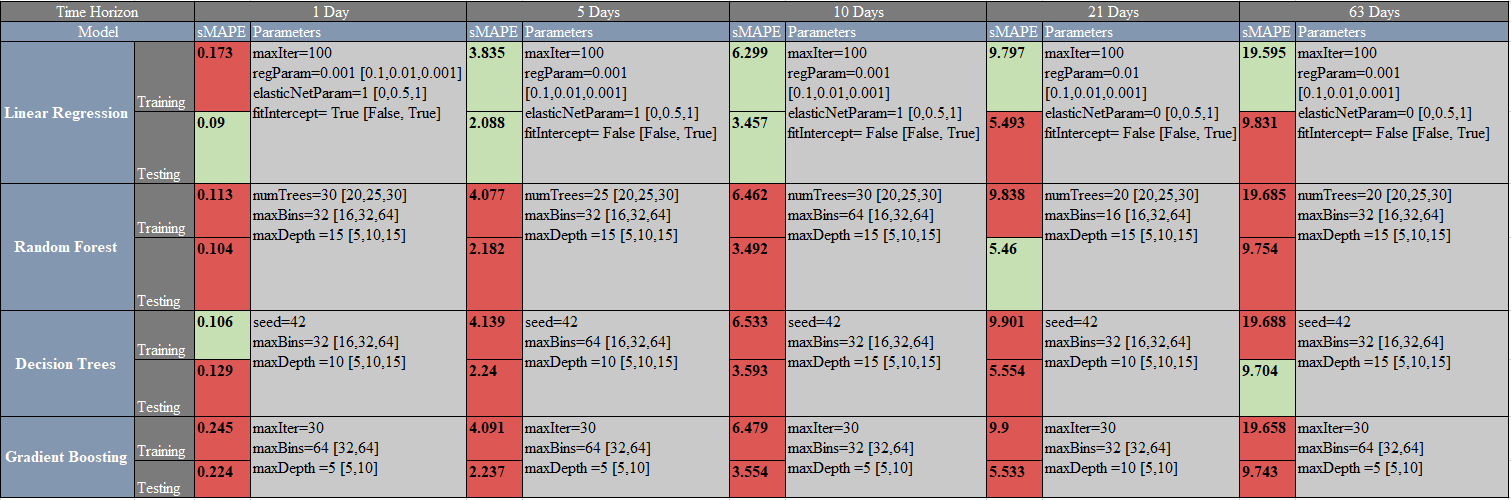

## 6. Conclusion-Model Selection

The fact that the SMAPE score for linear regression shows promising outcomes, it does not conclude that it can be used for future work. The SMAPE score for random forest and linear regression was approximately the same which is an indication that Random Forest is also another candidate to be the best model. Therefore, I deem the decrease in SMAPE score to be insignificant in comparison to model characteristic and its predictive capability. Unlike Random Forest, Linear Regression is easily affected by multicollinearity and tends to overfit. Additionally, Random Forest tends to relate important features to target variable and handles overfitting by reducing variance through creating random set of trees and aggregate their averages. Also, Random Forest can work effectively with categorical or sentiment analysis to further boost model ability to learn in case a categorical feature is added. However, Linear Regression can not handle categorical features, we have to convert categorical features into numerical values by one hot encoding which results in long computations in case we have a lot of category class. Finally, Random Forest used commonly in developing trading strategy by controlling node split for extreme leaf trading or whole tree trading.  


## 7. References 

1. https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm 
2. https://www.investopedia.com/terms/t/timeseries.asp 
3. https://towardsdatascience.com/stock-market-forecasting-using-time-series-c3d21f2dd37f
4. https://pdfs.semanticscholar.org/29a7/e1e1386db50bbb22710d63eb820f9c86ae1b.pdf
5. https://en.wikipedia.org/wiki/Stochastic 
6. https://www.investopedia.com/terms/v/vix.asp
7. http://freerangestats.info/blog/2016/12/10/extrapolation 
8. https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc43.htm
9. https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average 